# Home Credit Default Risk - Exploratory Data Analysis

### Author: Thomas SELECK
### Date: 2018-05-20

The purpose of this competition is to detect which clients of Home Credit won't be able to repay their loans.

The main goal of this notebook is to explore the data provided by Home Credit to see how it looks like and what we can do with it.

In [1]:
import time
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
import warnings
import seaborn as sns
color = sns.color_palette()
import pickle
from scipy.cluster.hierarchy import dendrogram, linkage

warnings.filterwarnings("ignore")
rcParams['figure.figsize'] = 12, 8
np.random.seed(23)

## 1. About Kaggle evaluation

Submissions are evaluated on the AUC metric.

## 2. About Kaggle submissions
 
For each *SK_ID_CURR* in the test set, we must predict a probability for the *TARGET* variable.

## 3. Loading the data and first exploration

The data provided by Home Credit is split in several files.

 - <b>application_{train|test}.csv</b><br>
    This is the main table, broken into two files for Train (with TARGET) and Test (without TARGET).
    Static data for all applications. One row represents one loan in our data sample.
    
    
 - <b>bureau.csv</b><br>
    All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who
    have a loan in our sample). For every loan in our sample, there are as many rows as number of credits the client had in
    Credit Bureau before the application date.


 - <b>bureau_balance.csv</b><br>
    Monthly balances of previous credits in Credit Bureau.
    This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has
    (#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous
    credits) rows.


 - <b>POS_CASH_balance.csv</b><br>
    Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.
    This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans)
    related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credits * # of months in
    which we have some history observable for the previous credits) rows.


 - <b>credit_card_balance.csv</b><br>
    Monthly balance snapshots of previous credit cards that the applicant has with Home Credit.
    This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans)
    related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credit cards * # of months
    where we have some history observable for the previous credit card) rows.


 - <b>previous_application.csv</b><br>
    All previous applications for Home Credit loans of clients who have loans in our sample.
    There is one row for each previous application related to loans in our data sample.


 - <b>installments_payments.csv</b><br>
    Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.
    There is a) one row for every payment that was made plus b) one row each for missed payment.
    One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous
    Home Credit credit related to loans in our sample.


 - <b>HomeCredit_columns_description.csv</b><br>
    This file contains descriptions for the columns in the various data files.

In [2]:
# Create a dictionary with features types to reduce memory consumption; this roughly halves the needed memory
main_features_dtypes_dict = {}

# Add np.int8 cols
for col in ["CNT_CHILDREN", "FLAG_MOBIL", "FLAG_EMP_PHONE", "FLAG_WORK_PHONE", "FLAG_CONT_MOBILE", "FLAG_PHONE", "FLAG_EMAIL", 
            "REGION_RATING_CLIENT", "REGION_RATING_CLIENT_W_CITY", "HOUR_APPR_PROCESS_START", "REG_REGION_NOT_LIVE_REGION", 
            "REG_REGION_NOT_WORK_REGION", "LIVE_REGION_NOT_WORK_REGION", "REG_CITY_NOT_LIVE_CITY", "REG_CITY_NOT_WORK_CITY", 
            "LIVE_CITY_NOT_WORK_CITY", "OWN_CAR_AGE", "CNT_CREDIT_PROLONG", "MONTHS_BALANCE", "CNT_DRAWINGS_CURRENT",
            "HOUR_APPR_PROCESS_START", "NFLAG_LAST_APPL_IN_DAY"]:
    main_features_dtypes_dict[col] = np.int8

# Add np.int16 cols
for col in ["DAYS_BIRTH", "DAYS_ID_PUBLISH", "DAYS_CREDIT", "CREDIT_DAY_OVERDUE", "SK_DPD", "SK_DPD_DEF", "DAYS_DECISION",
            "NUM_INSTALMENT_NUMBER"]:
    main_features_dtypes_dict[col] = np.int16

# Add np.int32 cols
for col in ["SK_ID_CURR", "DAYS_EMPLOYED", "SK_ID_BUREAU", "DAYS_CREDIT_UPDATE", "SK_ID_BUREAU", "SK_ID_PREV", 
            "AMT_CREDIT_LIMIT_ACTUAL", "SELLERPLACE_AREA"]:
    main_features_dtypes_dict[col] = np.int32

# Add np.float16 cols ; these features are integers, but as they contains NAs, they only can be casted to float
for col in ["OWN_CAR_AGE", "CNT_FAM_MEMBERS", "OBS_30_CNT_SOCIAL_CIRCLE", "DEF_30_CNT_SOCIAL_CIRCLE", "OBS_60_CNT_SOCIAL_CIRCLE",
            "DEF_60_CNT_SOCIAL_CIRCLE", "DAYS_LAST_PHONE_CHANGE", "AMT_REQ_CREDIT_BUREAU_HOUR", "AMT_REQ_CREDIT_BUREAU_DAY", 
            "AMT_REQ_CREDIT_BUREAU_WEEK", "AMT_REQ_CREDIT_BUREAU_MON", "AMT_REQ_CREDIT_BUREAU_QRT", "AMT_REQ_CREDIT_BUREAU_YEAR",
            "CNT_INSTALMENT", "CNT_INSTALMENT_FUTURE", "CNT_DRAWINGS_ATM_CURRENT", "CNT_DRAWINGS_OTHER_CURRENT", 
            "CNT_DRAWINGS_POS_CURRENT", "CNT_INSTALMENT_MATURE_CUM", "CNT_PAYMENT", "NFLAG_INSURED_ON_APPROVAL",
            "NUM_INSTALMENT_VERSION", "DAYS_INSTALMENT", "DAYS_ENTRY_PAYMENT"]:
    main_features_dtypes_dict[col] = np.float16

# Add np.float32 cols
for col in ["AMT_INCOME_TOTAL", "AMT_CREDIT", "AMT_ANNUITY", "AMT_GOODS_PRICE", "REGION_POPULATION_RELATIVE", "DAYS_REGISTRATION",
            "APARTMENTS_AVG", "BASEMENTAREA_AVG", "YEARS_BEGINEXPLUATATION_AVG", "YEARS_BUILD_AVG", "COMMONAREA_AVG", 
            "ELEVATORS_AVG", "ENTRANCES_AVG", "FLOORSMAX_AVG", "FLOORSMIN_AVG", "LANDAREA_AVG", "LIVINGAPARTMENTS_AVG", 
            "LIVINGAREA_AVG", "NONLIVINGAPARTMENTS_AVG", "NONLIVINGAREA_AVG", "APARTMENTS_MODE", "BASEMENTAREA_MODE", 
            "YEARS_BEGINEXPLUATATION_MODE", "YEARS_BUILD_MODE", "COMMONAREA_MODE", "ELEVATORS_MODE", "ENTRANCES_MODE", 
            "FLOORSMAX_MODE", "FLOORSMIN_MODE", "LANDAREA_MODE", "LIVINGAPARTMENTS_MODE", "LIVINGAREA_MODE", 
            "NONLIVINGAPARTMENTS_MODE", "NONLIVINGAREA_MODE", "APARTMENTS_MEDI", "BASEMENTAREA_MEDI", 
            "YEARS_BEGINEXPLUATATION_MEDI", "YEARS_BUILD_MEDI", "COMMONAREA_MEDI", "ELEVATORS_MEDI", "ENTRANCES_MEDI", 
            "FLOORSMAX_MEDI", "FLOORSMIN_MEDI", "LANDAREA_MEDI", "LIVINGAPARTMENTS_MEDI", "LIVINGAREA_MEDI", 
            "NONLIVINGAPARTMENTS_MEDI", "NONLIVINGAREA_MEDI", "TOTALAREA_MODE", "DAYS_CREDIT_ENDDATE", "DAYS_ENDDATE_FACT", 
            "AMT_CREDIT_MAX_OVERDUE", "AMT_CREDIT_SUM", "AMT_CREDIT_SUM_DEBT", "AMT_CREDIT_SUM_LIMIT", "AMT_CREDIT_SUM_OVERDUE", 
            "AMT_ANNUITY", "AMT_BALANCE", "AMT_DRAWINGS_ATM_CURRENT", "AMT_DRAWINGS_CURRENT", "AMT_DRAWINGS_OTHER_CURRENT", 
            "AMT_DRAWINGS_POS_CURRENT", "AMT_INST_MIN_REGULARITY", "AMT_PAYMENT_CURRENT", "AMT_PAYMENT_TOTAL_CURRENT", 
            "AMT_RECEIVABLE_PRINCIPAL", "AMT_RECIVABLE", "AMT_TOTAL_RECEIVABLE", "AMT_APPLICATION", "AMT_CREDIT", 
            "AMT_DOWN_PAYMENT", "AMT_GOODS_PRICE", "DAYS_FIRST_DRAWING", "DAYS_FIRST_DUE", "DAYS_LAST_DUE_1ST_VERSION", 
            "DAYS_LAST_DUE", "DAYS_TERMINATION", "AMT_INSTALMENT", "AMT_PAYMENT"]:
    main_features_dtypes_dict[col] = np.float32

for i in range(2, 22):
    main_features_dtypes_dict["FLAG_DOCUMENT_" + str(i)] = np.int8

print("    Loading: ../data/raw/application_train.csv ...")
training_set_df = pd.read_csv("../data/raw/application_train.csv", dtype = main_features_dtypes_dict)
print("    Loading: ../data/raw/application_test.csv ...")
testing_set_df = pd.read_csv("../data/raw/application_test.csv", dtype = main_features_dtypes_dict)
print("    Loading: ../data/raw/bureau.csv ...")
bureau_data_df = pd.read_csv("../data/raw/bureau.csv", dtype = main_features_dtypes_dict)
print("    Loading: ../data/raw/bureau_balance.csv ...")
bureau_balance_data_df = pd.read_csv("../data/raw/bureau_balance.csv", dtype = main_features_dtypes_dict)
print("    Loading: ../data/raw/credit_card_balance.csv ...")
credit_card_balance_data_df = pd.read_csv("../data/raw/credit_card_balance.csv", dtype = main_features_dtypes_dict)
print("    Loading: ../data/raw/installments_payments.csv ...")
installments_payments_data_df = pd.read_csv("../data/raw/installments_payments.csv", dtype = main_features_dtypes_dict)
print("    Loading: ../data/raw/POS_CASH_balance.csv ...")
pos_cash_balance_data_df = pd.read_csv("../data/raw/POS_CASH_balance.csv", dtype = main_features_dtypes_dict)
print("    Loading: ../data/raw/previous_application.csv ...")
previous_application_data_df = pd.read_csv("../data/raw/previous_application.csv", dtype = main_features_dtypes_dict)

# Put ID as index
print("    Put 'SK_ID_CURR' as index...")
training_set_df.index = training_set_df["SK_ID_CURR"]
training_set_df.drop("SK_ID_CURR", axis = 1, inplace = True)
testing_set_df.index = testing_set_df["SK_ID_CURR"]
testing_set_df.drop("SK_ID_CURR", axis = 1, inplace = True)

    Loading: ../data/raw/application_train.csv ...
    Loading: ../data/raw/application_test.csv ...
    Loading: ../data/raw/bureau.csv ...
    Loading: ../data/raw/bureau_balance.csv ...
    Loading: ../data/raw/credit_card_balance.csv ...
    Loading: ../data/raw/installments_payments.csv ...
    Loading: ../data/raw/POS_CASH_balance.csv ...
    Loading: ../data/raw/previous_application.csv ...
    Put 'SK_ID_CURR' as index...


### 3.1. Looking at the target

Here we want to solve a binary classification problem: either the client can repay its loan or not. What we want to know is the proportion of loan default: is the target unbalanced?

Percentage of positive target: 8.0729 %
Percentage of negative target: 91.9271 %


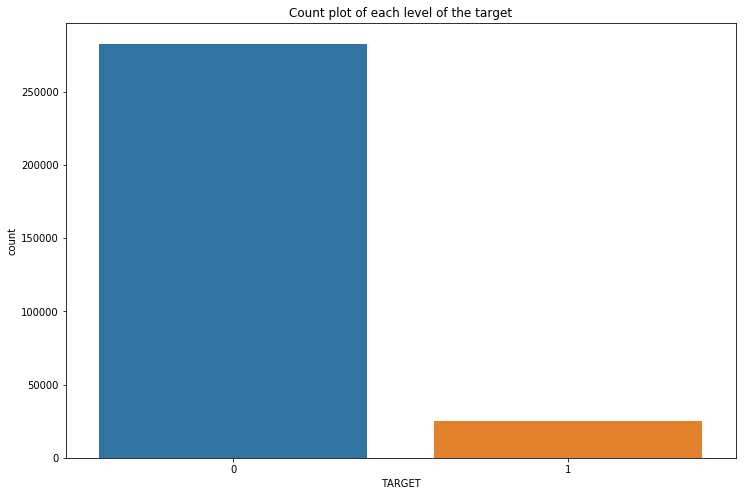

In [3]:
sns.countplot(x = training_set_df["TARGET"])
plt.title("Count plot of each level of the target")
print("Percentage of positive target:", round((training_set_df["TARGET"].loc[training_set_df["TARGET"] == 1].shape[0] / training_set_df["TARGET"].shape[0]) * 100, 4), "%")
print("Percentage of negative target:", round((training_set_df["TARGET"].loc[training_set_df["TARGET"] == 0].shape[0] / training_set_df["TARGET"].shape[0]) * 100, 4), "%")

Only 8% of the samples have a positive target. The data is highly unbalanced.
Now let's look at features from the main dataset: application_train.csv.

### 3.2. Looking at main data: application_train.csv

We'll begin by diving in the data using univariate analysis. Firstly, we split our dataset into three parts: categorical features, binary features (dummies) and numerical ones.

In [4]:
nb_levels_sr = training_set_df.nunique()
binary_features_lst = nb_levels_sr.loc[nb_levels_sr == 2].index.tolist()
categorical_features_lst = list(set(training_set_df.select_dtypes(["object"]).columns.tolist()) - set(binary_features_lst))
numerical_features_lst = list(set(training_set_df.columns.tolist()) - set(categorical_features_lst) - set(binary_features_lst))
binary_features_lst = list(set(binary_features_lst) - {"TARGET"})

print("Binary features:", binary_features_lst)
print("\n")
print("Categorical features:", categorical_features_lst)
print("\n")
print("Numerical features:", numerical_features_lst)

Binary features: ['FLAG_EMAIL', 'FLAG_WORK_PHONE', 'FLAG_DOCUMENT_14', 'REG_REGION_NOT_WORK_REGION', 'FLAG_DOCUMENT_8', 'REG_CITY_NOT_LIVE_CITY', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_21', 'FLAG_DOCUMENT_15', 'REG_REGION_NOT_LIVE_REGION', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_2', 'EMERGENCYSTATE_MODE', 'FLAG_DOCUMENT_20', 'FLAG_EMP_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_13', 'LIVE_CITY_NOT_WORK_CITY', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_9', 'FLAG_OWN_REALTY', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_16', 'NAME_CONTRACT_TYPE', 'FLAG_DOCUMENT_4', 'FLAG_MOBIL', 'LIVE_REGION_NOT_WORK_REGION', 'FLAG_OWN_CAR', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_19', 'REG_CITY_NOT_WORK_CITY']


Categorical features: ['ORGANIZATION_TYPE', 'NAME_HOUSING_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'NAME_FAMILY_STATUS', 'FONDKAPREMONT_MODE', 'OCCUPATION_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'WALLSMATERIAL_MODE

We'll begin by looking at how binary features relate with the target.

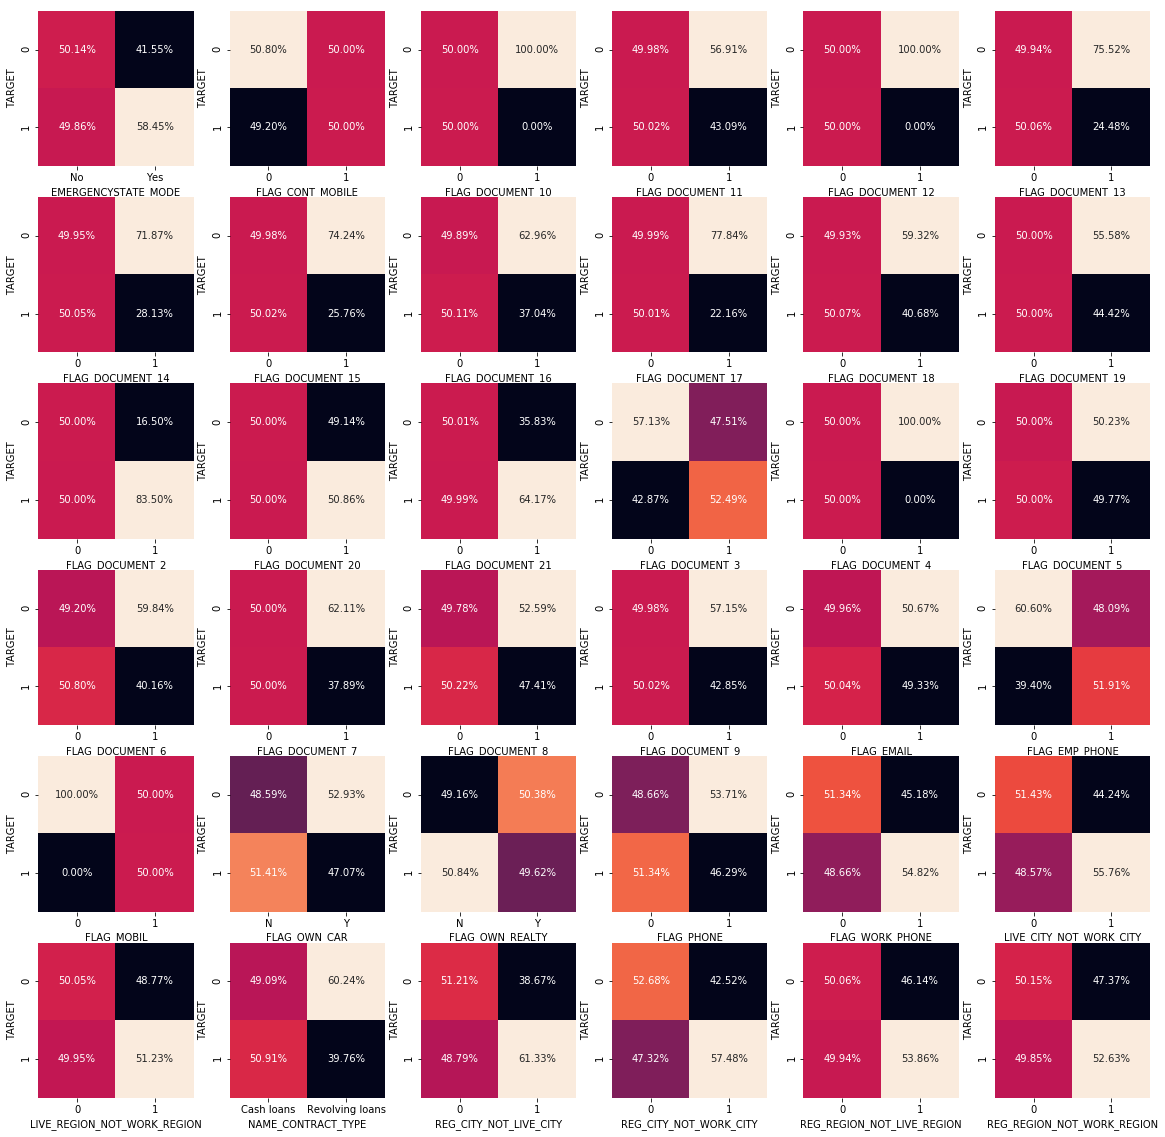

In [5]:
binary_features_lst.sort()

fig, ax = plt.subplots(6, 6, sharex = False, sharey = False, figsize = (20, 20))
i = 0
j = 0
for idx in range(len(binary_features_lst)):
    if idx % 6 == 0 and idx != 0:
        j += 1
        
    i = idx % 6
    feature = binary_features_lst[idx]
    table_df = pd.crosstab(training_set_df["TARGET"], training_set_df[feature], normalize = True)
    # Normalize statistics to remove target unbalance
    table_df = table_df.div(table_df.sum(axis = 1), axis = 0)
    table_df = table_df.div(table_df.sum(axis = 0), axis = 1)
    sns.heatmap(table_df, annot = True, square = True, ax = ax[j, i], cbar = False, fmt = '.2%')

Here, we can see that some binary features, when they equal to 1, gives the right target. These features are the following:
 - *FLAG_DOCUMENT_10*
 - *FLAG_DOCUMENT_12*
 - *FLAG_DOCUMENT_4*

For the feature *FLAG_MOBIL*, when it equals to 0, the target is always 0.
Another interesting fact is that for those four features, when they are the other level (0 for the first three, and 1 for the last one), probability of target equal to 1 is 50%. So in this case these features are totally useless.

Now, let's look at categorical features.

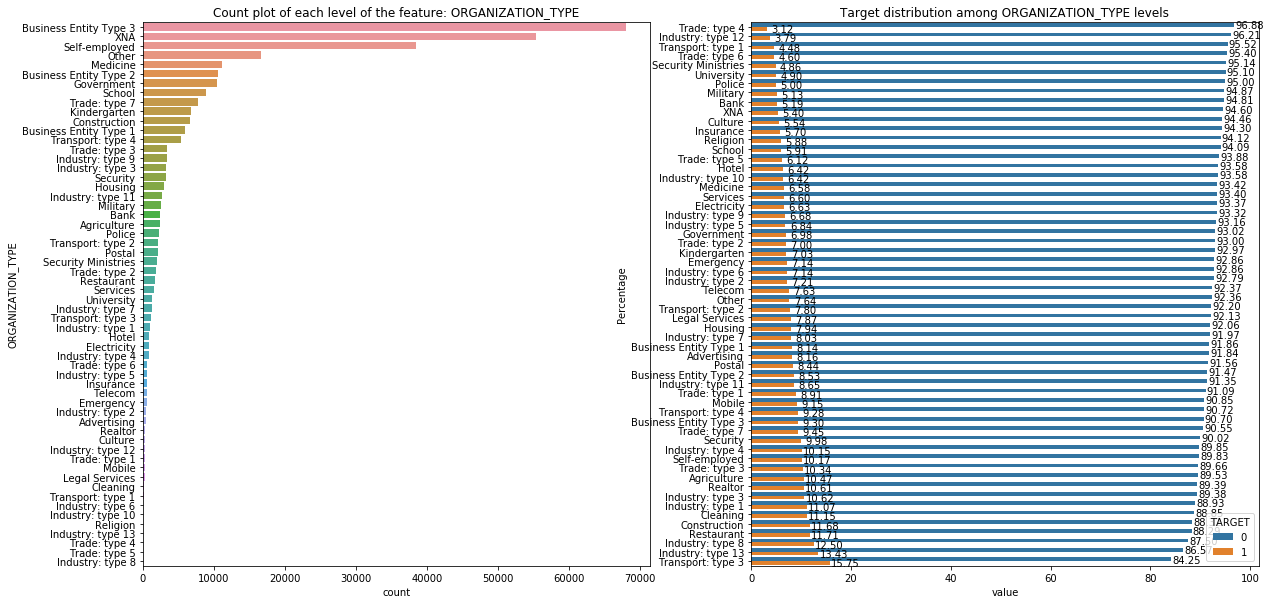

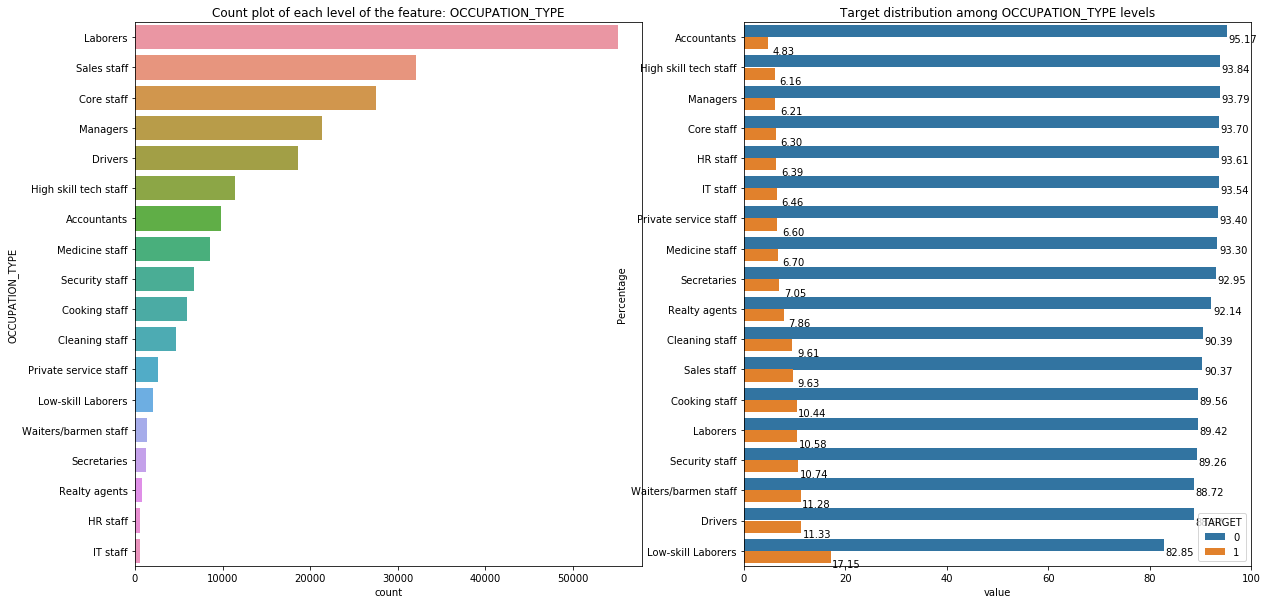

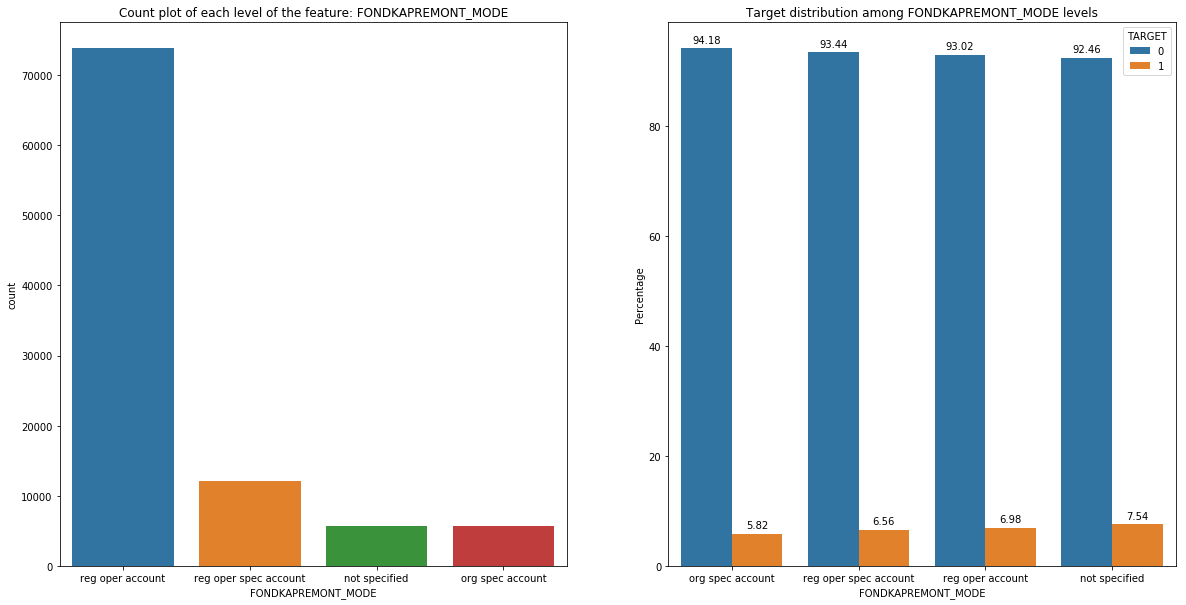

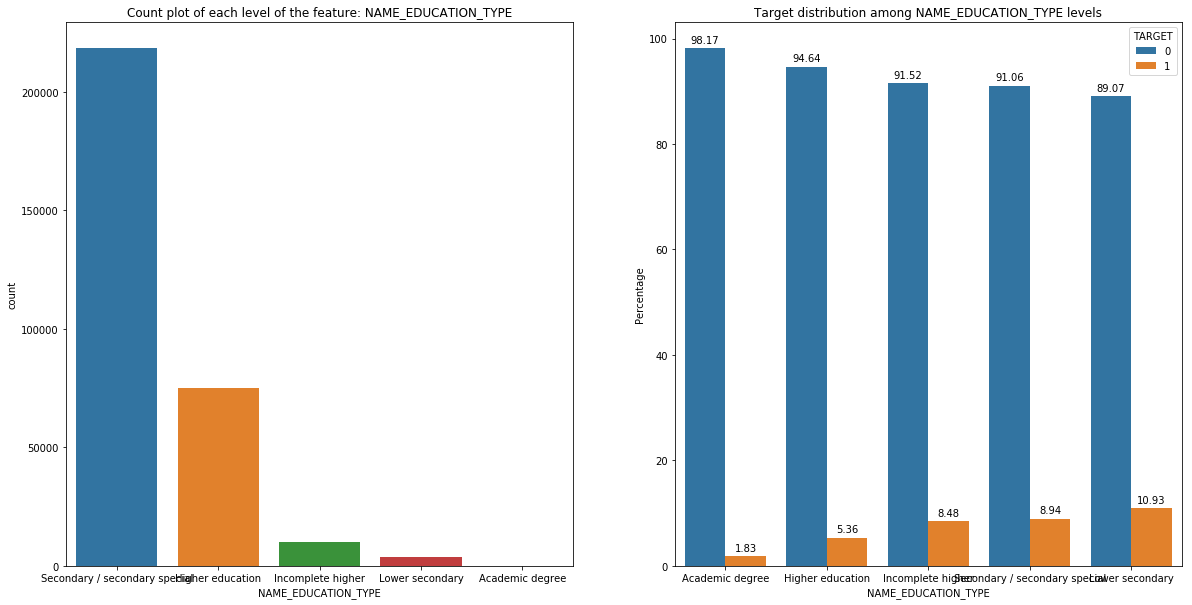

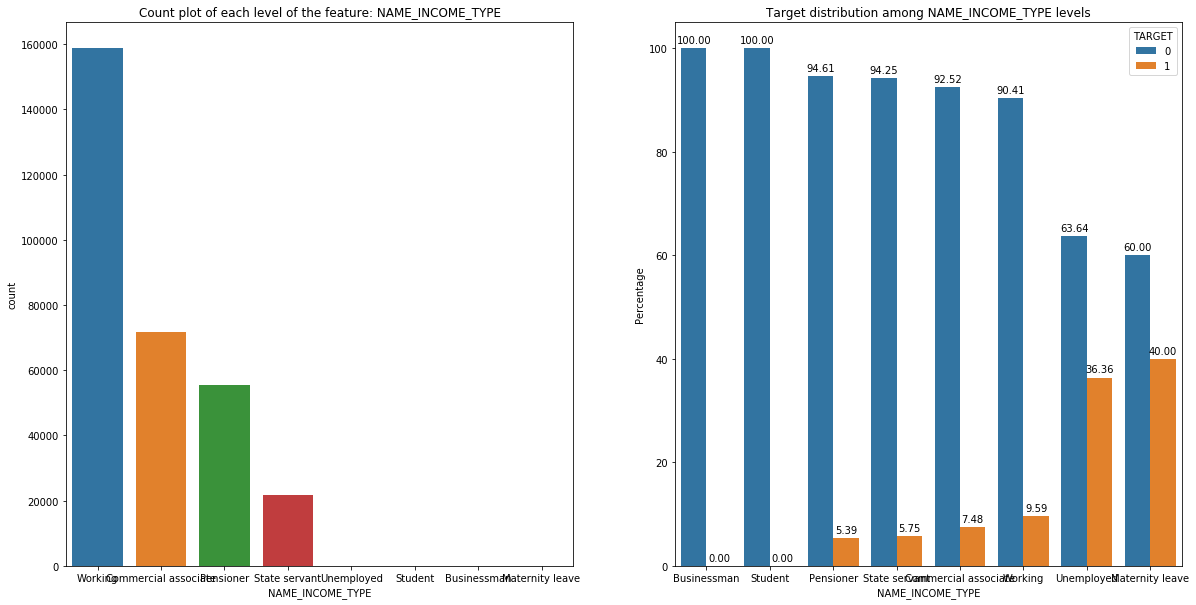

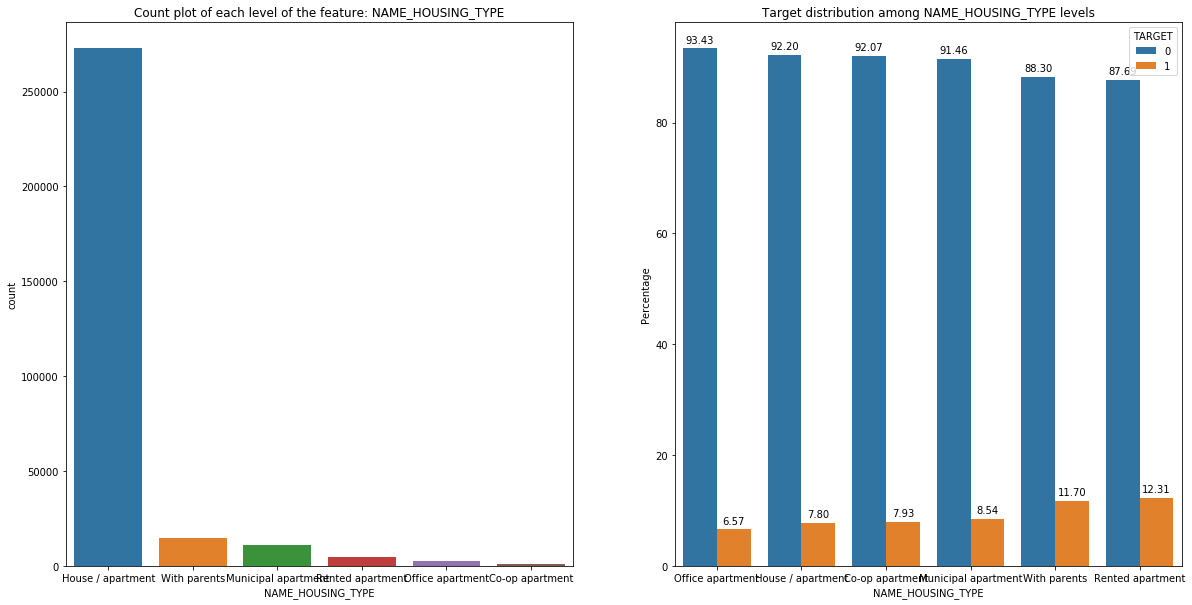

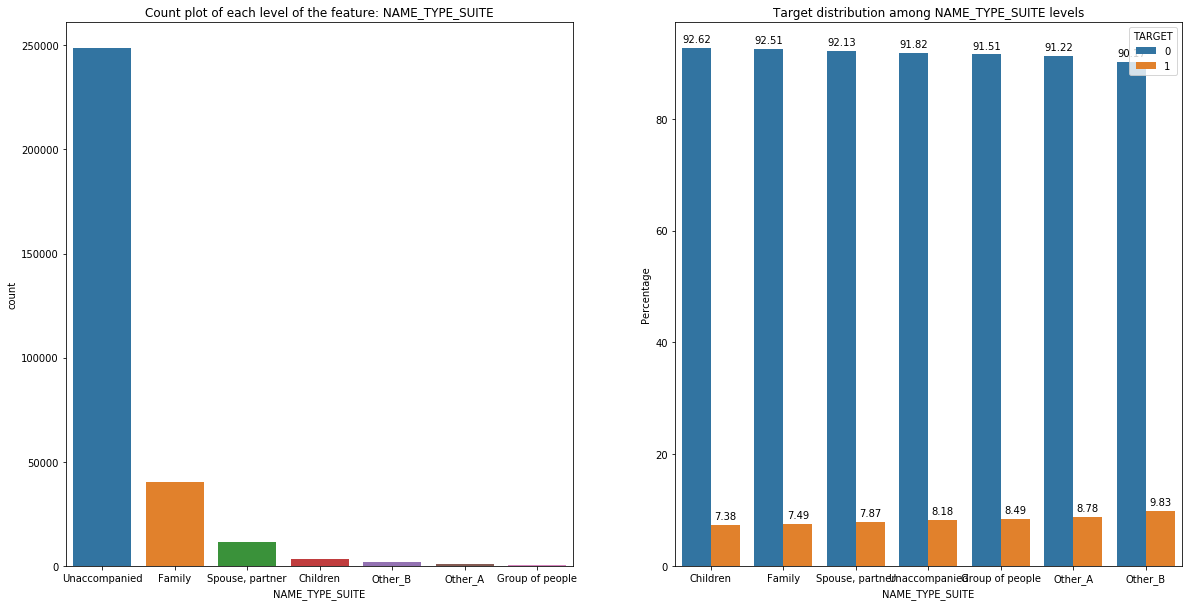

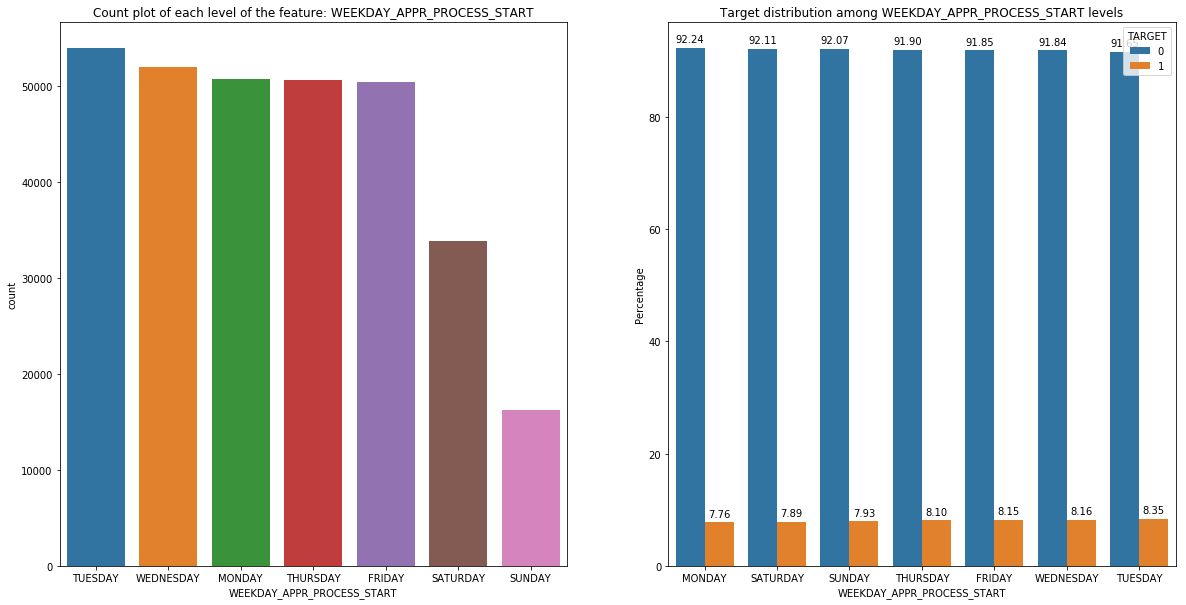

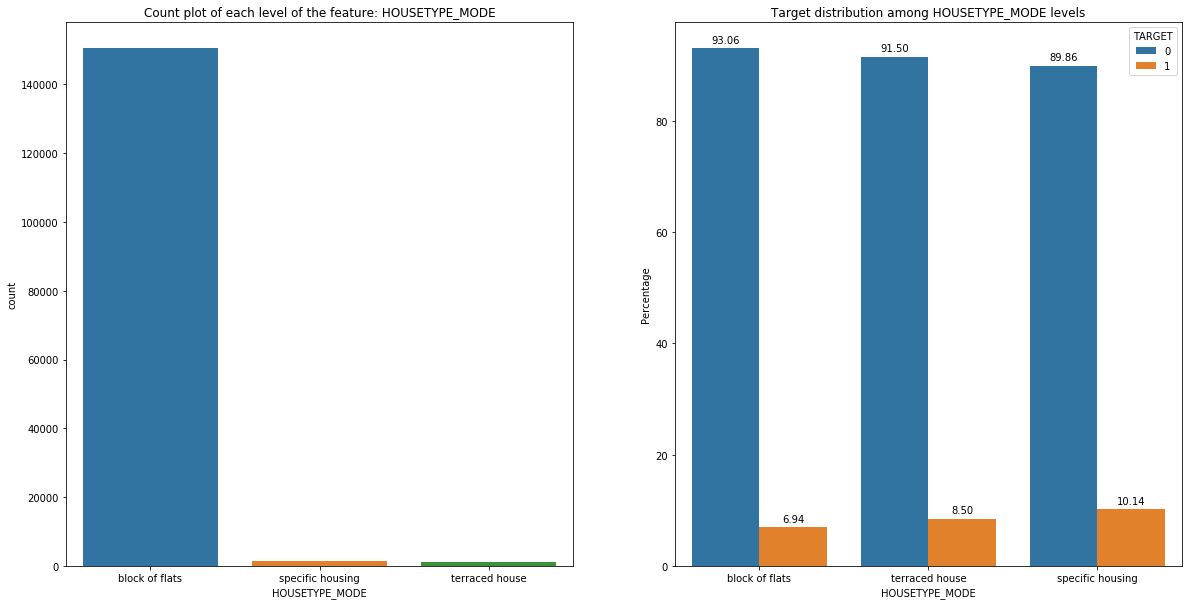

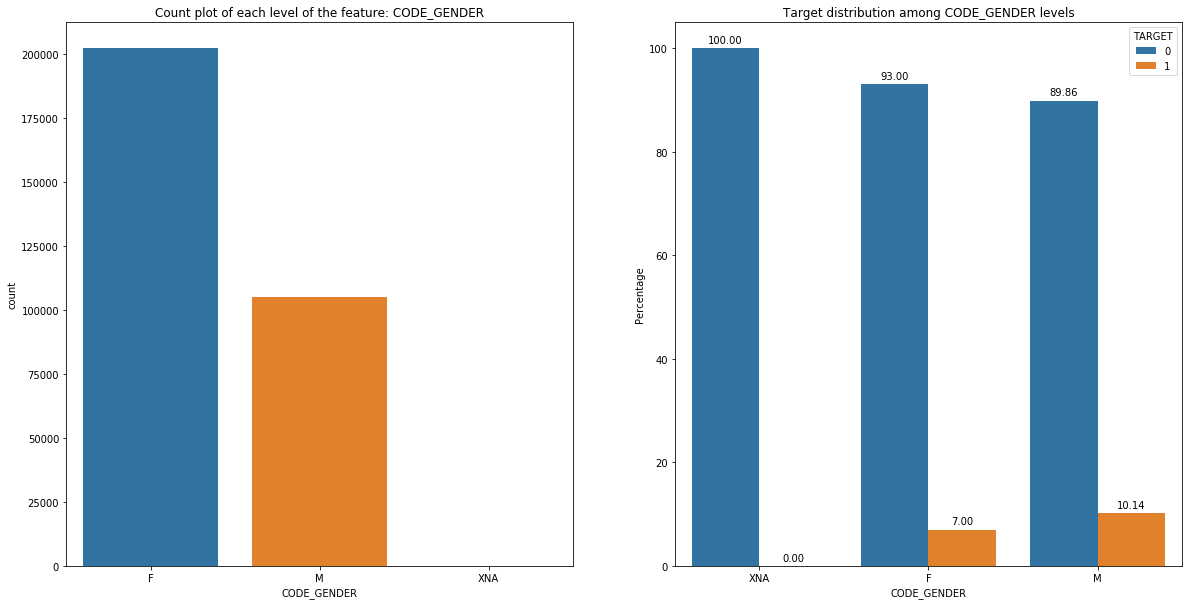

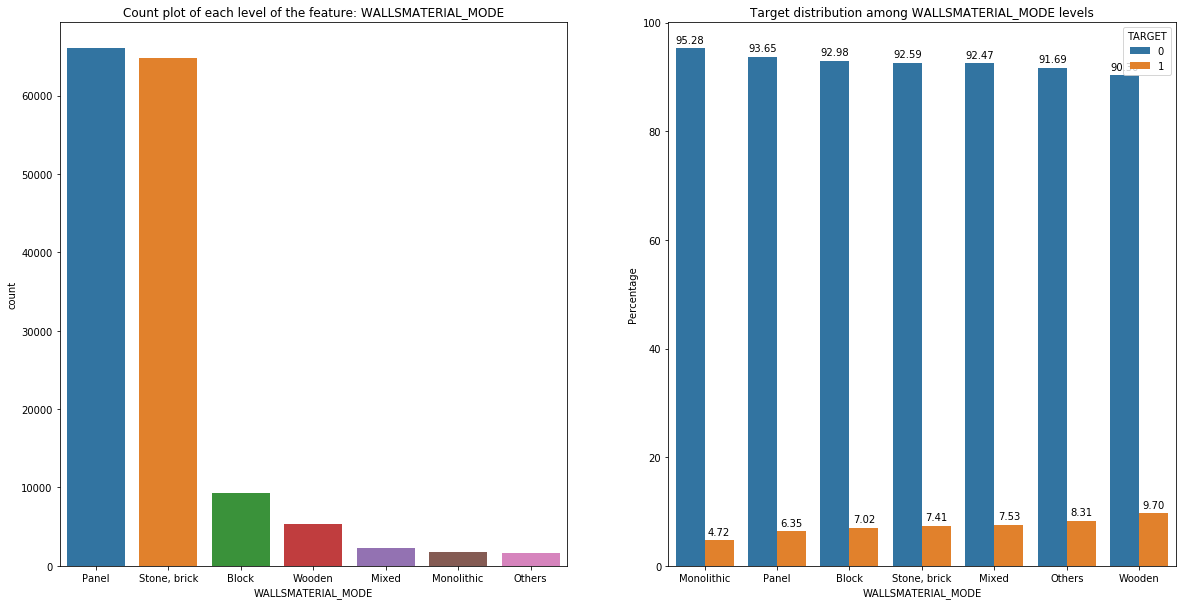

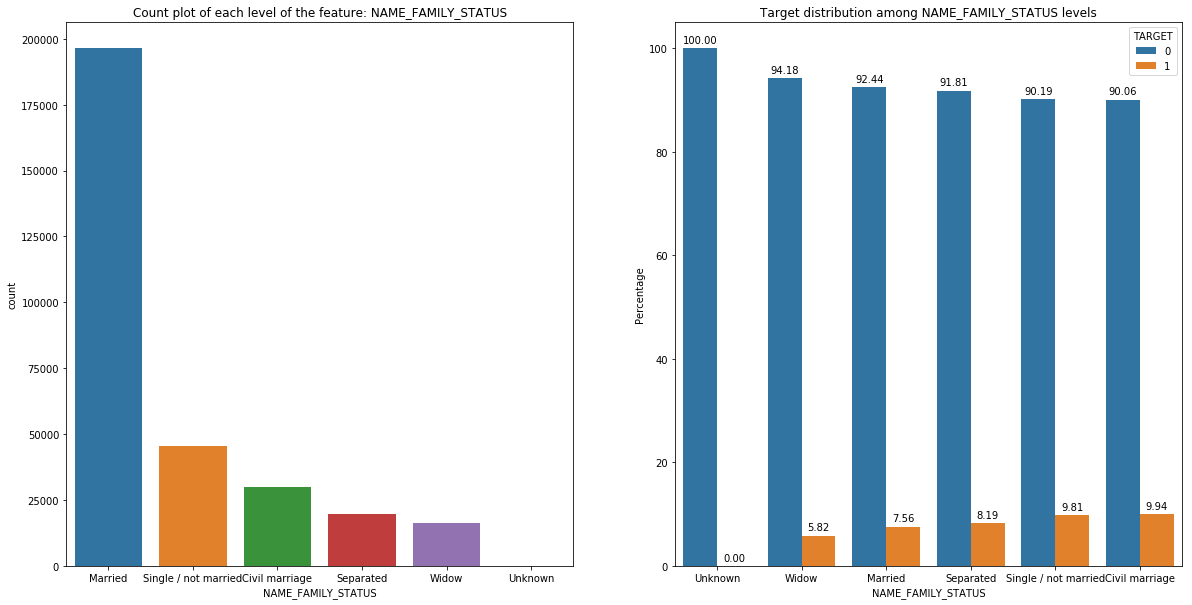

In [6]:
for feature in categorical_features_lst:
    fig, ax = plt.subplots(1, 2, sharex = False, sharey = False, figsize = (20, 10))
    # Plot levels distribution
    if training_set_df[feature].nunique() < 10:
        sns.countplot(x = training_set_df[feature], ax = ax[0], order = training_set_df[feature].value_counts().index.tolist())
    else:
        sns.countplot(y = training_set_df[feature], ax = ax[0], order = training_set_df[feature].value_counts().index.tolist())
    ax[0].set_title("Count plot of each level of the feature: " + feature)

    # Plot target distribution among levels
    table_df = pd.crosstab(training_set_df["TARGET"], training_set_df[feature], normalize = True)
    table_df = table_df.div(table_df.sum(axis = 0), axis = 1)
    table_df = pd.crosstab(training_set_df["TARGET"], training_set_df[feature], normalize = True)
    table_df = table_df.div(table_df.sum(axis = 0), axis = 1)
    table_df = table_df.transpose().reset_index()
    order_lst = table_df.sort_values(by = 1)[feature].tolist()
    table_df = table_df.melt(id_vars = [feature])
    if training_set_df[feature].nunique() < 10:
        ax2 = sns.barplot(x = table_df[feature], y = table_df["value"] * 100, hue = table_df["TARGET"], ax = ax[1], order = order_lst)
        for p in ax2.patches:
            height = p.get_height()
            ax2.text(p.get_x() + p.get_width() / 2., height + 1, "{:1.2f}".format(height), ha = "center")
    else:
        ax2 = sns.barplot(x = table_df["value"] * 100, y = table_df[feature], hue = table_df["TARGET"], ax = ax[1], order = order_lst)
        for p in ax2.patches:
            width = p.get_width()
            ax2.text(width + 3.1, p.get_y() + p.get_height() / 2. + 0.35, "{:1.2f}".format(width), ha = "center")

    ax[1].set_title("Target distribution among " +  feature + " levels")
    ax[1].set_ylabel("Percentage")

Here, we can see some interesting insights from this data:
 - Materials composing the walls do have an influence on the default risk of the client: clients living in Wooden houses have twice the risk of default than clients living in Monolithic houses
 - The distribution of the type of organization where the client works is highly skewed, but we can see that some sectors are more prone to have defaulting clients. It will be interesting to link them with client's wages.
 - The vast majority of clients come to the bank to get a loan unaccompanied. But this feature doesn't have a great influence on the default risk.
 - Client's education have a great impact on his default risk: having an academic degree reduces the default risk 5 times compared to lower secondary education. There is probably a link between education, salary and ease of finding and keeping a job.
 - Majority of clients are laborers or sales staff. Here being an accountant reduces the default risk by a factor of 3.55 compared to a low-skilled laborer. This goes in the same way than education.
 - Most of the clients are married, but family status have a low impact on default risk unless you are a widow. In this case, your risk decrease.
 - The studied population is composed of 1/3 men and 2/3 women. Men have a higher risk of default than women.
 - Majority of people live in a flat or house they own. People that live with their parents or in a rented appartment have twice the risk than people that own their home.
 - Income type has a great impact on the default risk. Unemployed people or people in maternity leave have a huge default risk.
 - Majority of people live in a block of flats.
 
Here, we can see that population is split on two axis that are correlated: the people's wealth (poorest people have greater default risk than richest ones) and the people's education (higher education means lower default risk).

Now, let's look at numerical features.

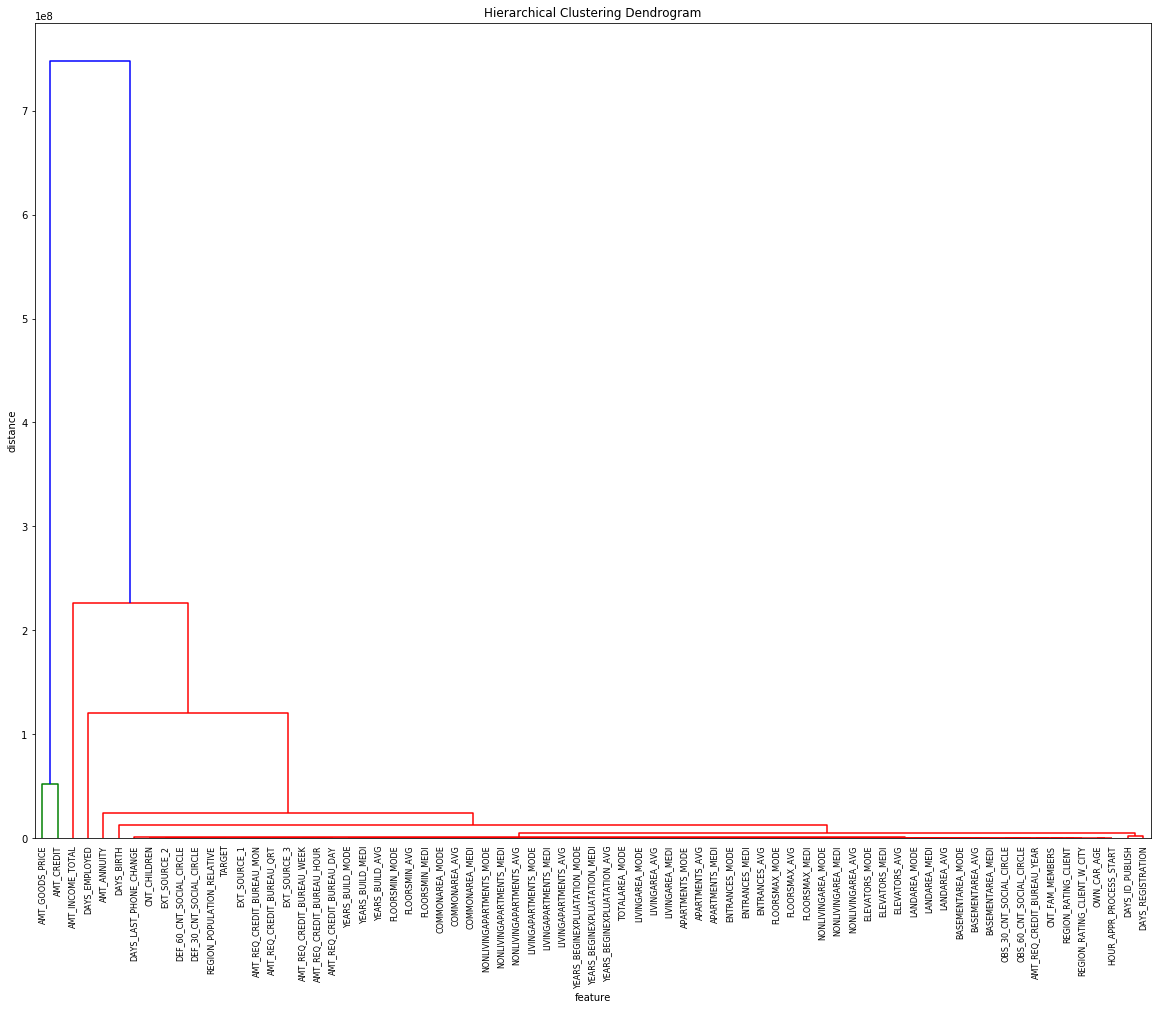

In [7]:
# generate the linkage matrix
numerical_features_df = training_set_df[numerical_features_lst + ["TARGET"]]
numerical_features_df.fillna(-1, inplace = True) # We need to impute missing values before creating the dendrogram
numerical_features_df = numerical_features_df.transpose()
Z = linkage(numerical_features_df, "ward")
plt.figure(figsize = (20, 15))
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("feature")
plt.ylabel("distance")
dend = dendrogram(
    Z,
    leaf_rotation = 90.,  # rotates the x axis labels
    leaf_font_size = 8.,  # font size for the x axis labels
    labels = numerical_features_df.index.tolist()
)

From the dendrogram above, we can distinguish several groups of features that similar.
 - *AMT_CREDIT* and *AMT_GOODS_PRICE* are in the same cluster. One feature gives the amount of the loan, the other gives the price of the good we want to buy with the loan. As in the majority of cases the amount of the loan equals the price of the good, both features will be highly similar and correlated.
 - *DAYS_ID_PUBLISH* and *DAYS_REGISTRATION*: these features indicate the number of days between the loan application and the change of the identity document with which he applied for the loan for the first and days between the loan application and the change of registration for the second. As these features are similar, we can think that when the client changes his registration, he also changes his identity document.
 - *AMT_INCOME_TOTAL*, *DAYS_EMPLOYED*, *AMT_ANNUITY*, *DAYS_BIRTH* are put apart from other features by hierarchical clustering.
 - Other features are highly similar and are related to the home of the client.
 - "Black box" features *EXT_SOURCE_1*, *EXT_SOURCE_2*, *EXT_SOURCE_3* are in the same group than home-related features. Maybe they also are related to client's home.
 
Now, let's plot correlation matrix between the numerical features and the target.

Text(0.5,1,'Correlation plot between numerical features and target')

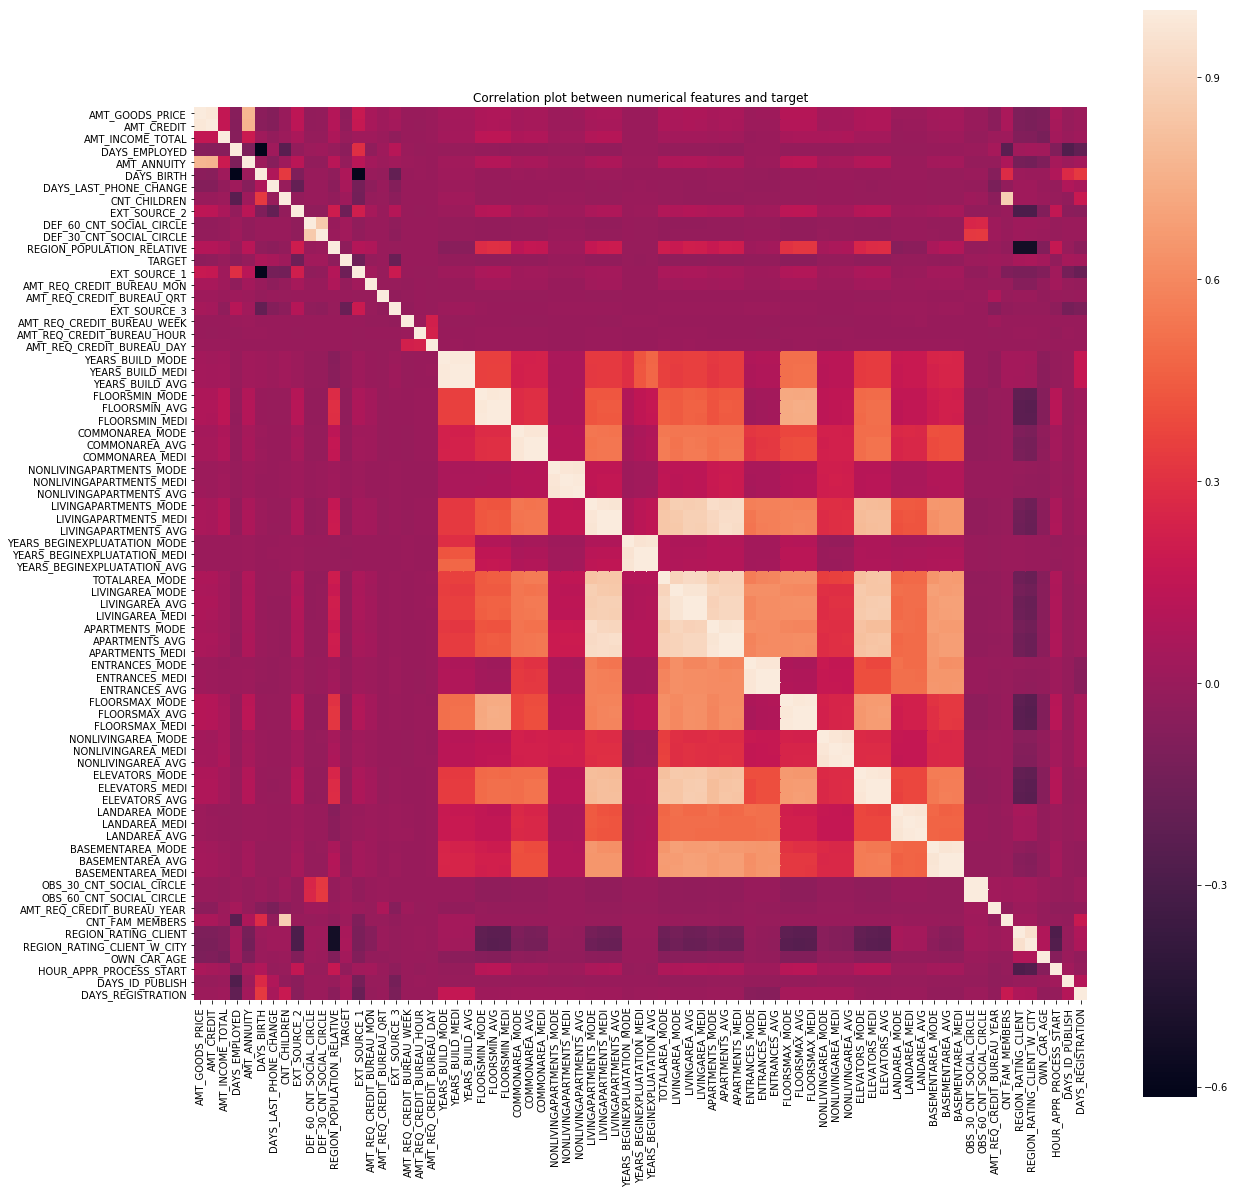

In [8]:
plt.figure(figsize = (20, 20))
sns.heatmap(training_set_df[dend["ivl"]].corr(), annot = False, square = True)
plt.title("Correlation plot between numerical features and target")

Here, we can see that numerical features have a low correlation with the target we want to predict. Only the features *EXT_SOURCE_1*, *EXT_SOURCE_2* and *EXT_SOURCE_3* have a correlation greater than 15%.

We can also distinguish clusters of features in white / yellow on the correlation plot above that are highly correlated. These features are majoritely related to the client's home.

Here, client's home have a low correlation with target: the home where the client lives have little impact on the default risk. It's probably because near all clients live in a block of flats and their homes are similar.

Now let's plot each numerical feature to look at its distribution.

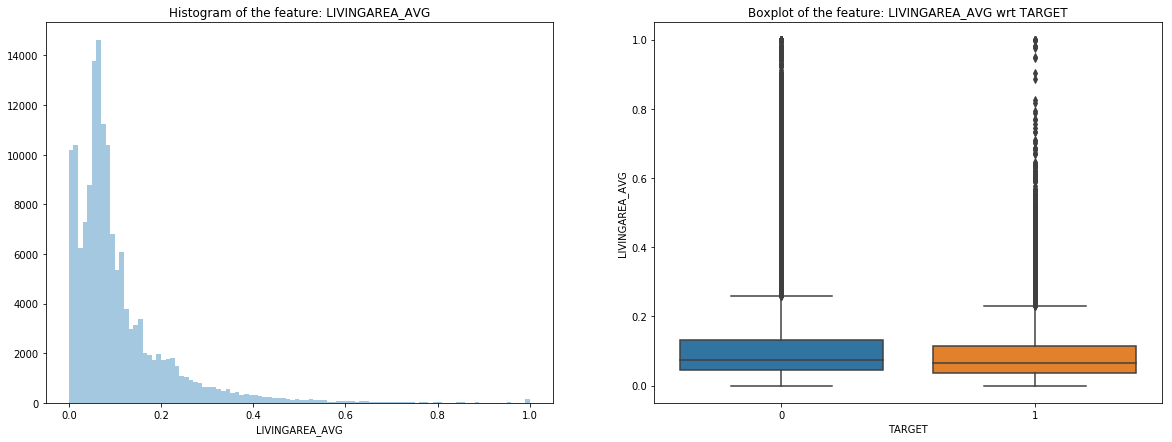

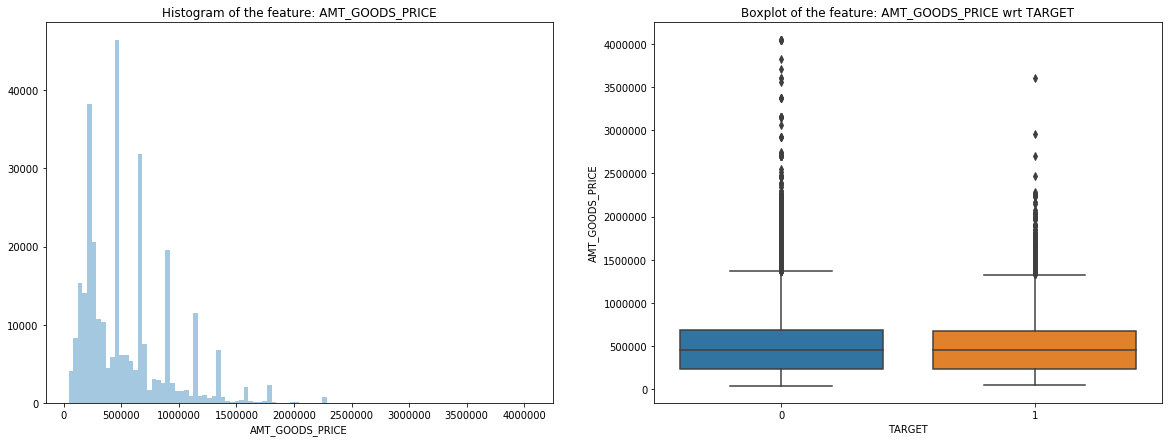

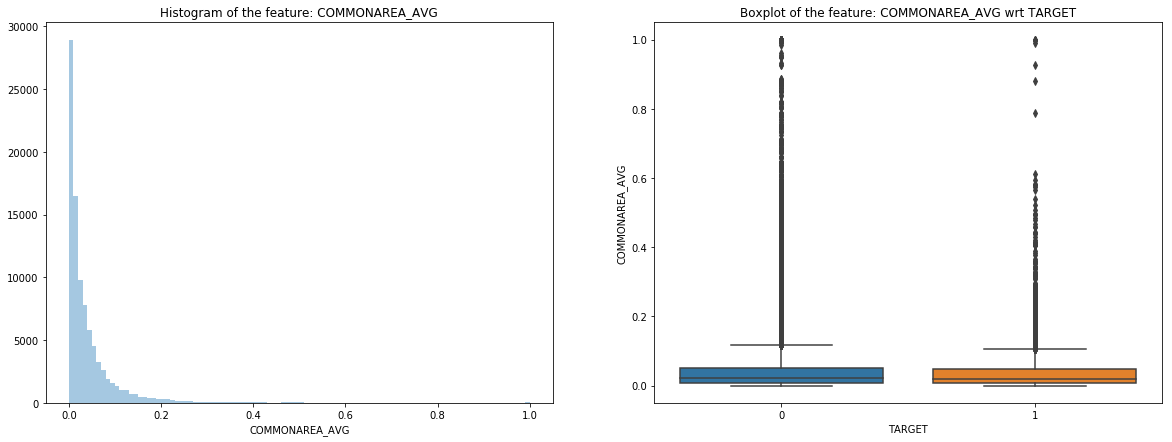

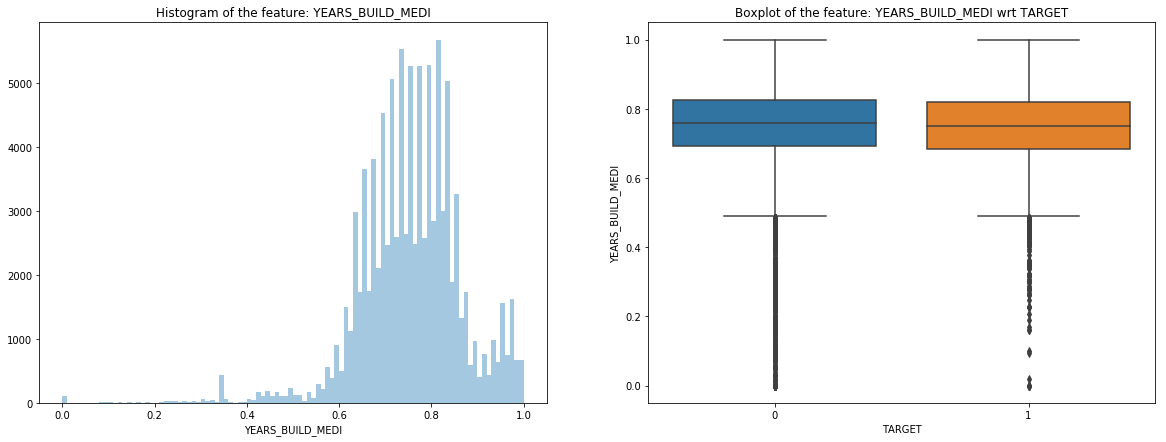

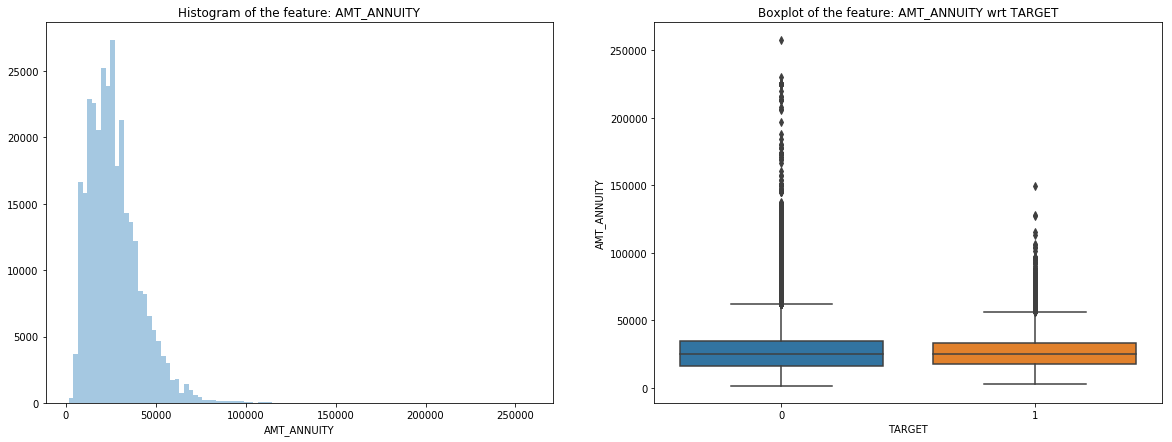

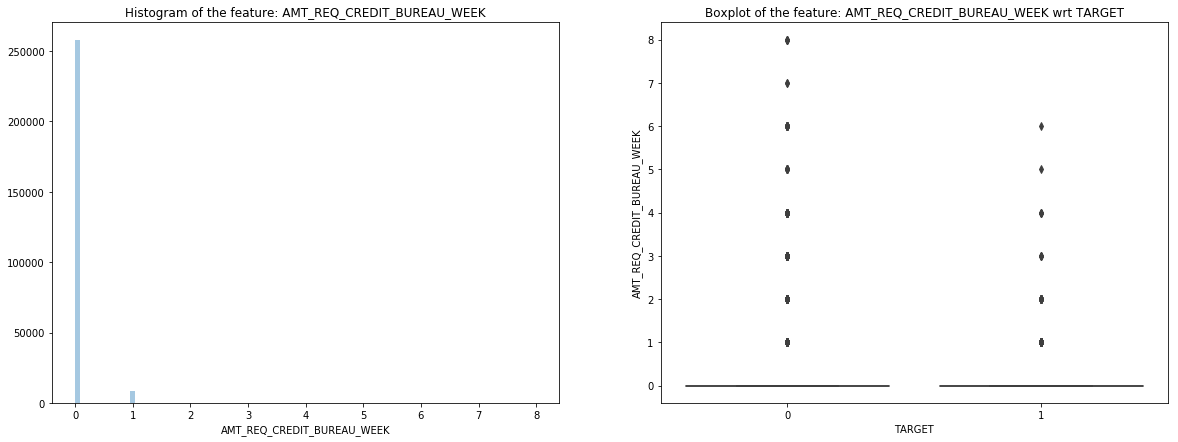

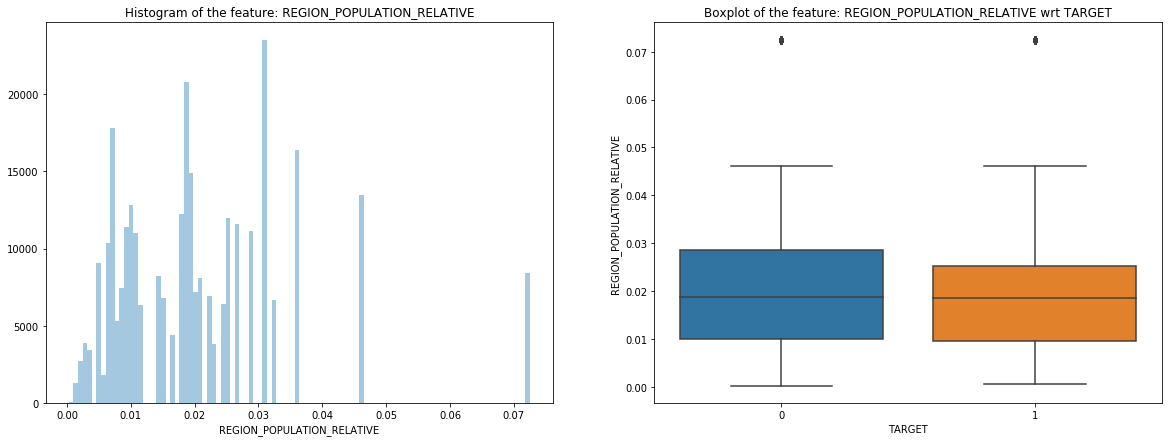

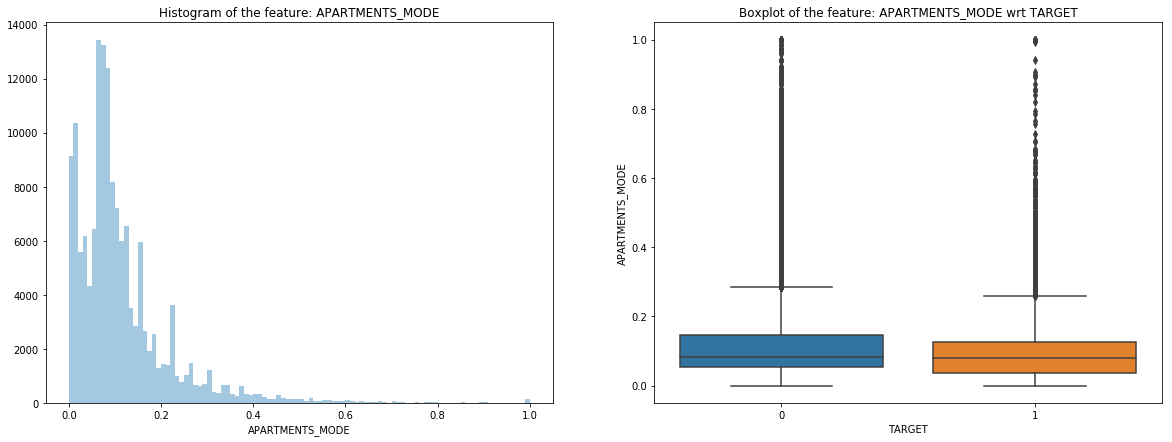

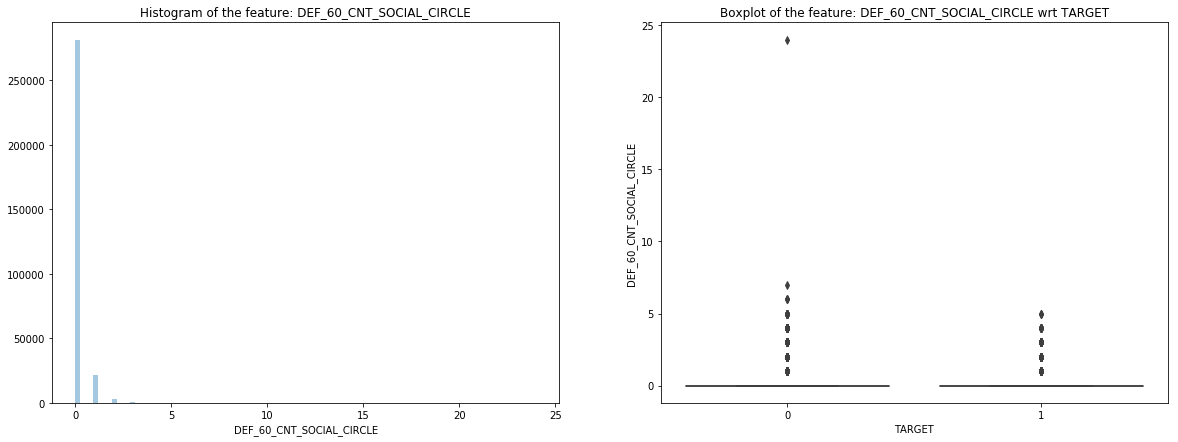

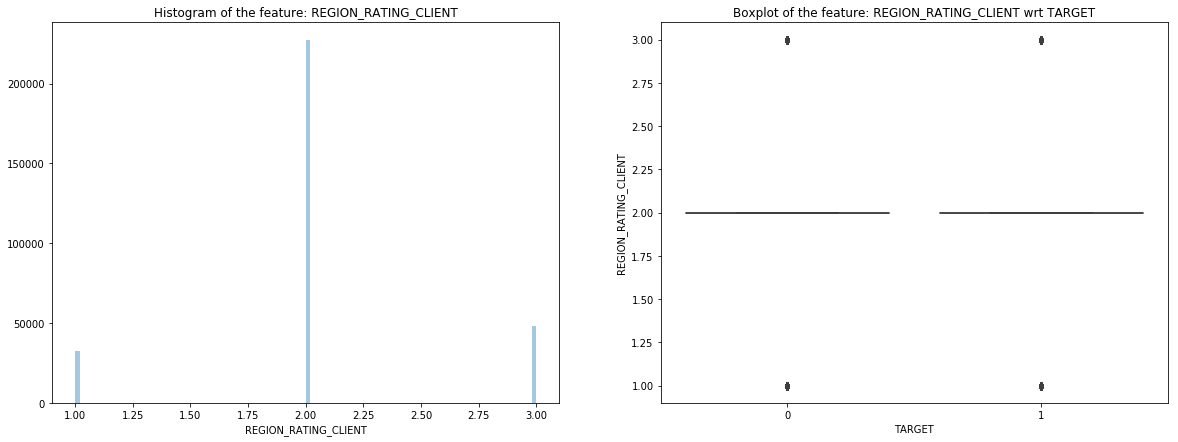

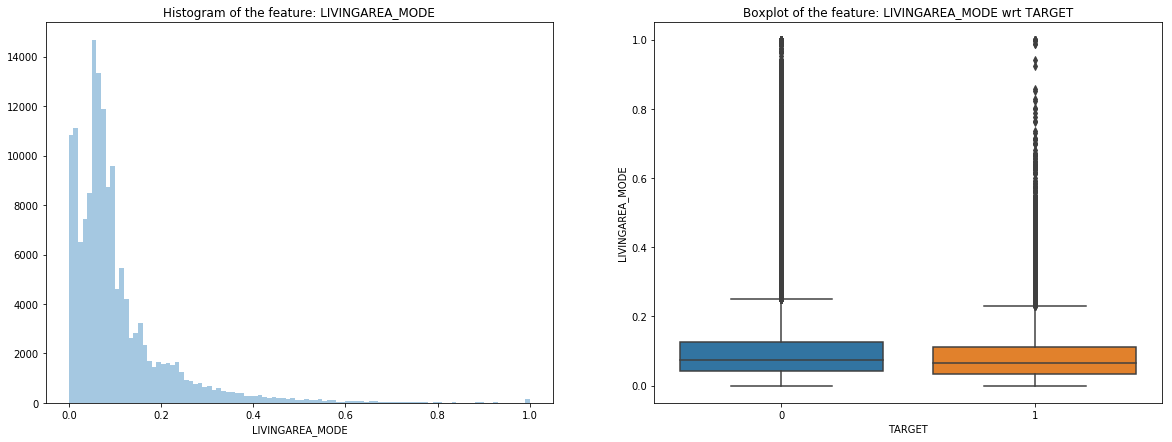

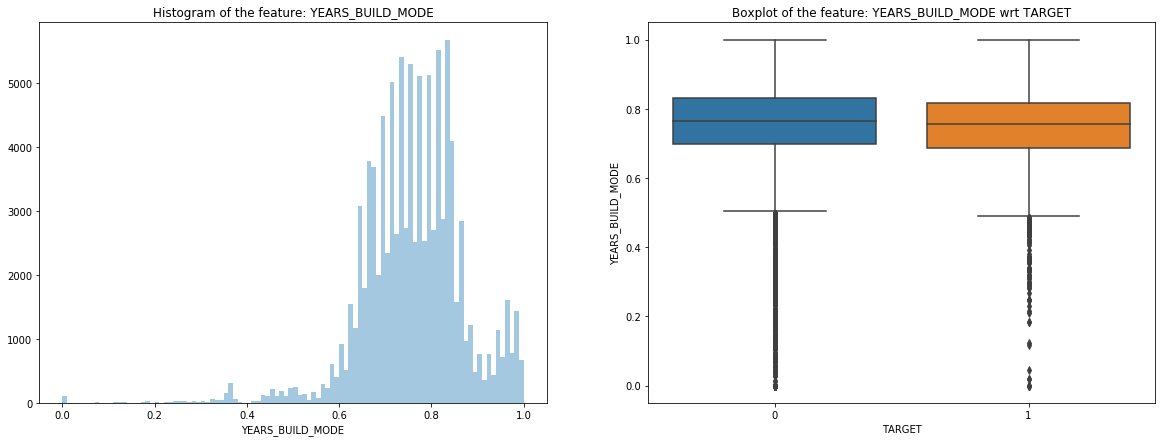

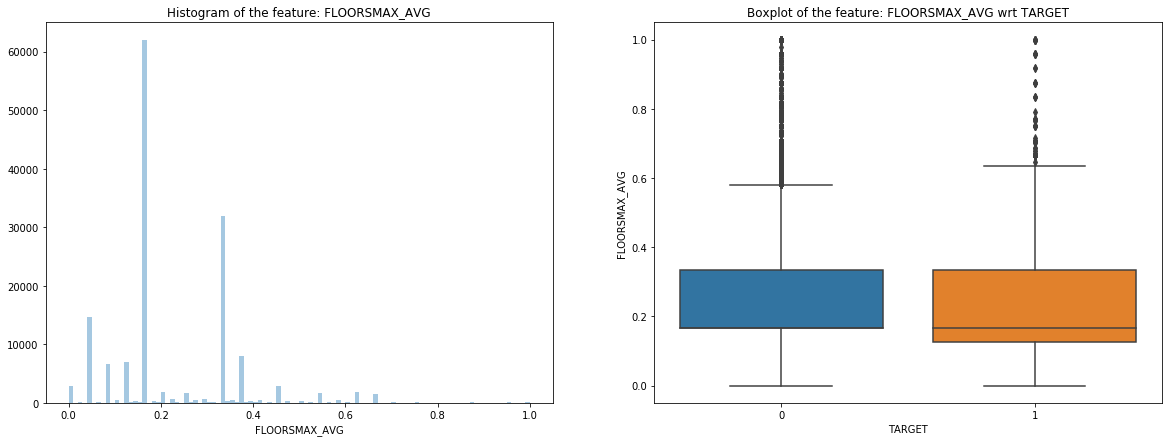

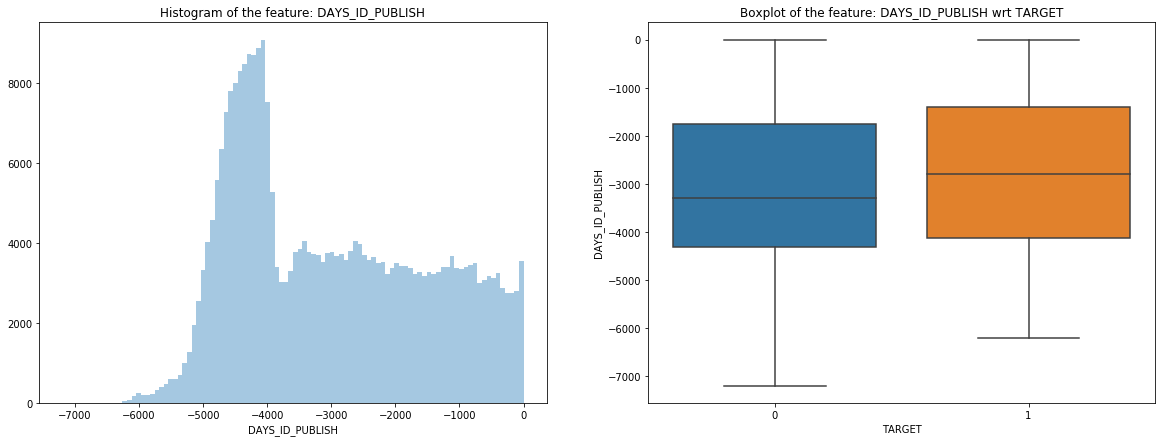

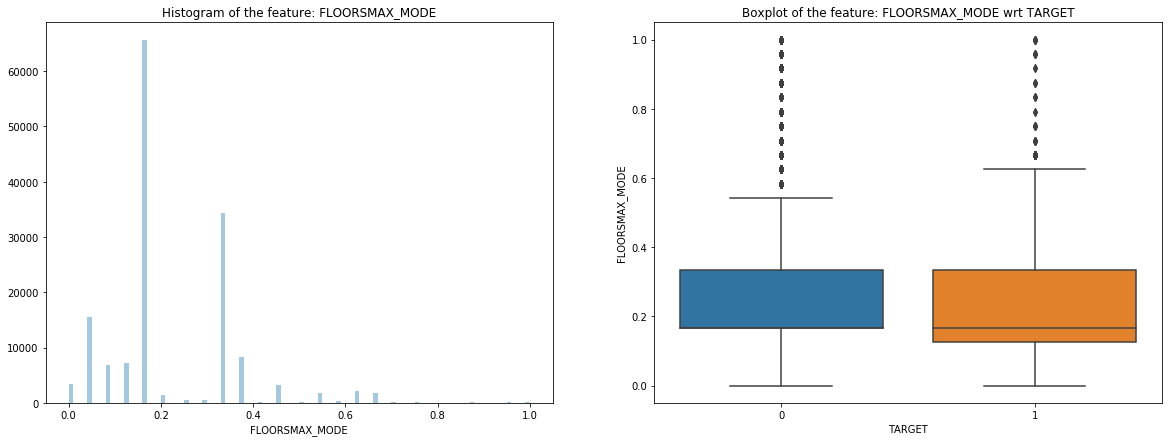

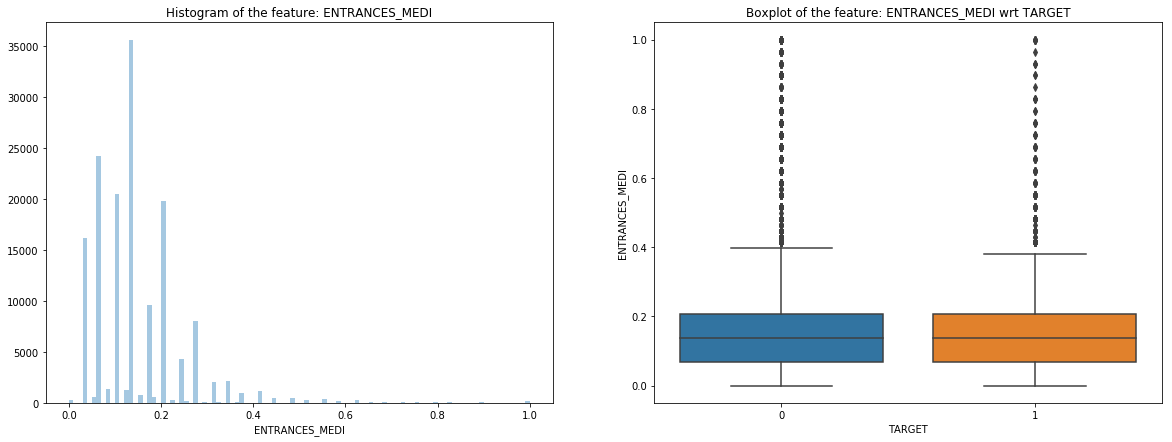

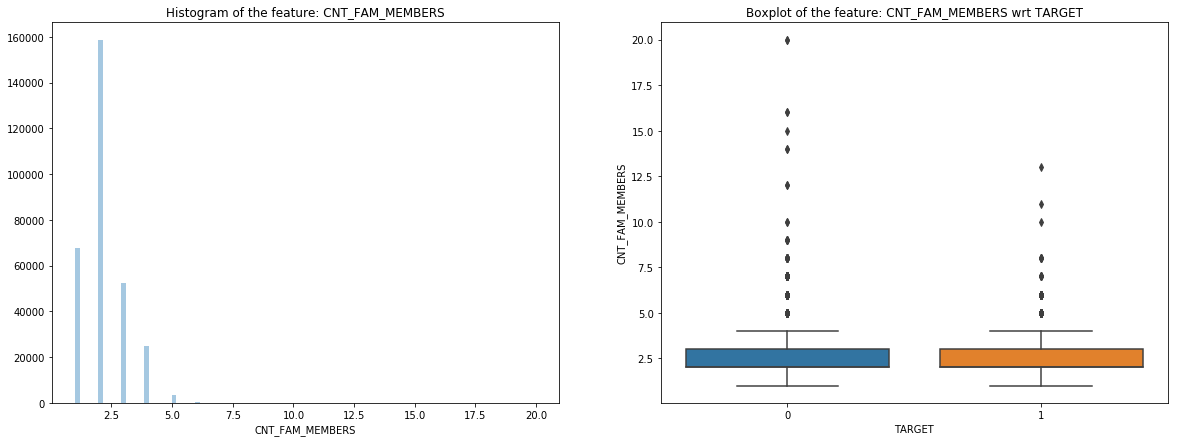

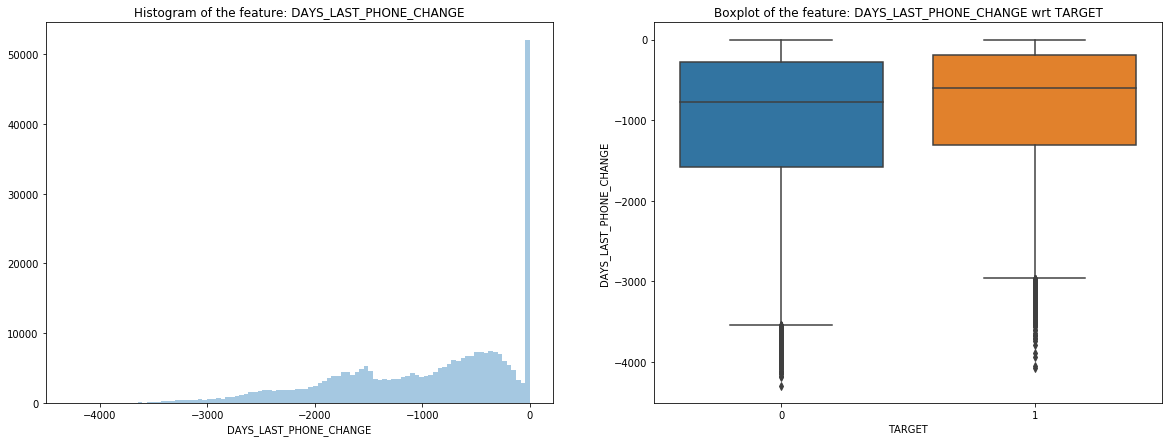

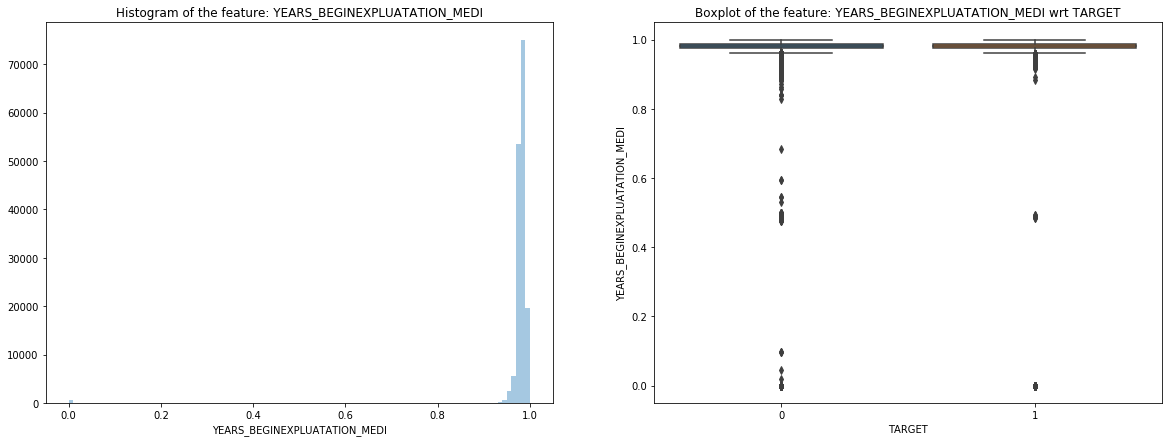

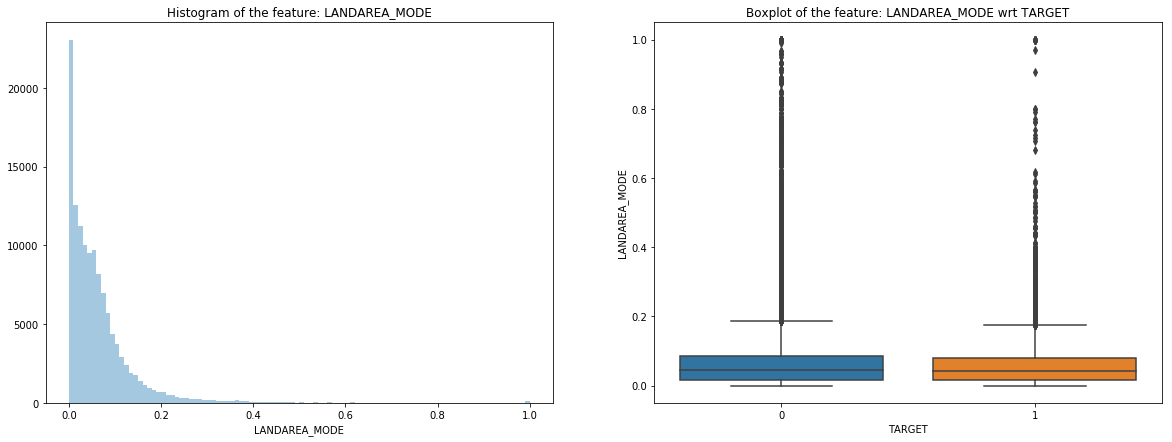

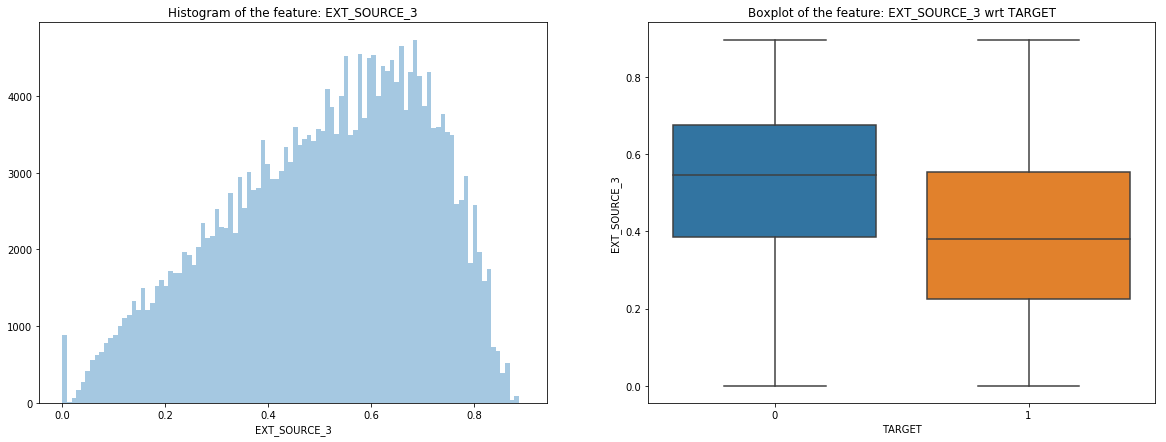

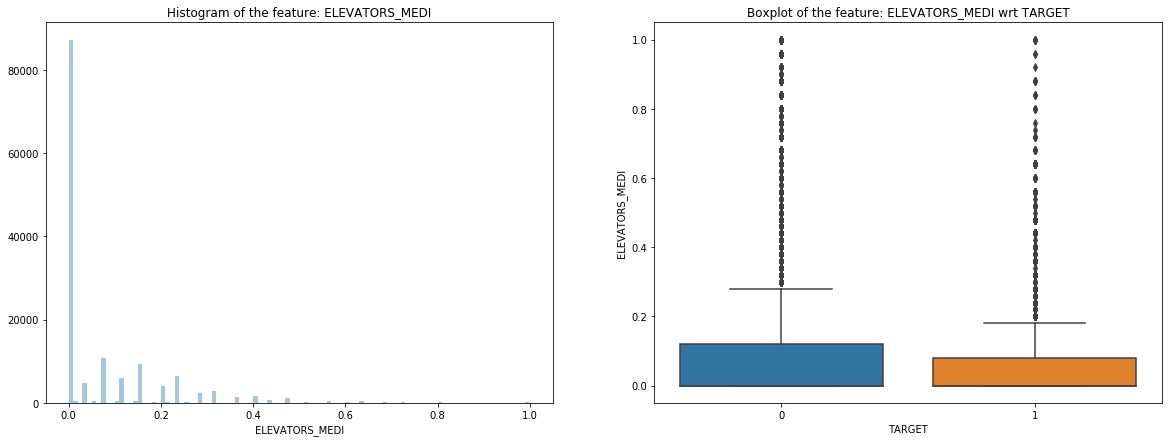

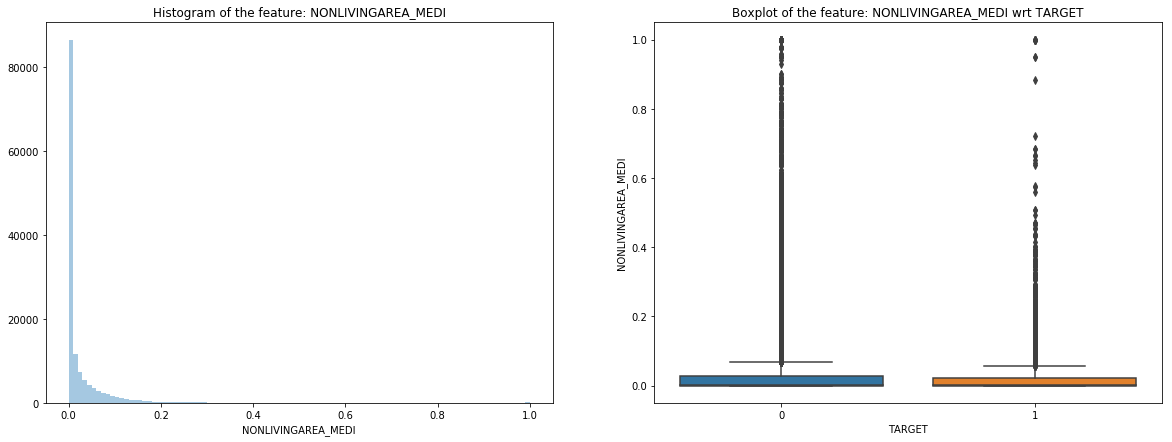

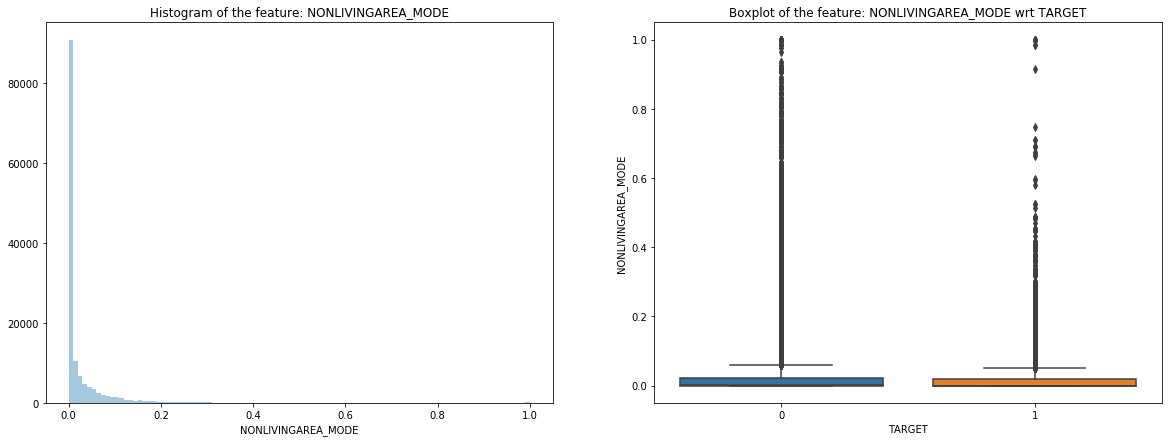

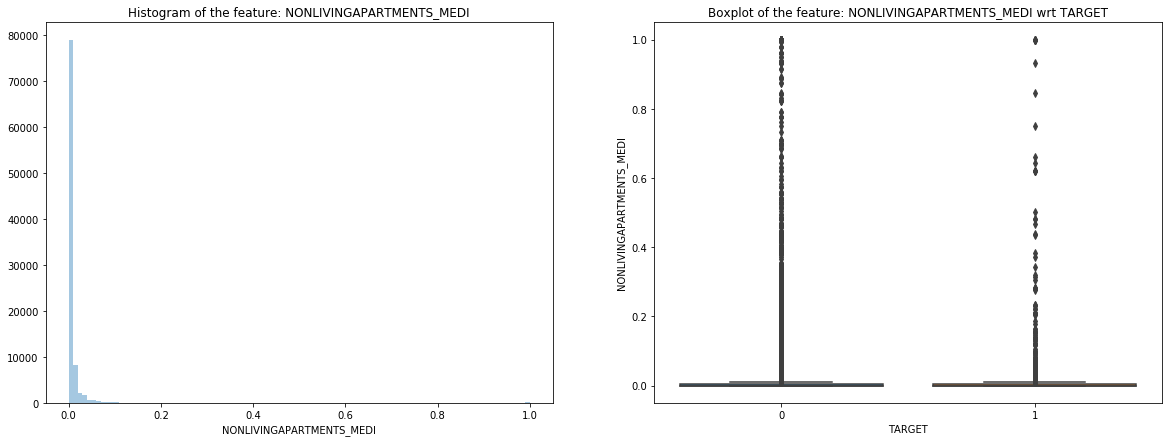

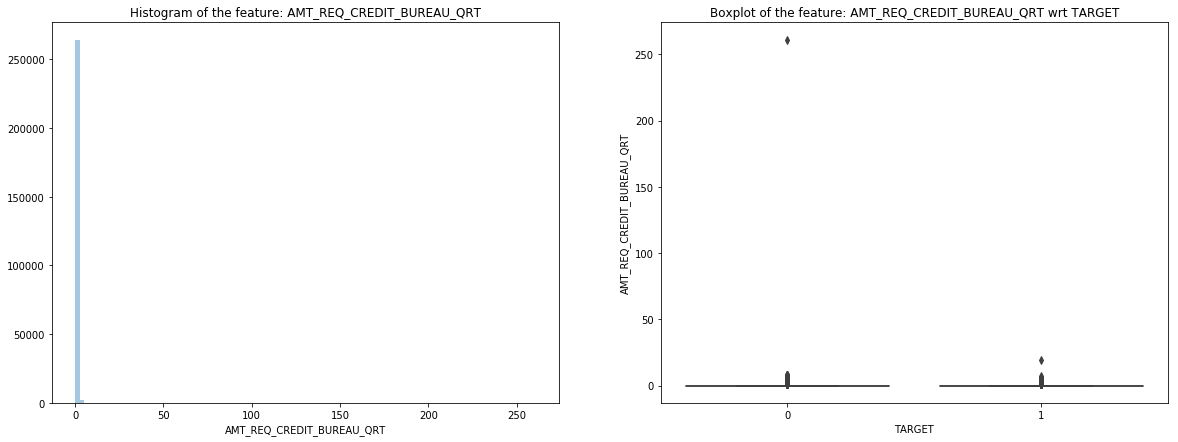

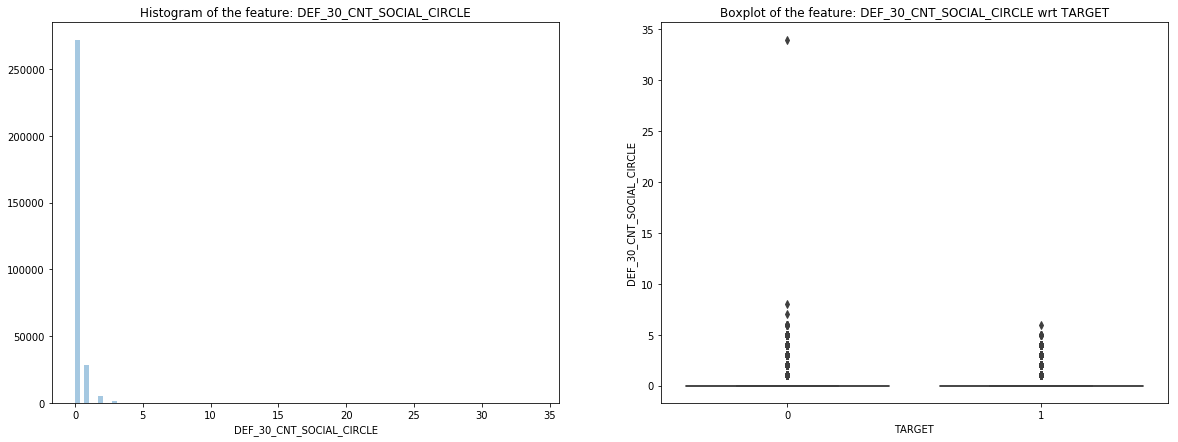

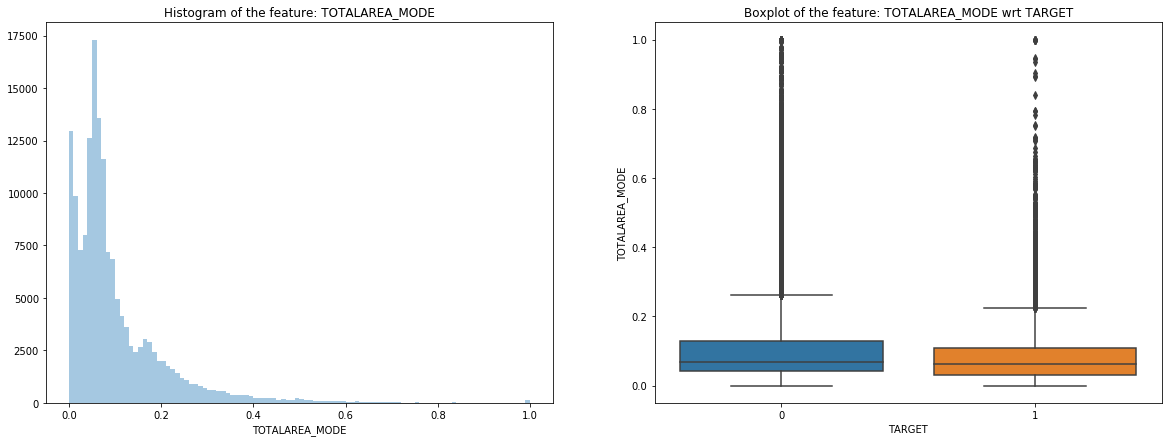

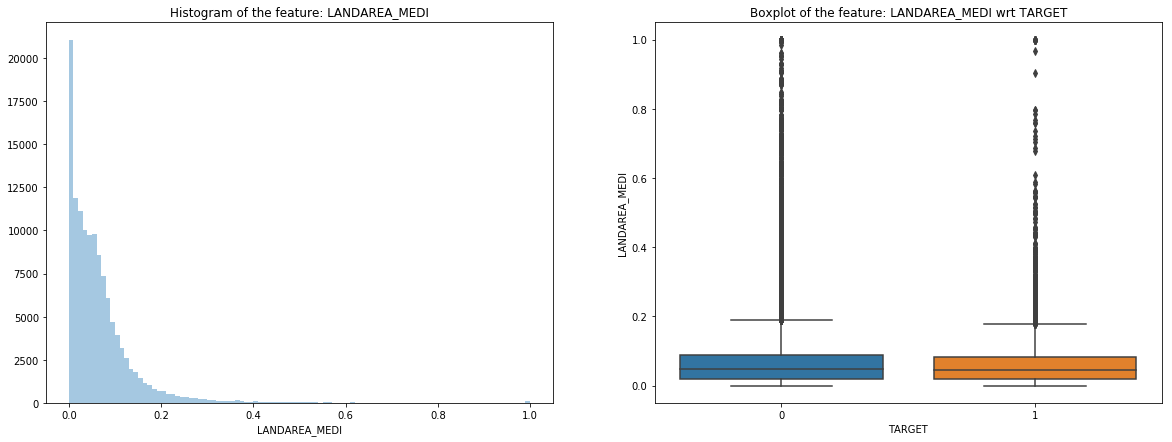

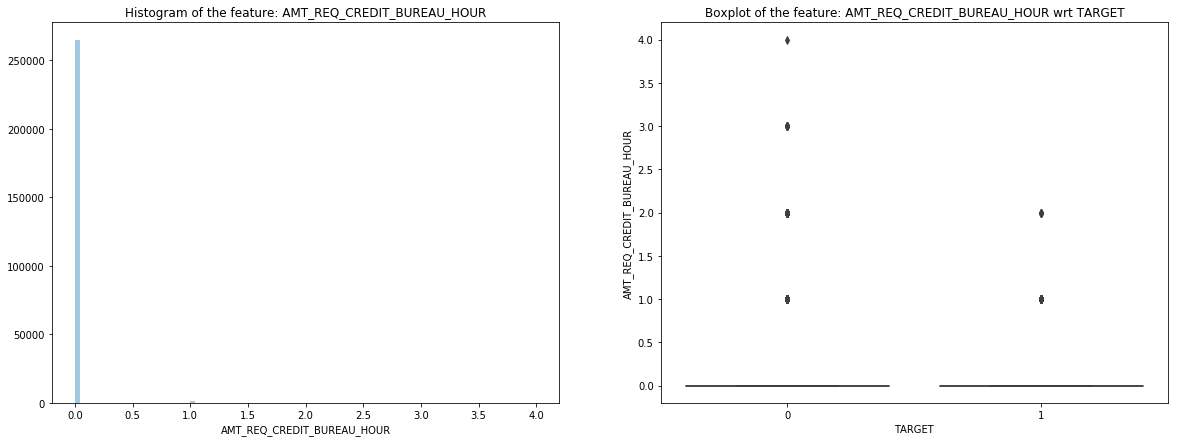

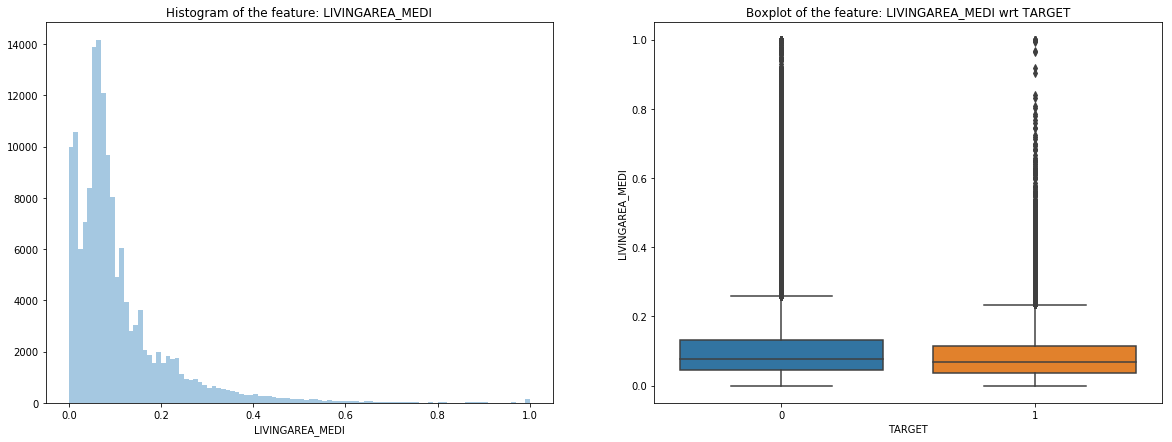

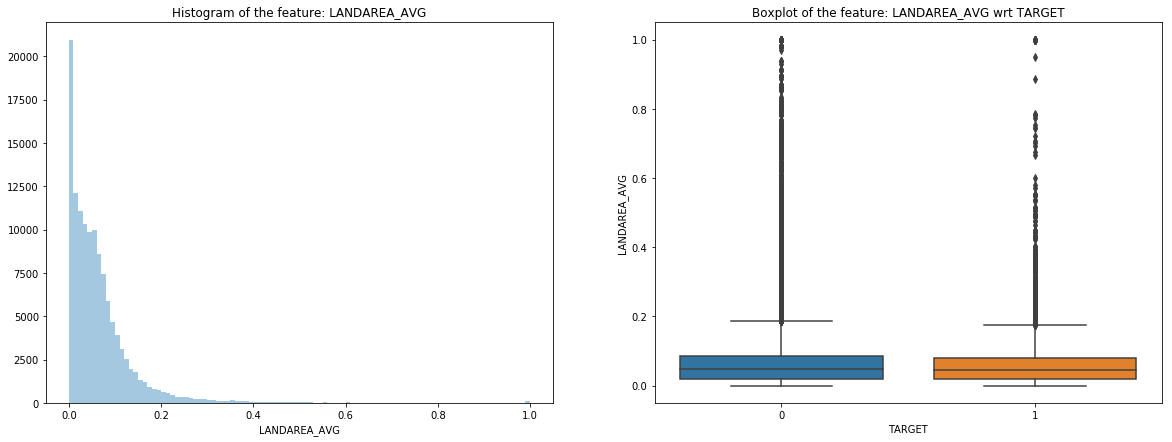

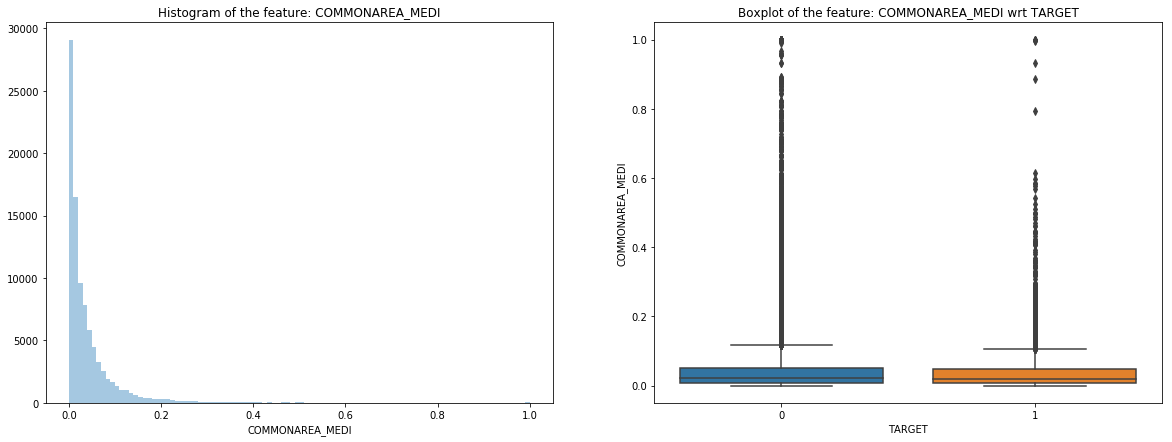

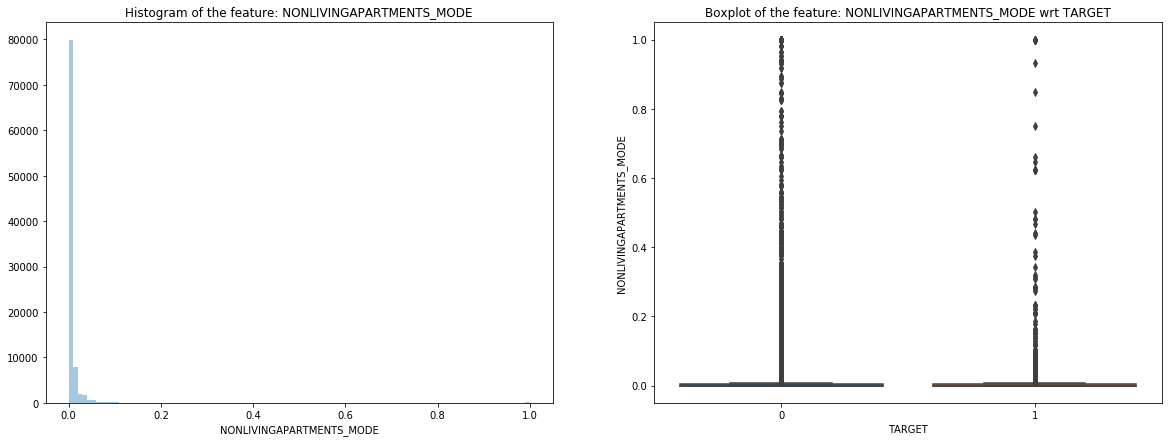

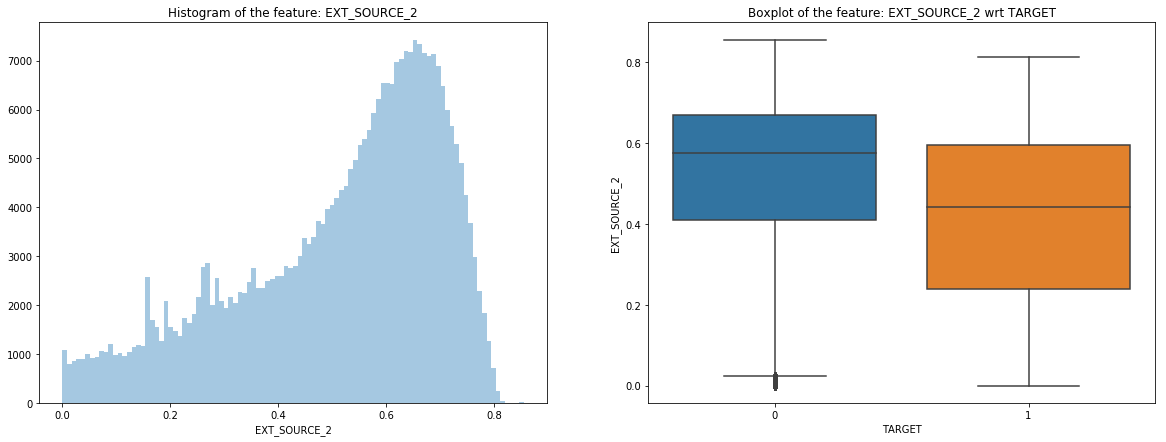

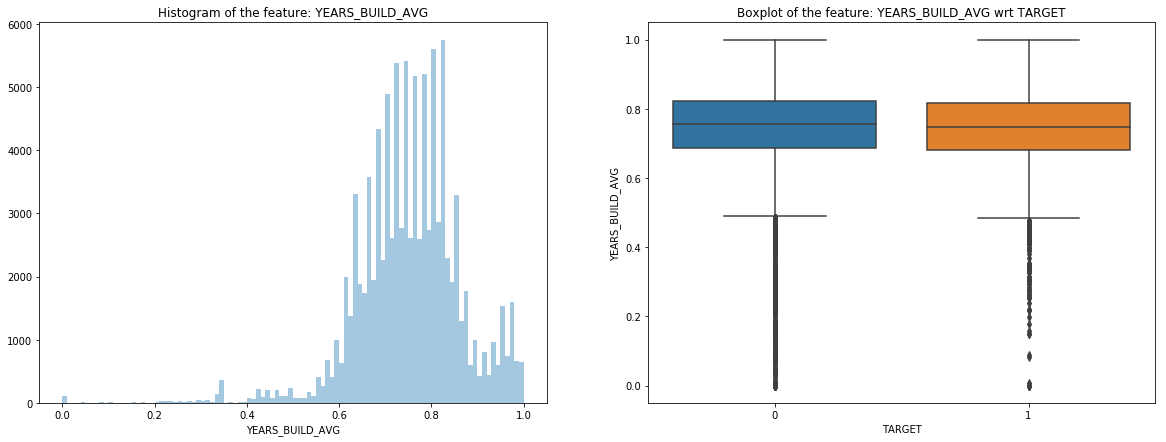

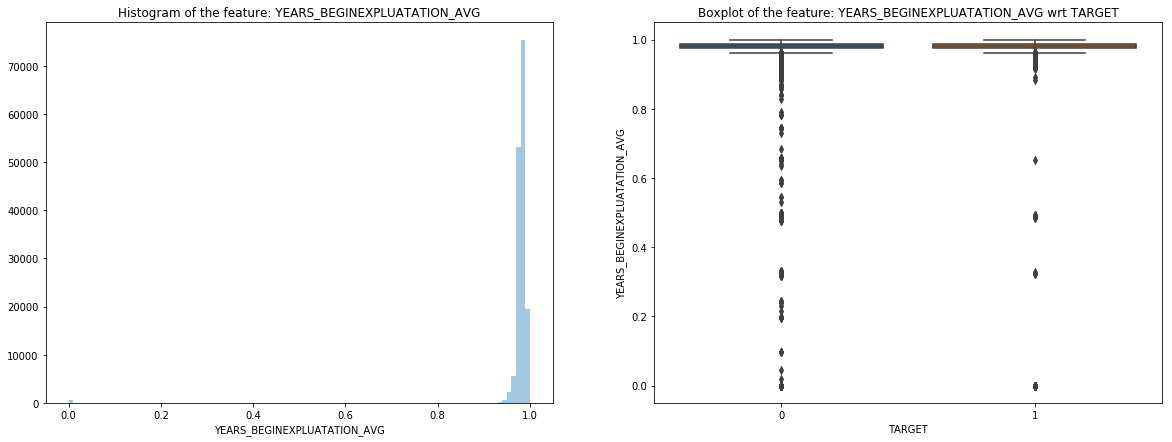

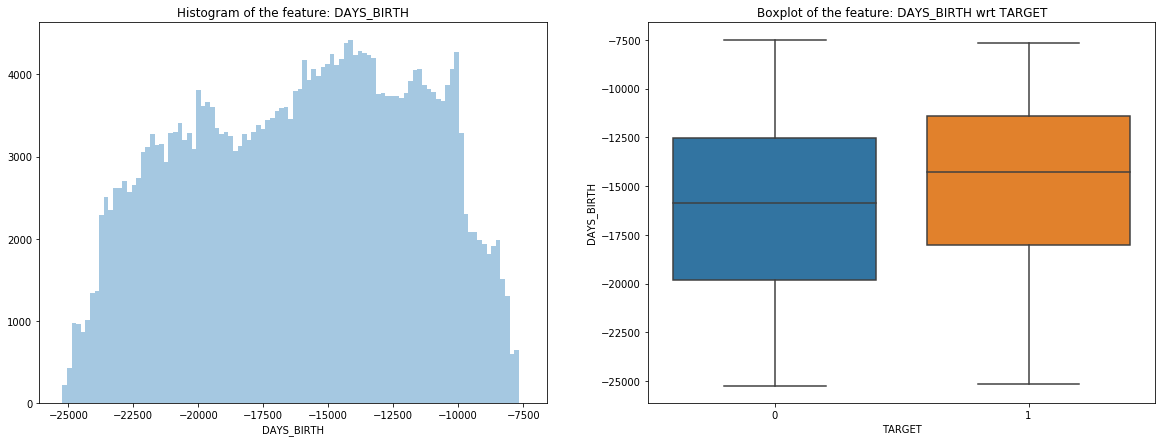

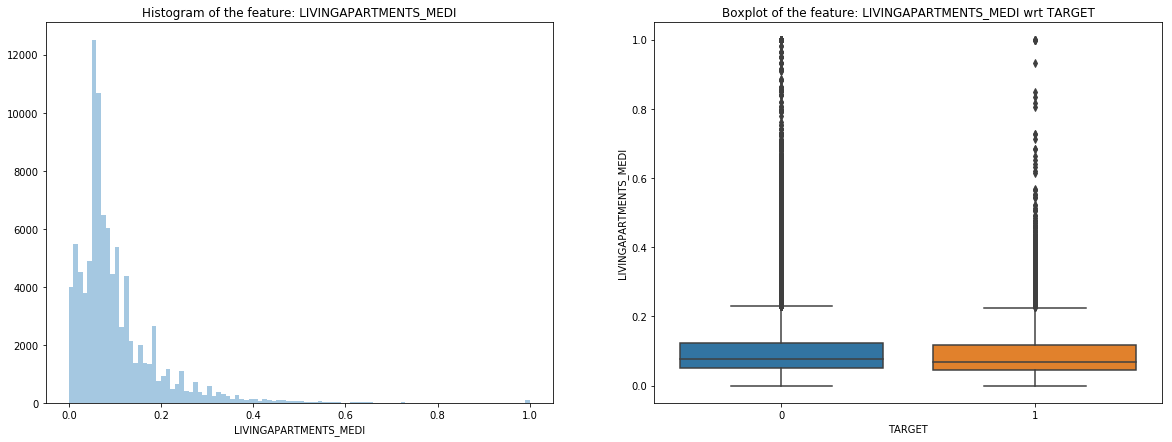

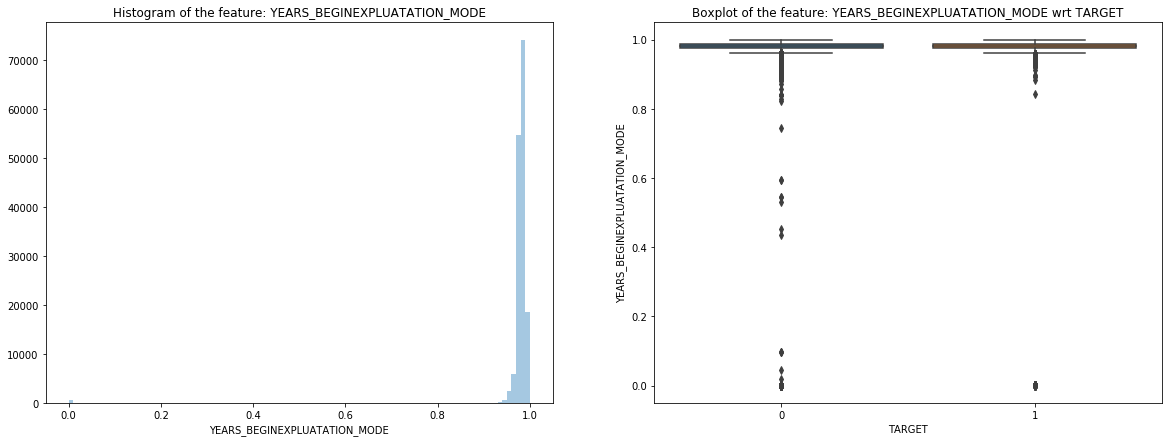

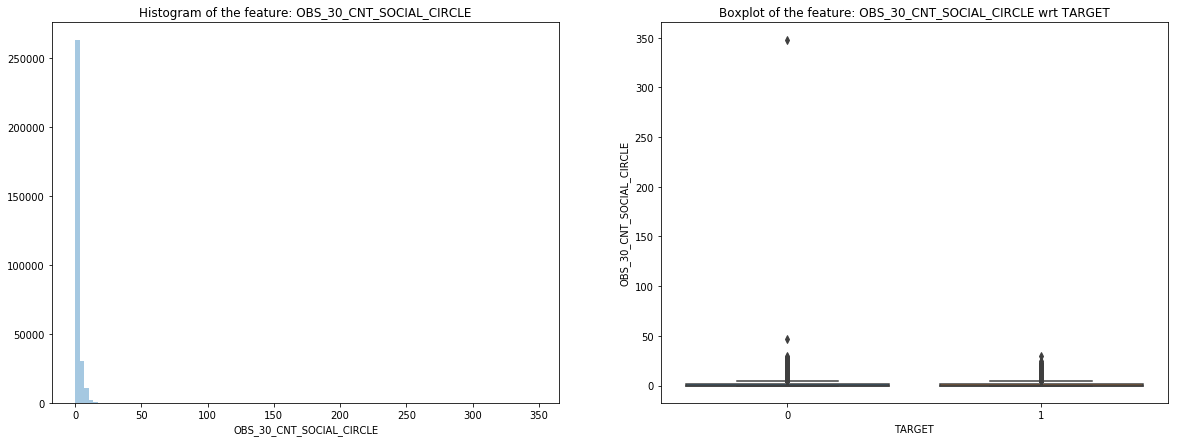

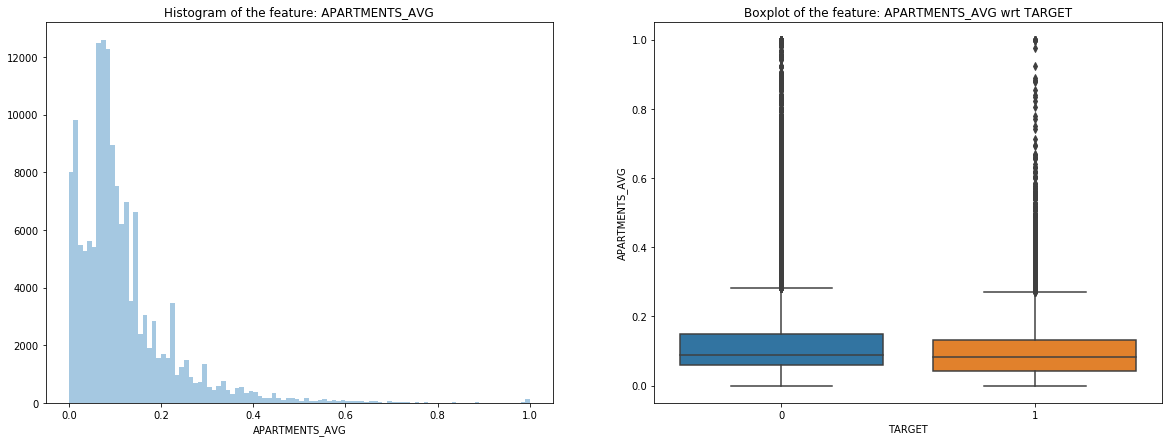

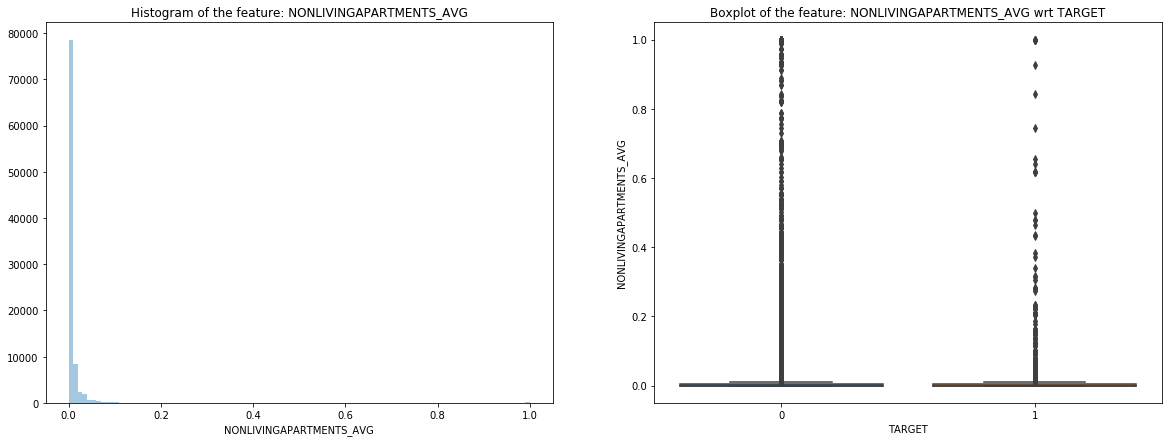

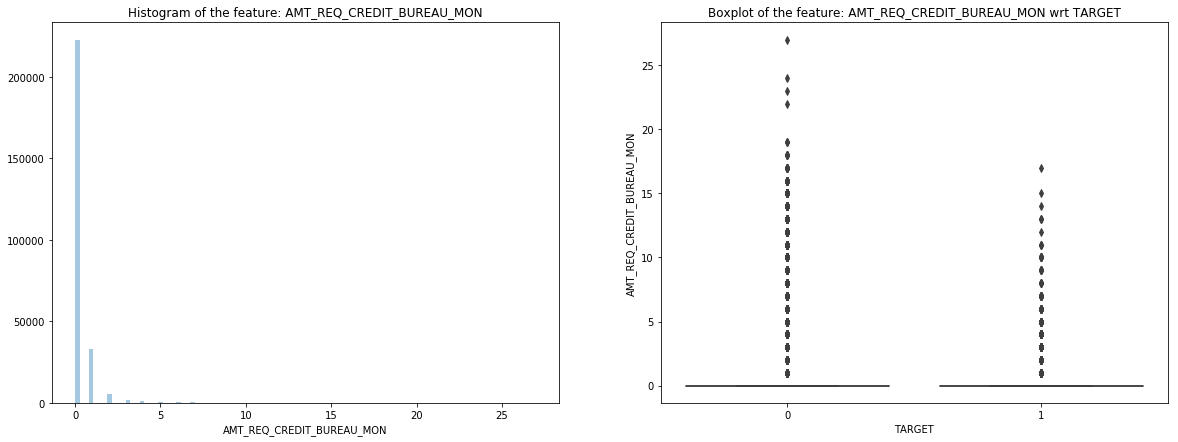

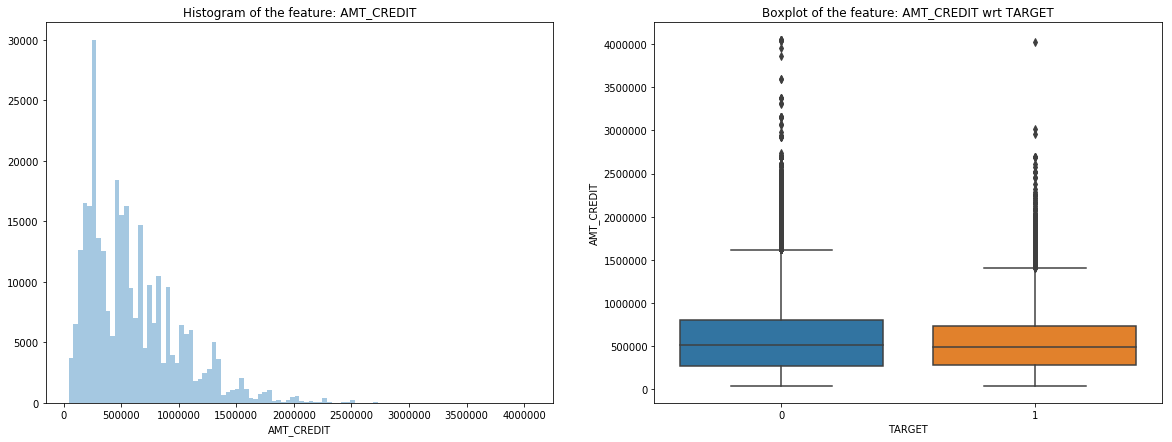

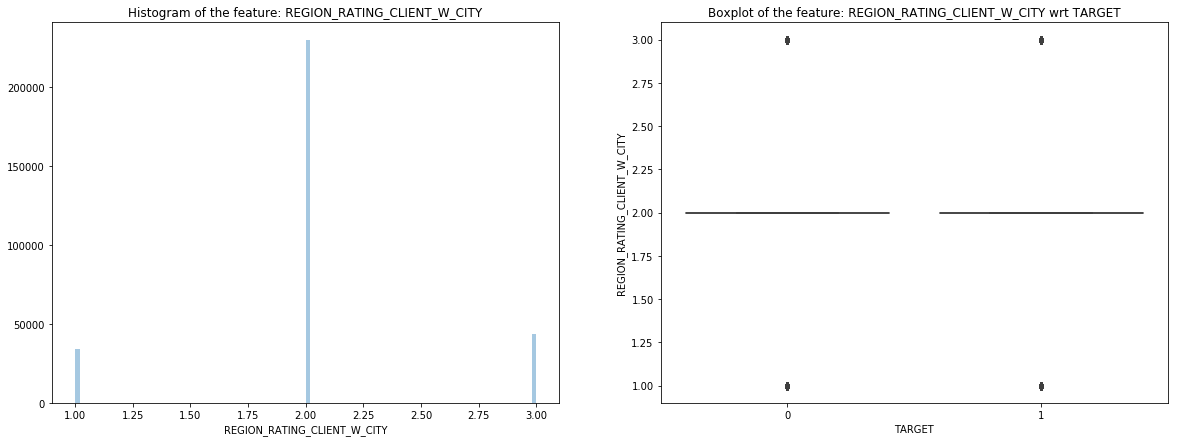

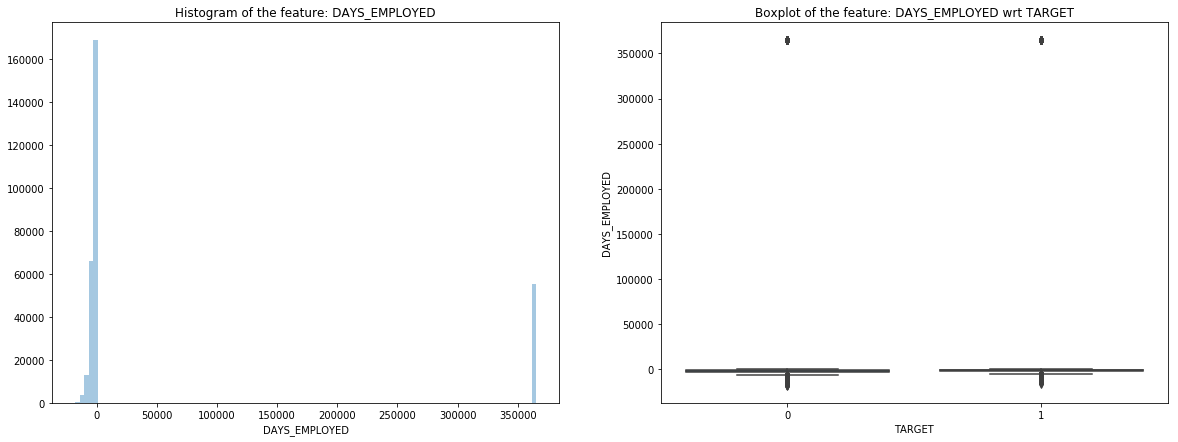

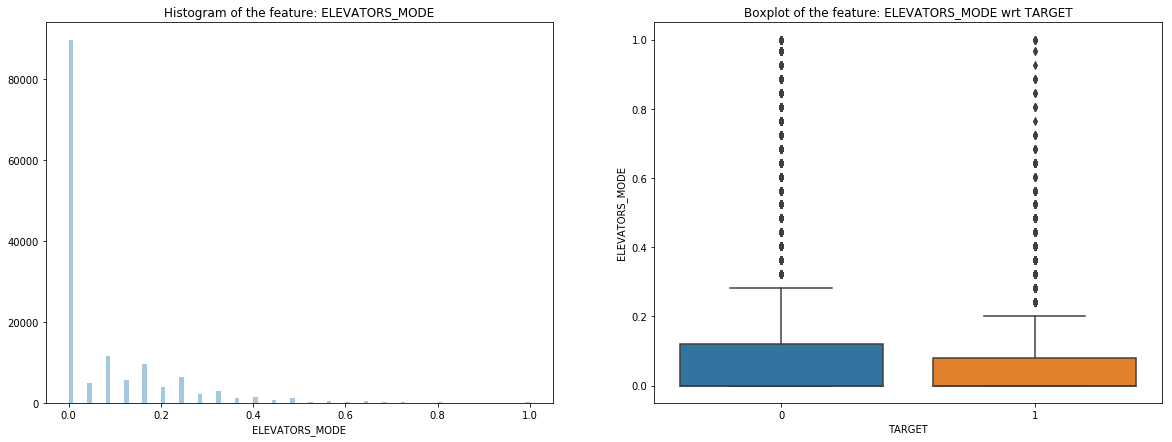

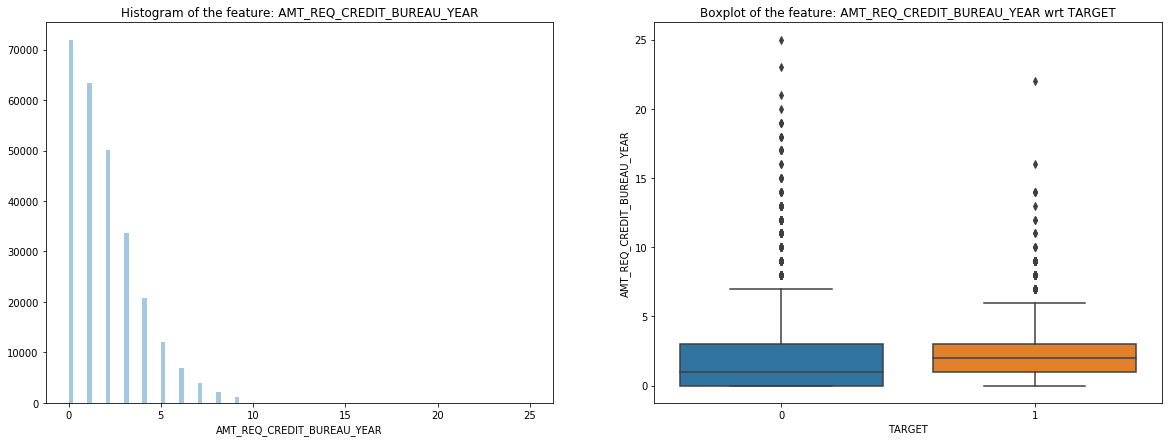

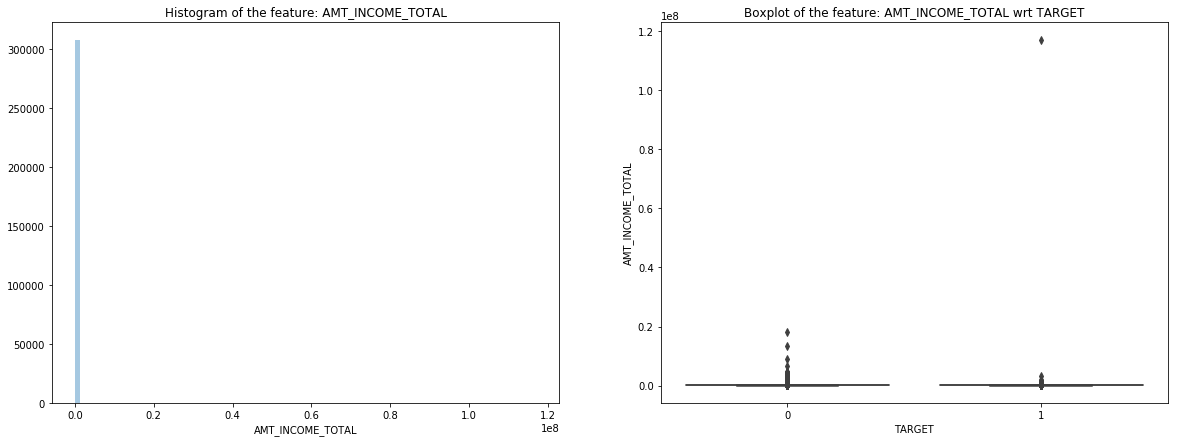

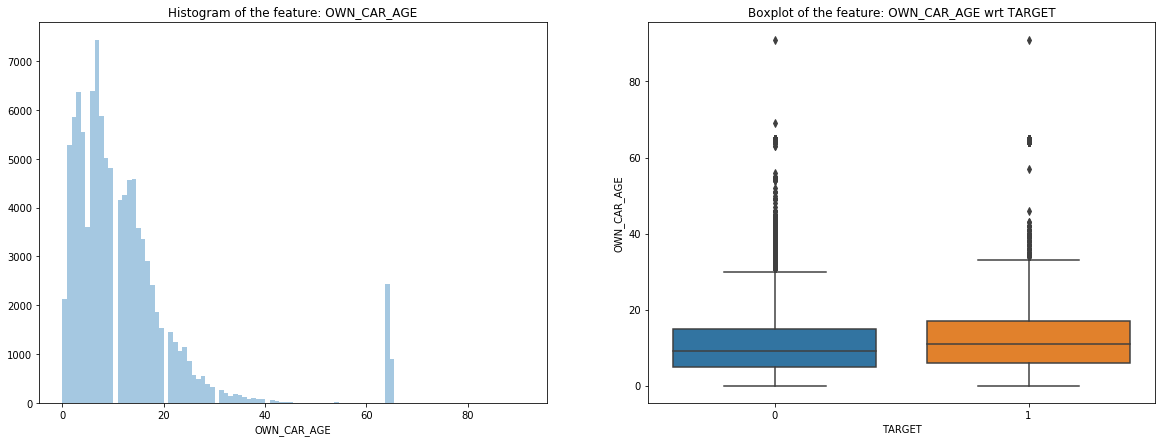

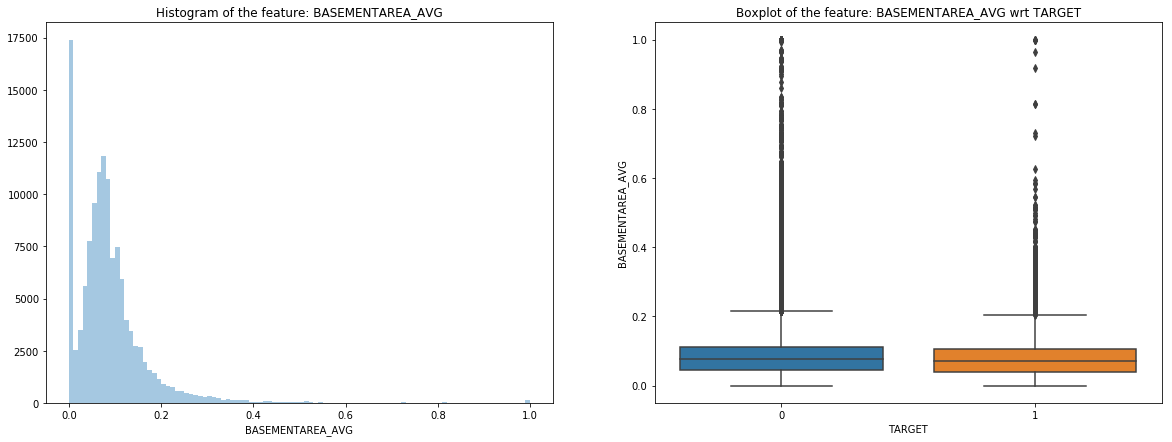

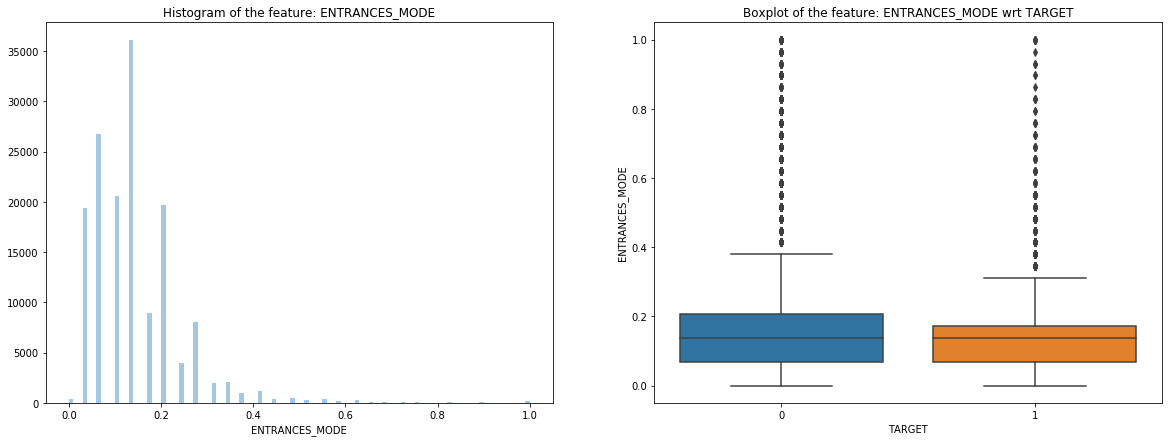

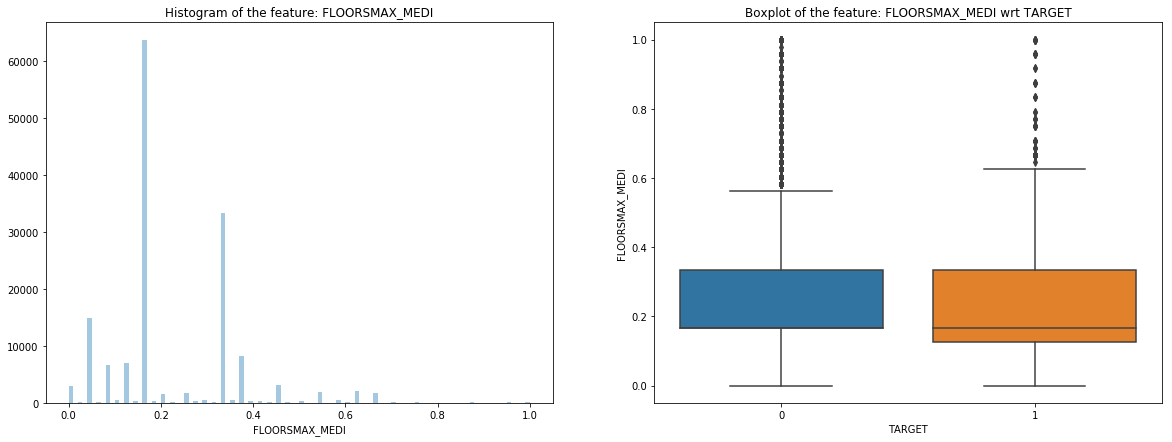

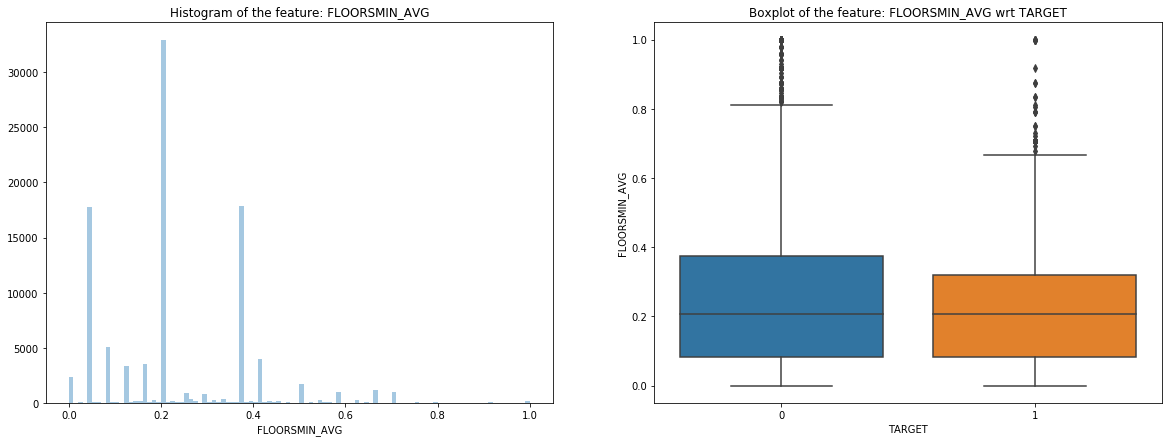

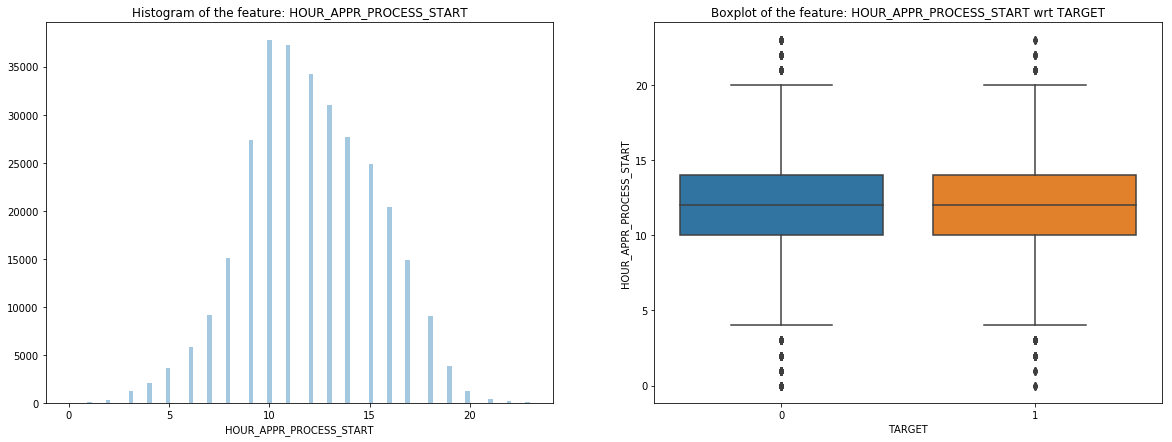

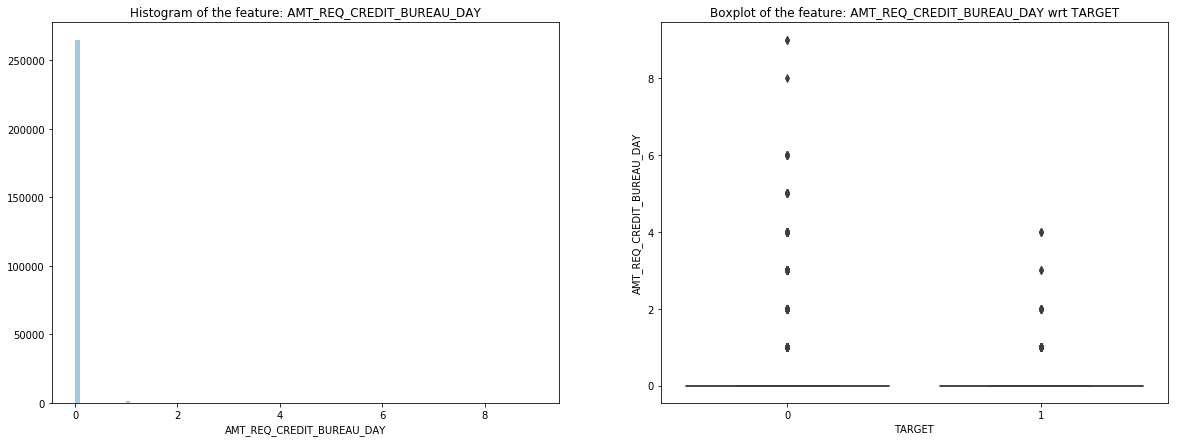

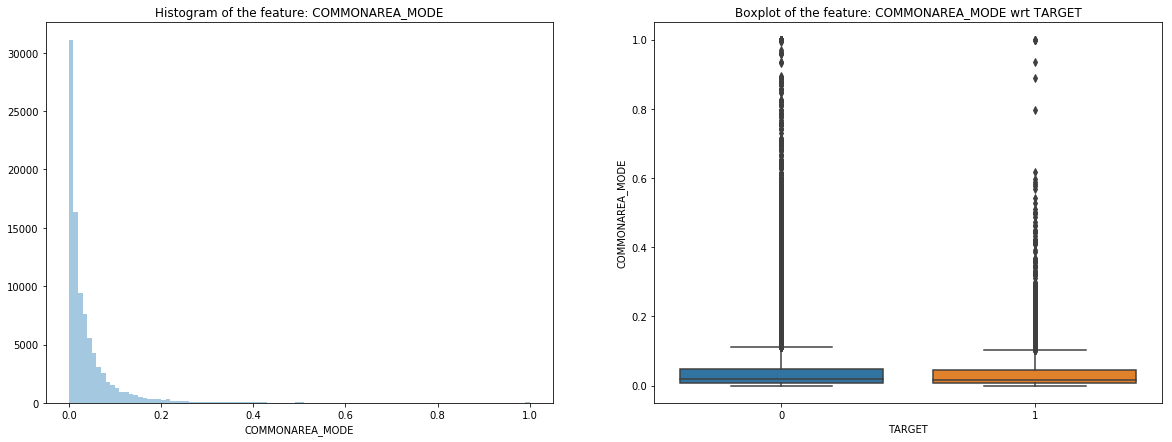

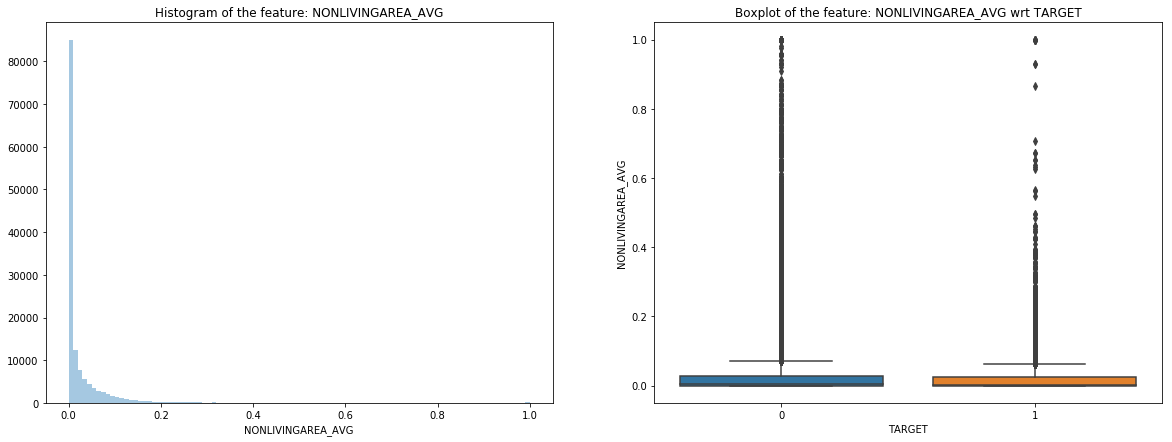

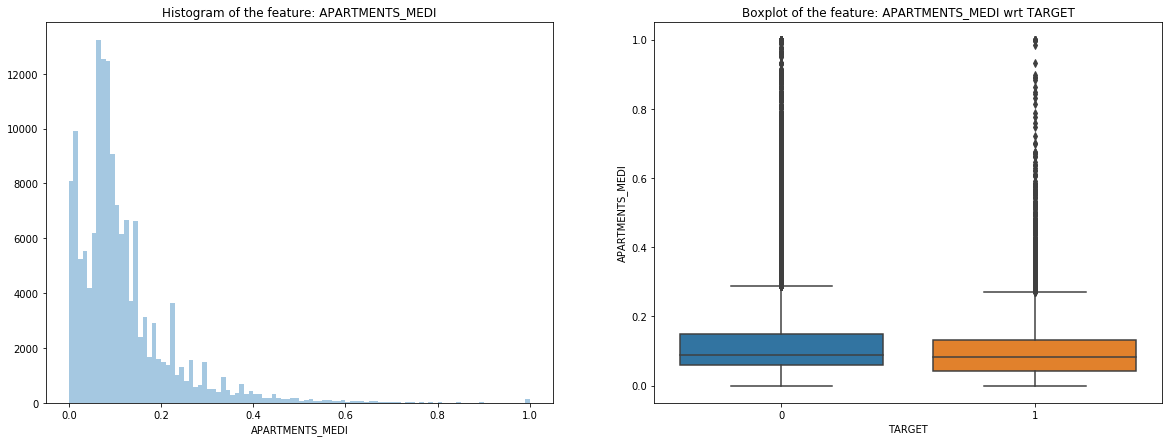

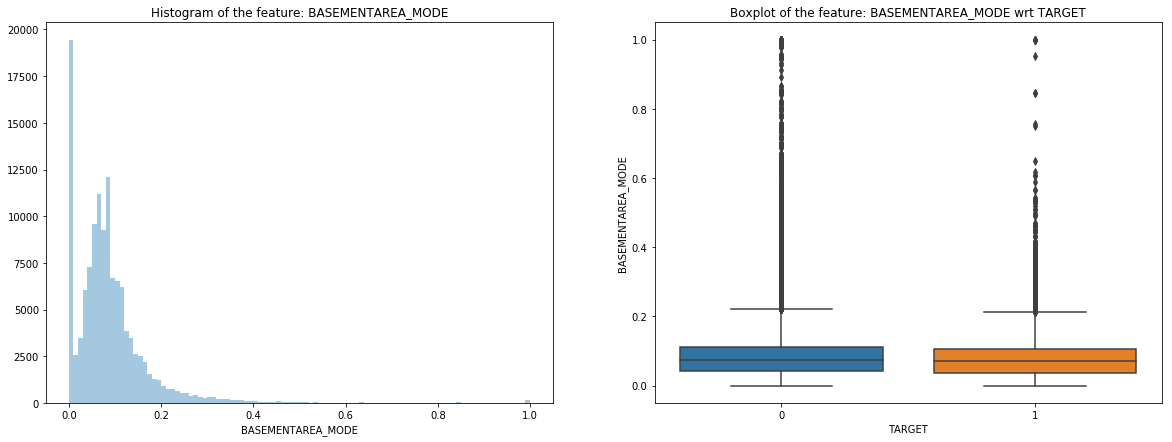

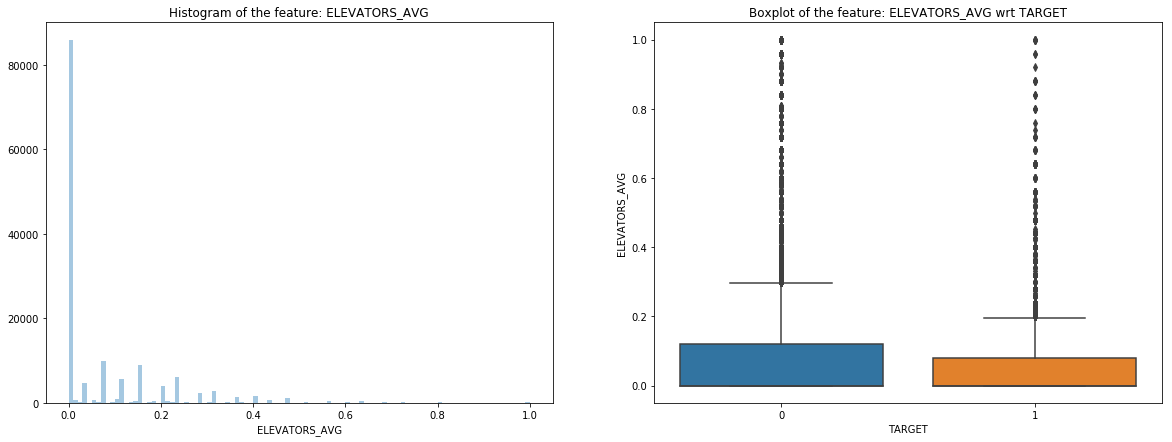

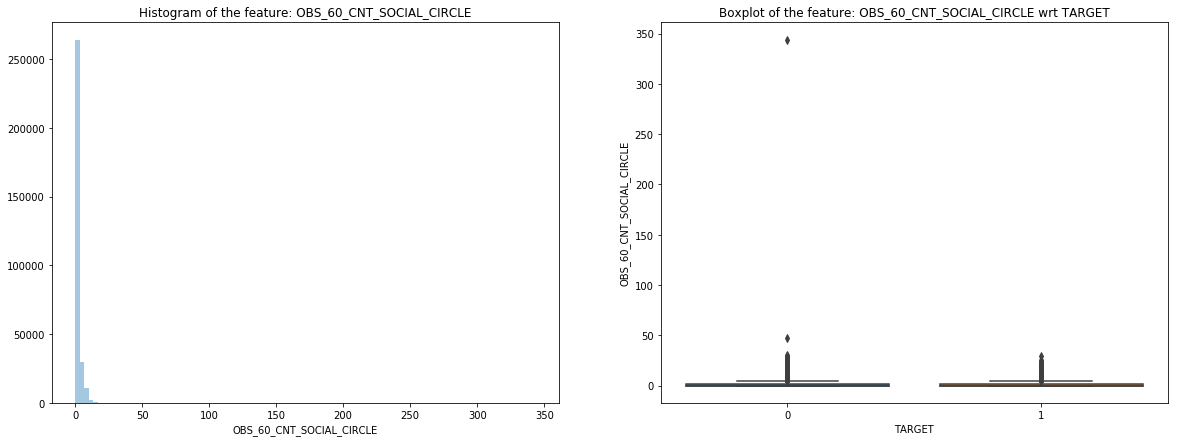

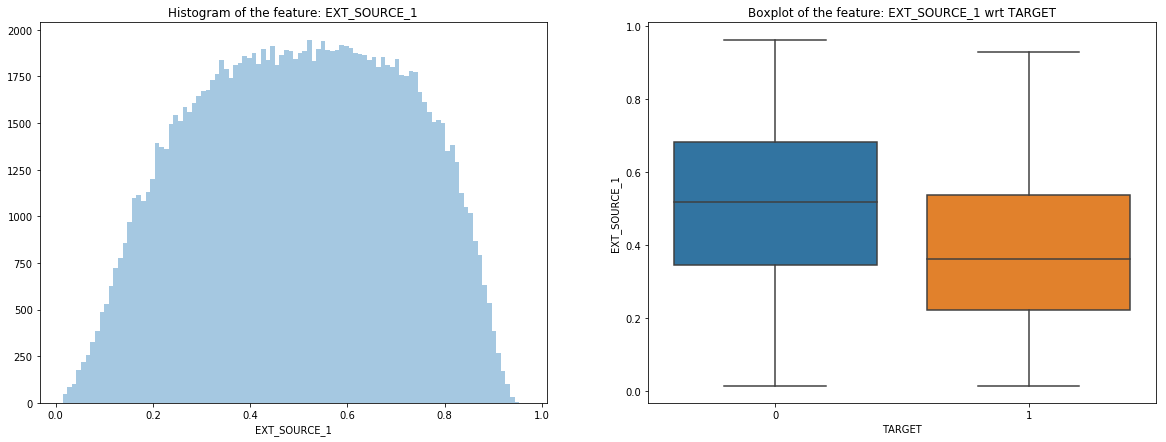

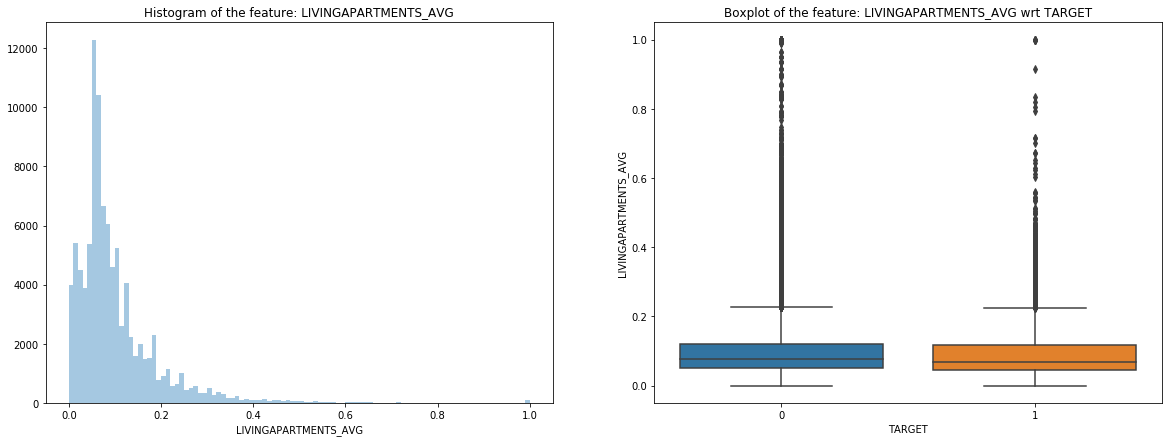

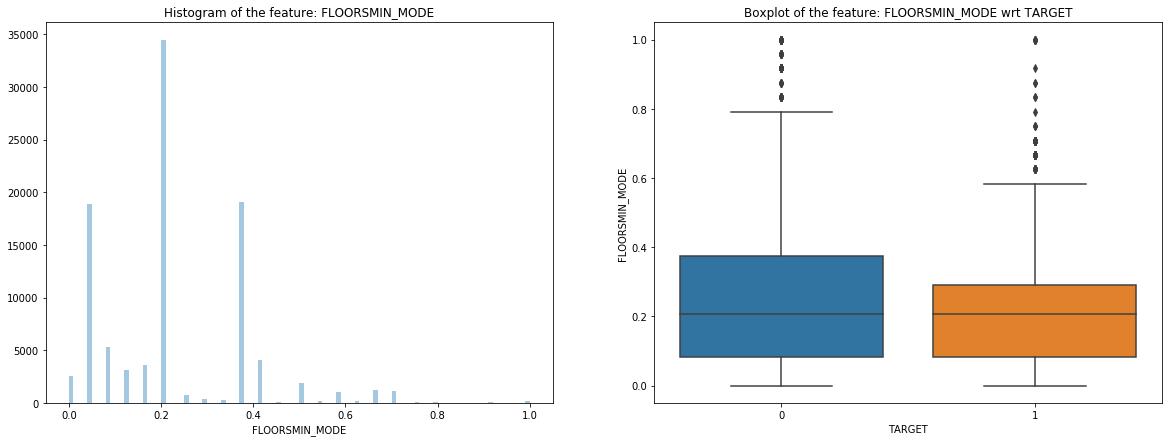

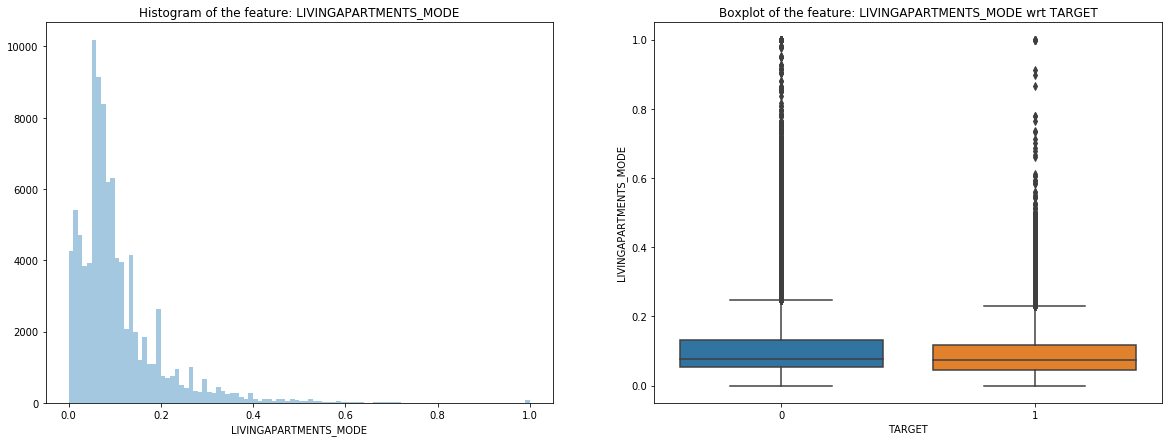

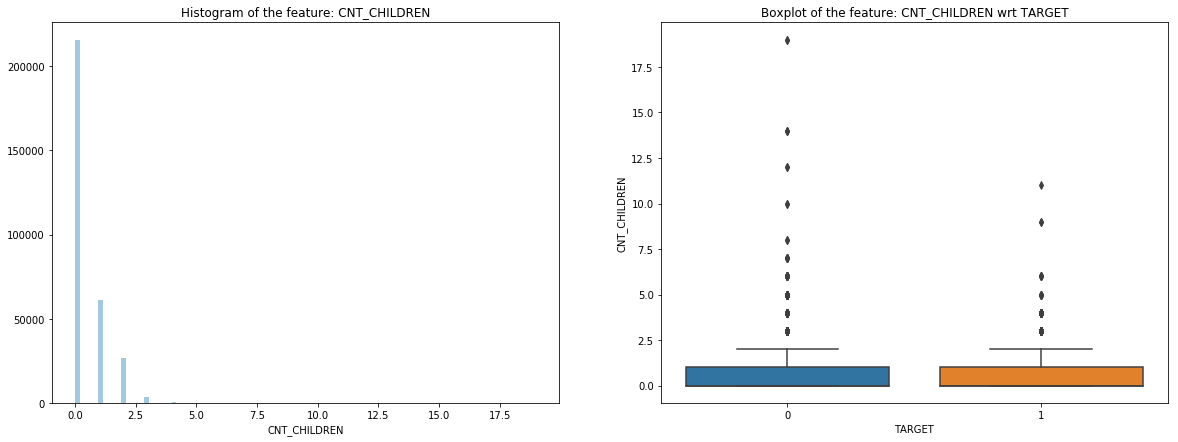

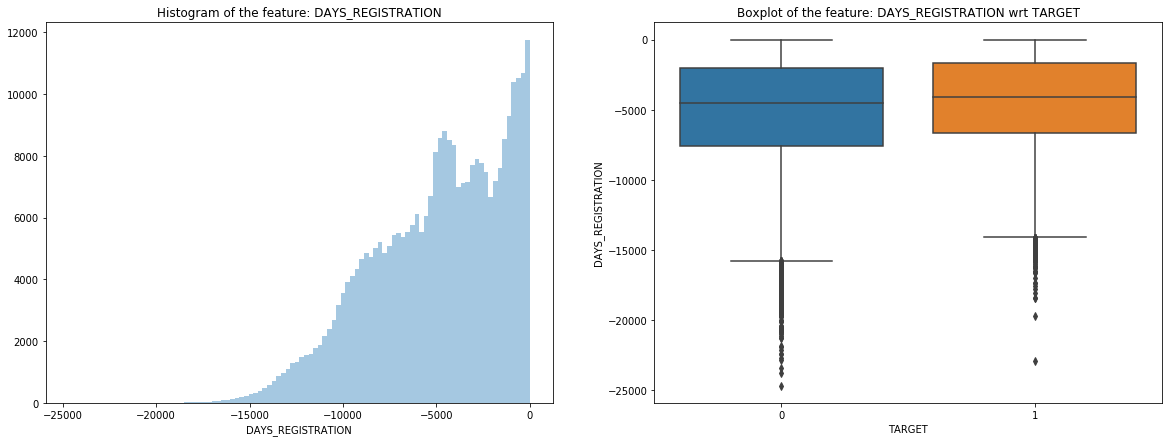

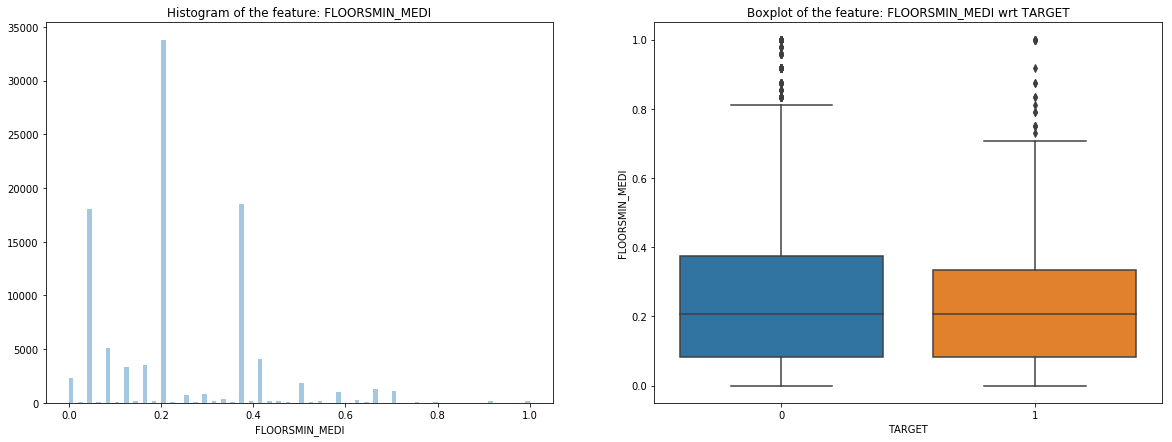

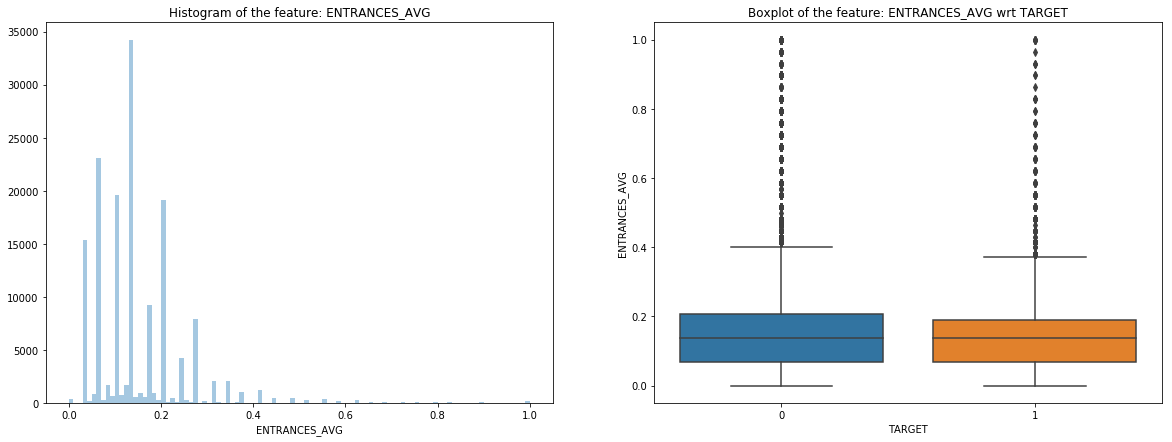

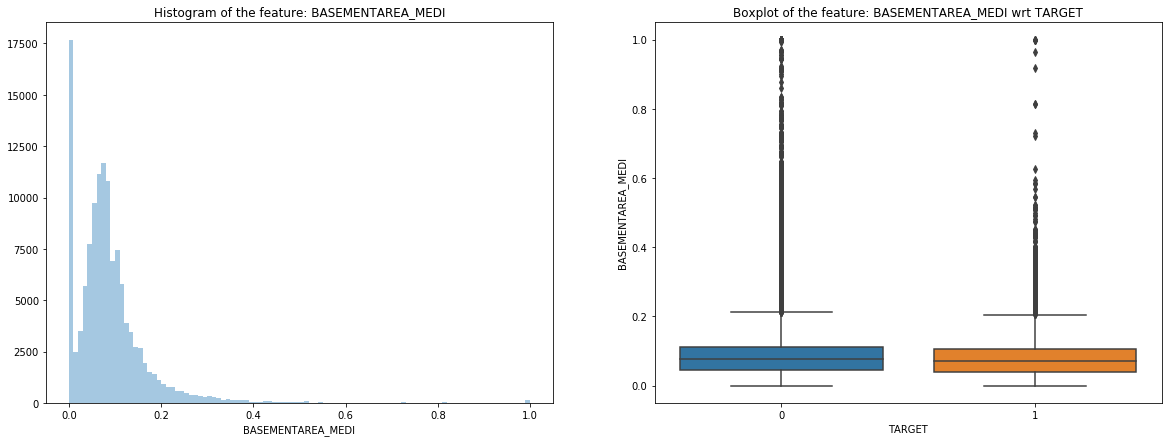

In [9]:
for feature in numerical_features_lst:
    fig, ax = plt.subplots(1, 2, sharex = False, sharey = False, figsize = (20, 7))
    
    # Plot feature distribution
    plot_df = training_set_df[[feature, "TARGET"]].dropna()
    sns.distplot(plot_df[feature], kde = False, bins = 100, ax = ax[0])
    ax[0].set_title("Histogram of the feature: " + feature)

    # Plot feature against target
    sns.boxplot(x = training_set_df["TARGET"], y = training_set_df[feature], ax = ax[1])
    ax[1].set_title("Boxplot of the feature: " + feature + " wrt TARGET")

From the plots above, we can see the following:
 - There are outliers in the data: some clients are employed since a negative number of days. Some clients can have an income greater than \$100M
 - Some numerical are actually categorical features. For instance, it's the case for *FLOORSMAX_AVG*. Denormalizing those features maybe can add some value to the data.
 - Lots of features have an important skewness. Dealing with this can improve performances.
 
### 3.3. Looking at missing values from application_train.csv

Now, let's look at missing values distribution in the data.

Text(0.5,1,'Percentage of missing values in the application data')

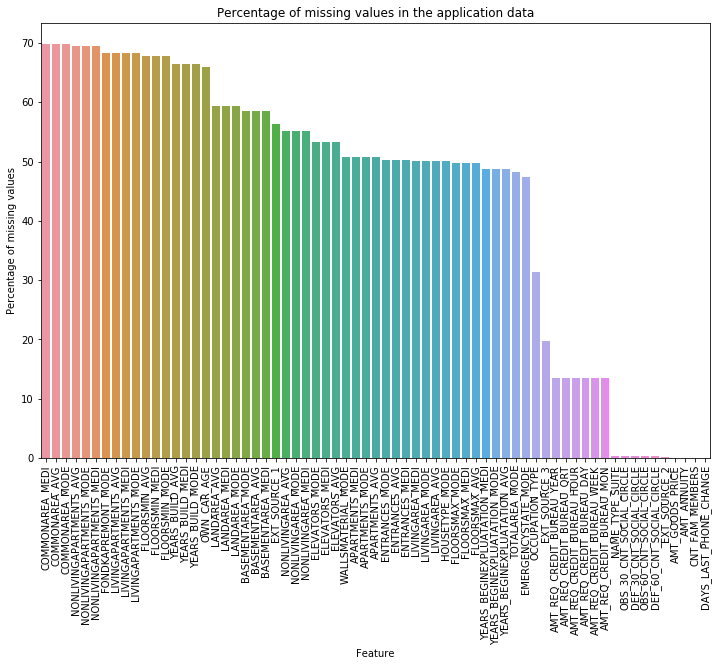

In [10]:
missing_values_sr = training_set_df.isnull().sum()
missing_values_df = missing_values_sr.loc[missing_values_sr > 0].sort_values(ascending = False).reset_index()
missing_values_df.columns = ["Feature", "Number of missing values"]
missing_values_df["Percentage of missing values"] = (missing_values_df["Number of missing values"] / training_set_df.shape[0]) * 100

sns.barplot(x = missing_values_df["Feature"], y = missing_values_df["Percentage of missing values"])
plt.xticks(rotation = 90)
plt.title("Percentage of missing values in the application data")

Here, we can see that some features have a lot of missing values (near 70%). It will be interesting to know if number of missing value for each client have an impact on the performances of the predictive model.

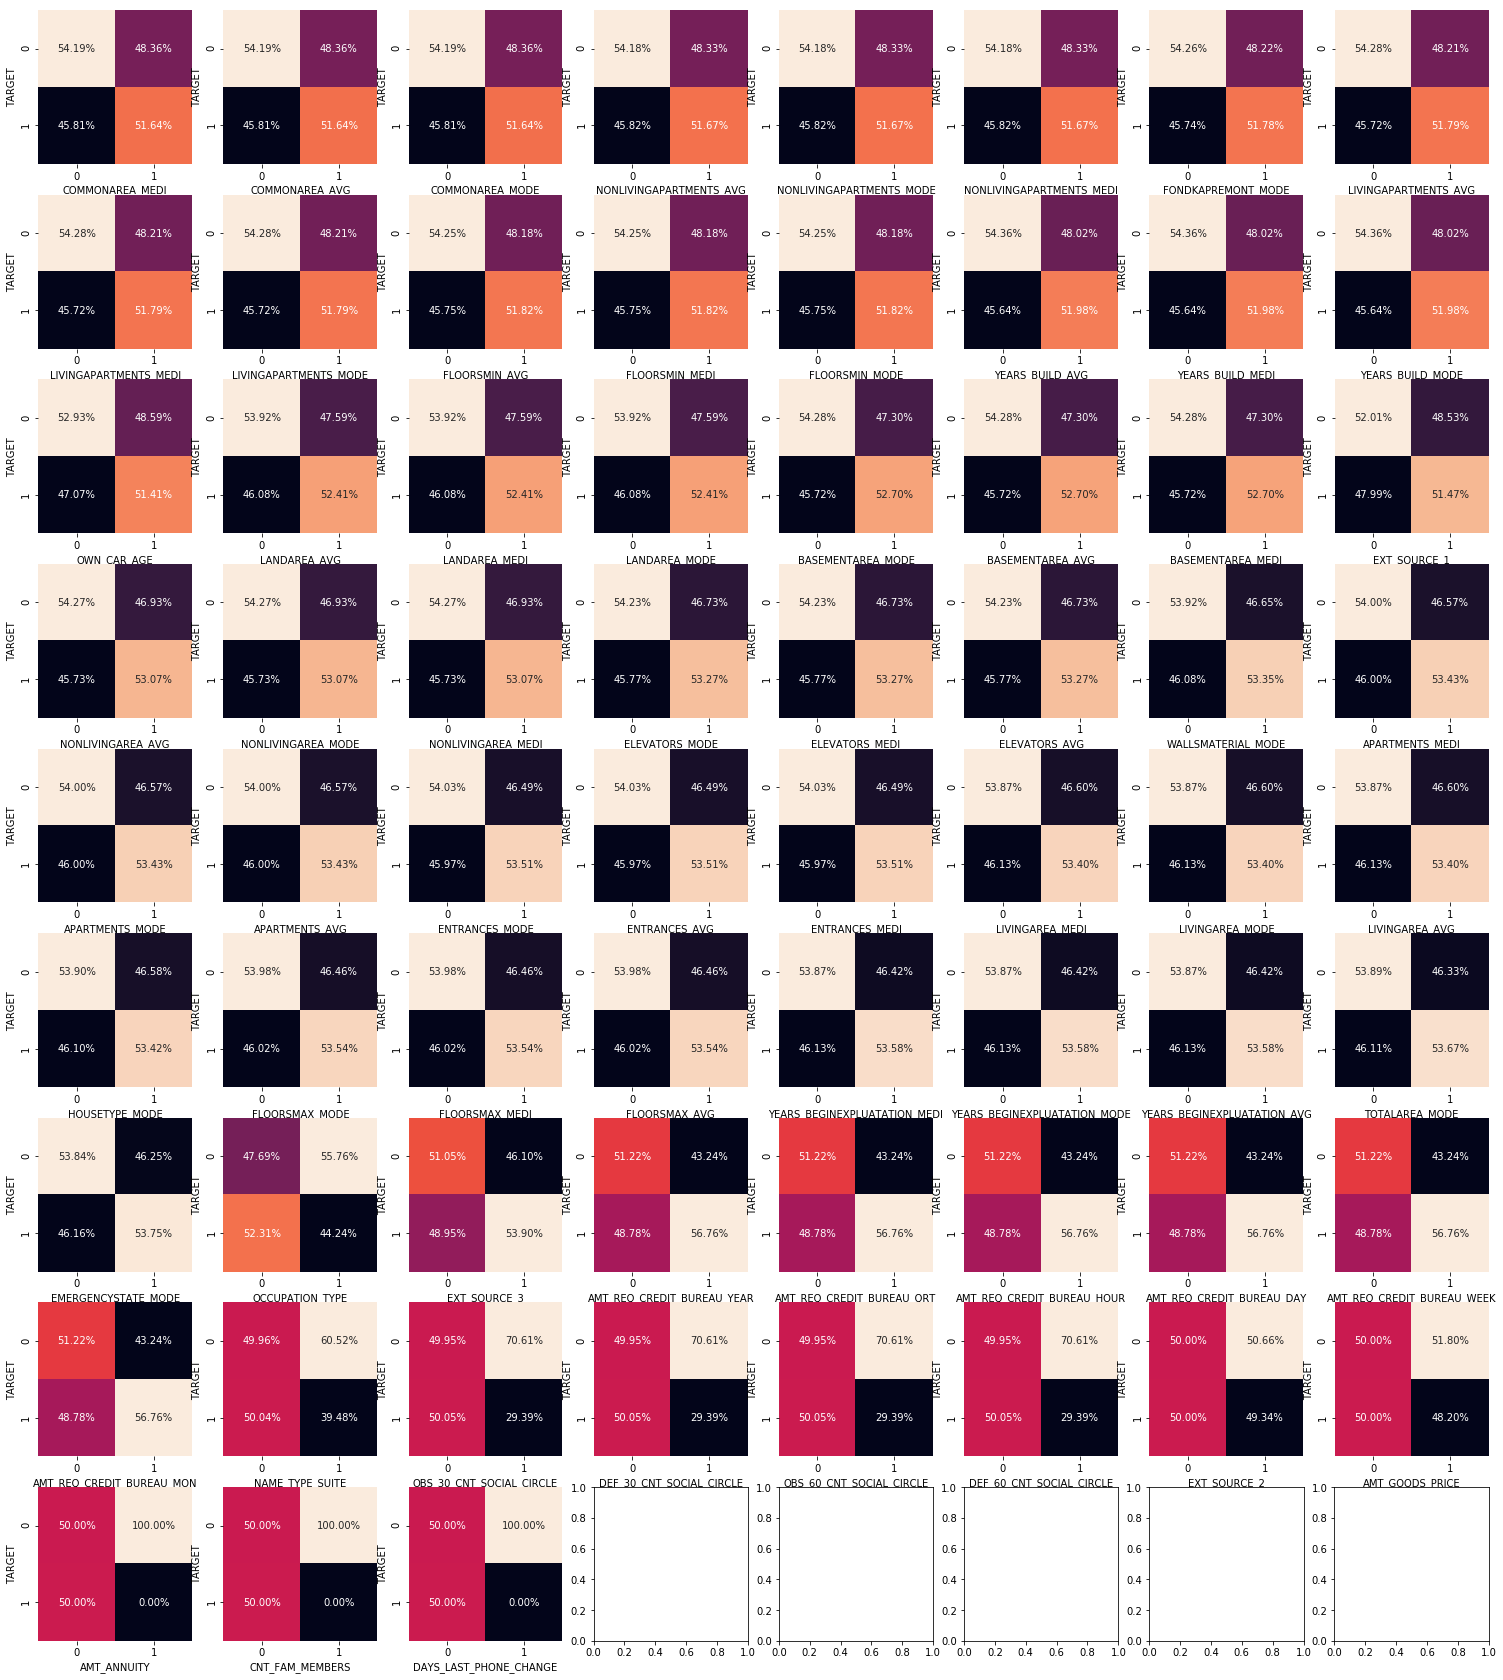

In [11]:
is_missing_df = training_set_df.isnull().astype(np.int8)
is_missing_df = is_missing_df[missing_values_df["Feature"]]

fig, ax = plt.subplots(9, 8, sharex = False, sharey = False, figsize = (26, 30))
i = 0
j = 0
for idx in range(len(missing_values_df["Feature"])):
    if idx % 8 == 0 and idx != 0:
        j += 1
        
    i = idx % 8
    feature = is_missing_df.columns.tolist()[idx]
    table_df = pd.crosstab(training_set_df["TARGET"], is_missing_df[feature], normalize = True)
    # Normalize statistics to remove target unbalance
    table_df = table_df.div(table_df.sum(axis = 1), axis = 0)
    table_df = table_df.div(table_df.sum(axis = 0), axis = 1)
    sns.heatmap(table_df, annot = True, square = True, ax = ax[j, i], cbar = False, fmt = '.2%')

Interesting: we can see that when *AMT_ANNUITY*, *CNT_FAM_MEMBERS* and *DAYS_LAST_PHONE_CHANGE* are missing, then the target is always 0. They can be interesting features to add to our model.

### 3.4. Looking at bureau.csv and bureau_balance.csv

Now, let's explore those two additional files. Let's begin by merging them into a single data frame.

In [12]:
merged_df = bureau_data_df.merge(bureau_balance_data_df, how = "left", on = "SK_ID_BUREAU")
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25121815 entries, 0 to 25121814
Data columns (total 19 columns):
SK_ID_CURR                int32
SK_ID_BUREAU              int32
CREDIT_ACTIVE             object
CREDIT_CURRENCY           object
DAYS_CREDIT               int16
CREDIT_DAY_OVERDUE        int16
DAYS_CREDIT_ENDDATE       float32
DAYS_ENDDATE_FACT         float32
AMT_CREDIT_MAX_OVERDUE    float32
CNT_CREDIT_PROLONG        int8
AMT_CREDIT_SUM            float32
AMT_CREDIT_SUM_DEBT       float32
AMT_CREDIT_SUM_LIMIT      float32
AMT_CREDIT_SUM_OVERDUE    float32
CREDIT_TYPE               object
DAYS_CREDIT_UPDATE        int32
AMT_ANNUITY               float32
MONTHS_BALANCE            float64
STATUS                    object
dtypes: float32(8), float64(1), int16(2), int32(3), int8(1), object(4)
memory usage: 2.3+ GB


Now, we'll look at categorical features inside this dataset.

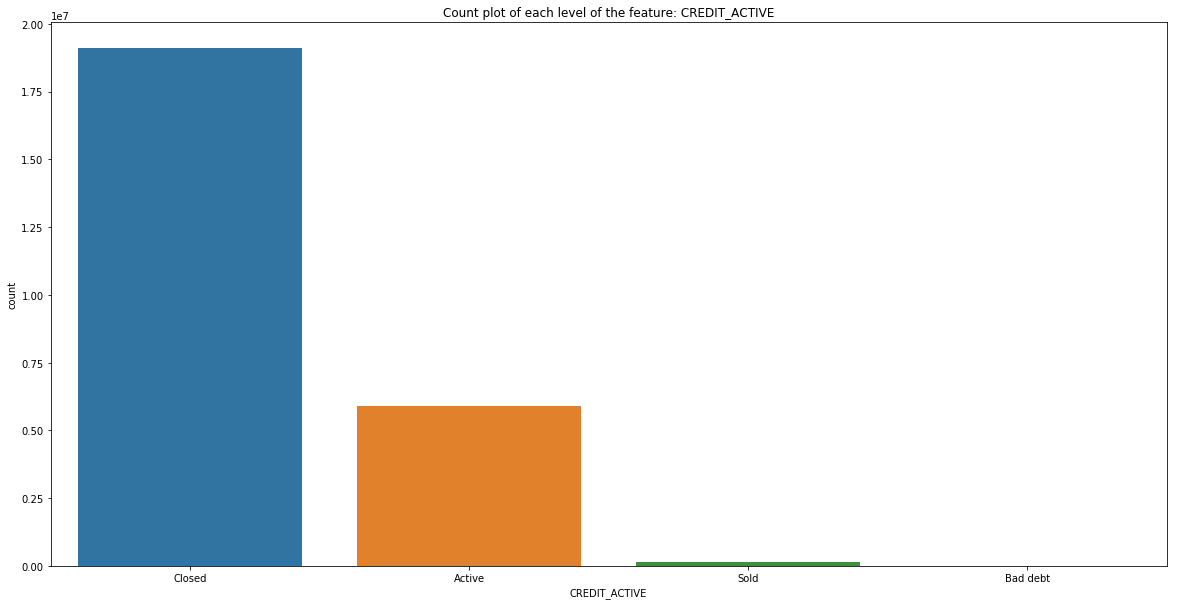

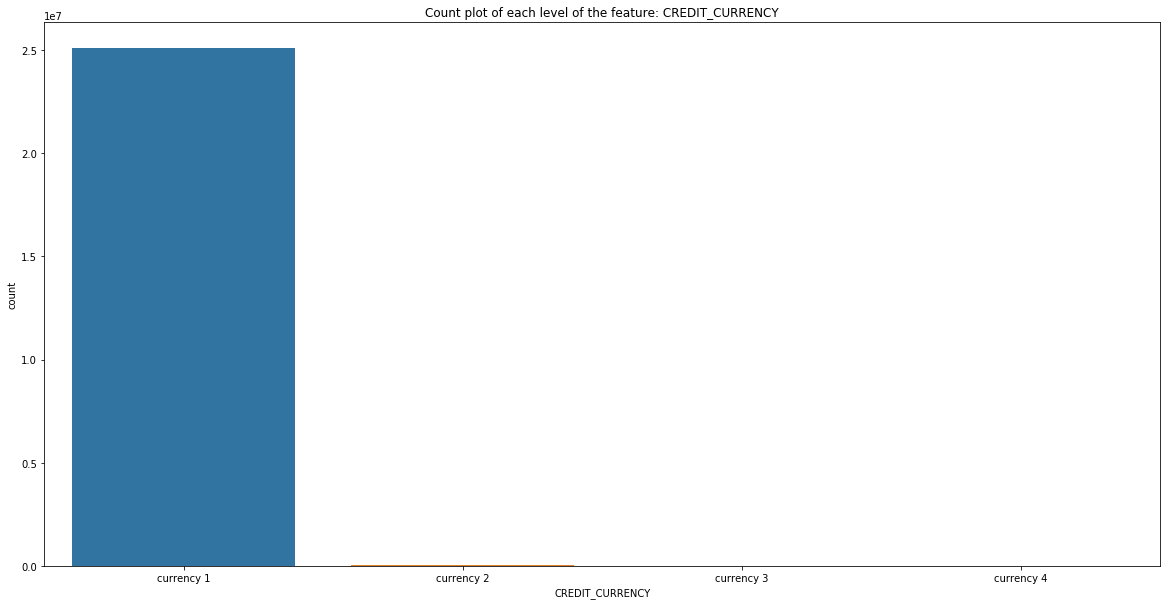

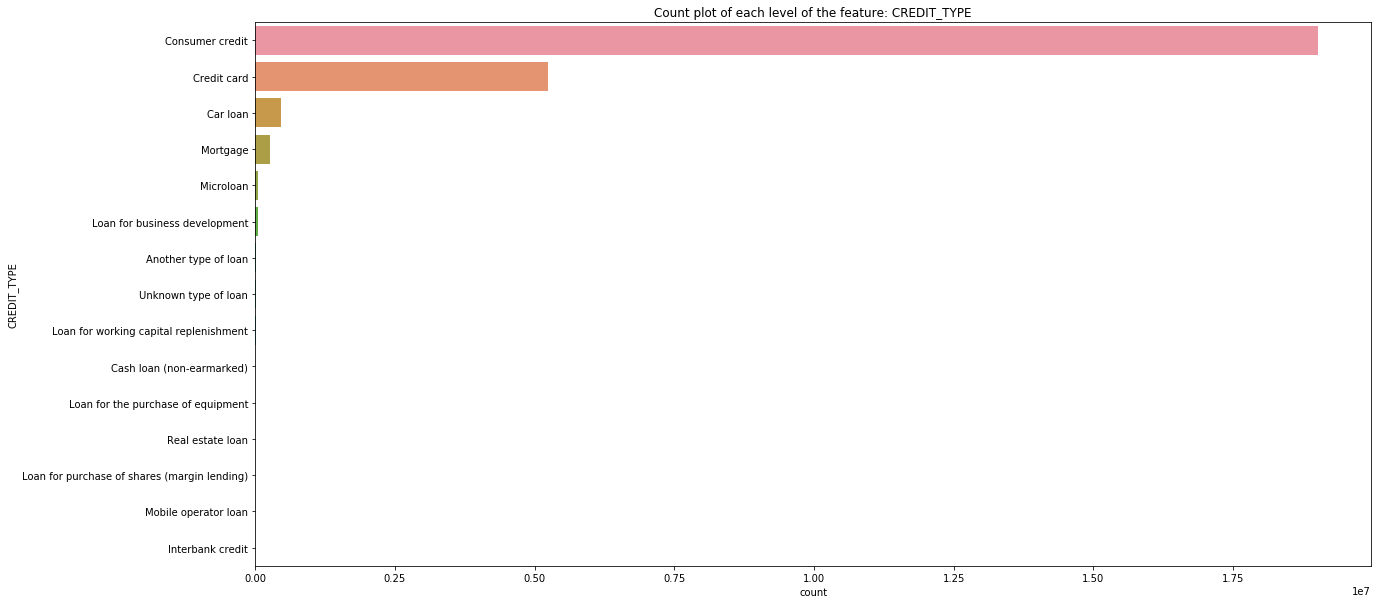

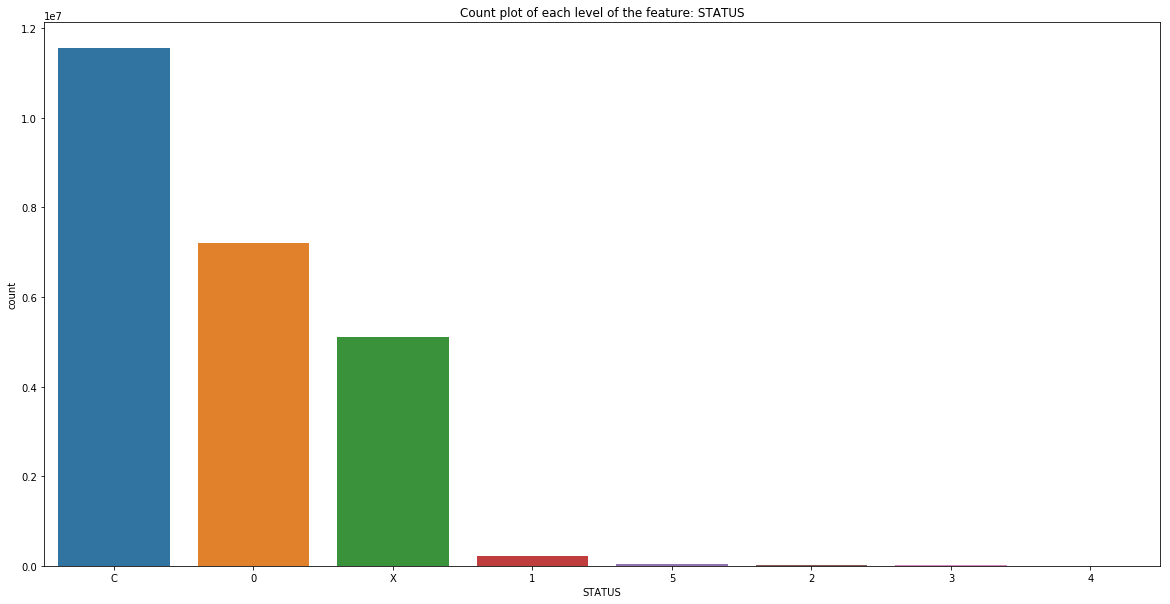

In [13]:
categorical_features_lst = merged_df.select_dtypes(["object"]).columns.tolist()

for feature in categorical_features_lst:
    fig, ax = plt.subplots(1, 1, sharex = False, sharey = False, figsize = (20, 10))
    # Plot levels distribution
    if merged_df[feature].nunique() < 10:
        sns.countplot(x = merged_df[feature], ax = ax, order = merged_df[feature].value_counts().index.tolist())
    else:
        sns.countplot(y = merged_df[feature], ax = ax, order = merged_df[feature].value_counts().index.tolist())
    ax.set_title("Count plot of each level of the feature: " + feature)

From the plots above, we can see that the majority of credits are either closed or active.
One currency dominates all credits. Maybe its USD.
The majority of loans are consumer credits or credit card. Then car loans and mortgage loans come after.
The last plot shows us the status of Credit Bureau loan during the month. This feature seems similar to *CREDIT_ACTIVE*.

Now, let's look at numerical features.

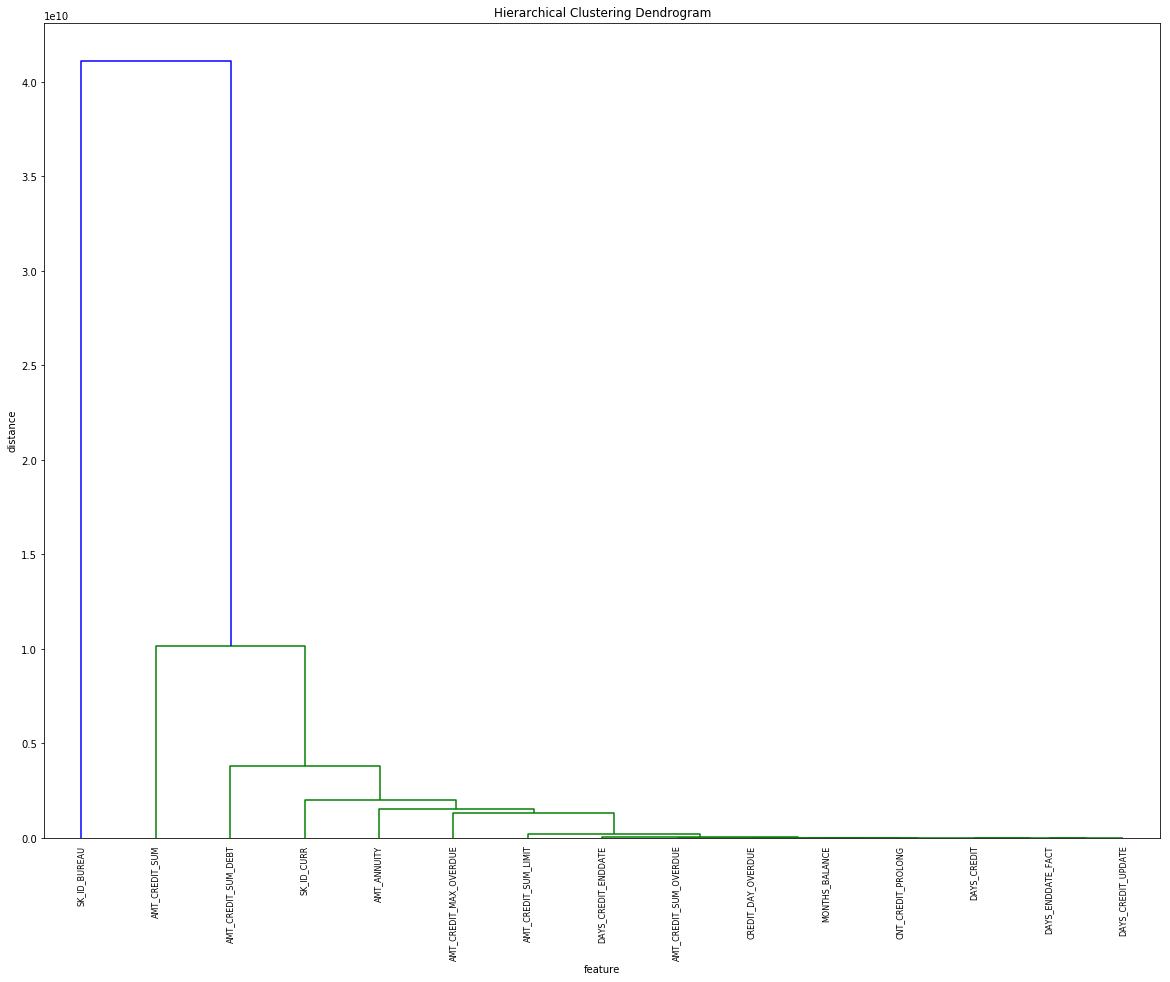

In [14]:
numerical_features_lst = list(set(merged_df.columns.tolist()) - set(categorical_features_lst))

# generate the linkage matrix
numerical_features_df = merged_df[numerical_features_lst]
numerical_features_df.fillna(-1, inplace = True) # We need to impute missing values before creating the dendrogram
numerical_features_df = numerical_features_df.transpose()
Z = linkage(numerical_features_df, "ward")
plt.figure(figsize = (20, 15))
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("feature")
plt.ylabel("distance")
dend = dendrogram(
    Z,
    leaf_rotation = 90.,  # rotates the x axis labels
    leaf_font_size = 8.,  # font size for the x axis labels
    labels = numerical_features_df.index.tolist()
)

Here, we can see that date-related features are highly similar.

Text(0.5,1,'Correlation plot between numerical features')

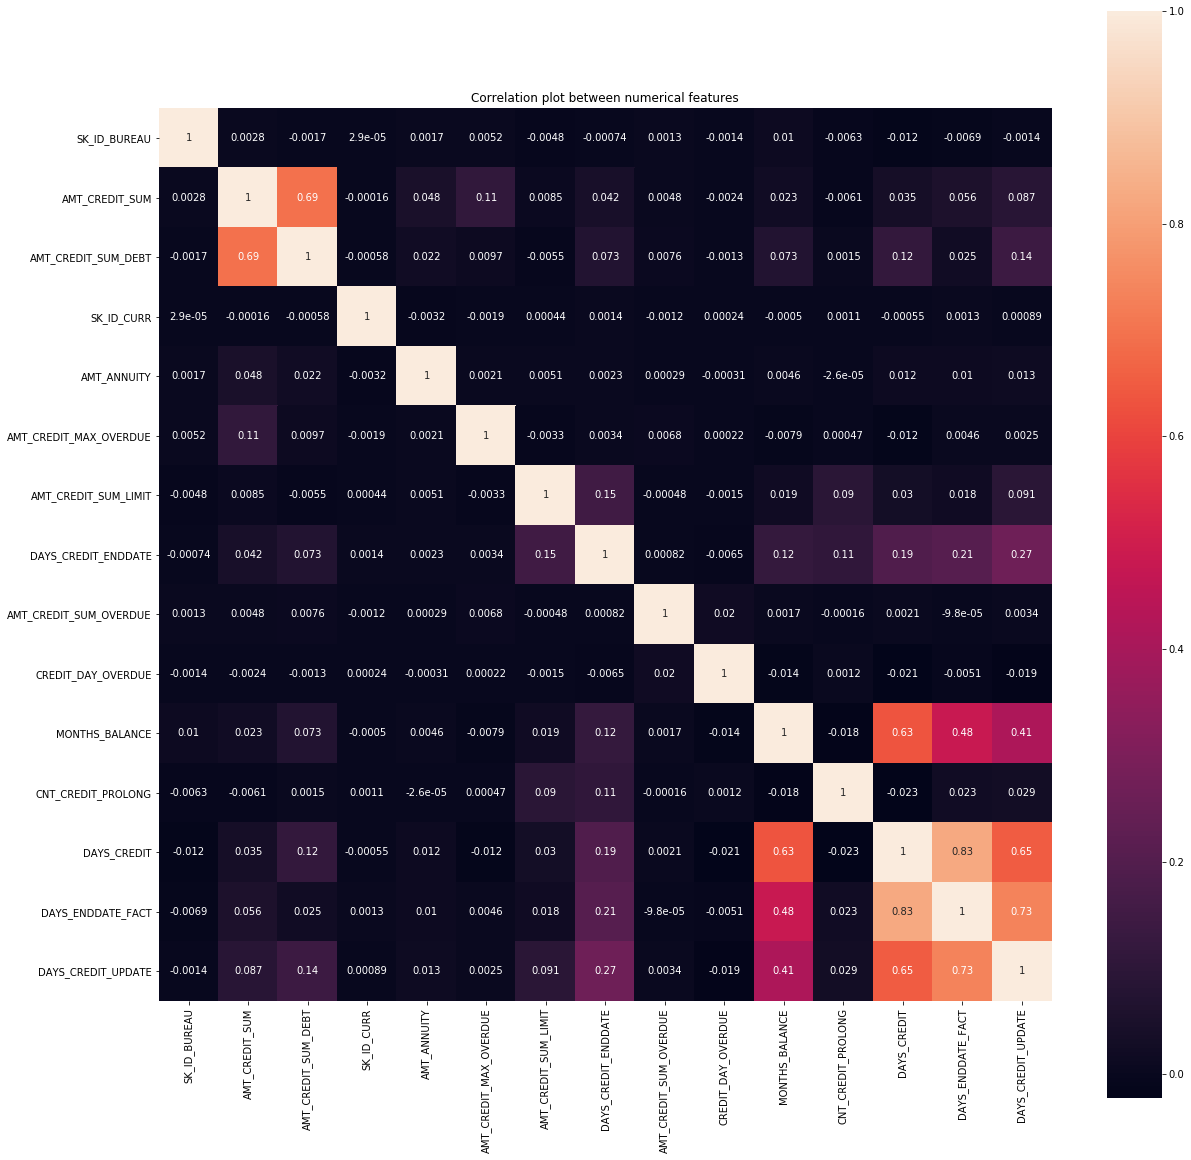

In [15]:
plt.figure(figsize = (20, 20))
sns.heatmap(merged_df[dend["ivl"]].corr(), annot = True, square = True)
plt.title("Correlation plot between numerical features")

Here we can see that some features related to how many days before current application did client apply for Credit Bureau credit are highly correlated. High correlation exists between *AMT_CREDIT_SUM* and *AMT_CREDIT_SUM_DEBT*. Other features are not correlated, as correlation is near zero.

Now, let's plots histograms of these features.

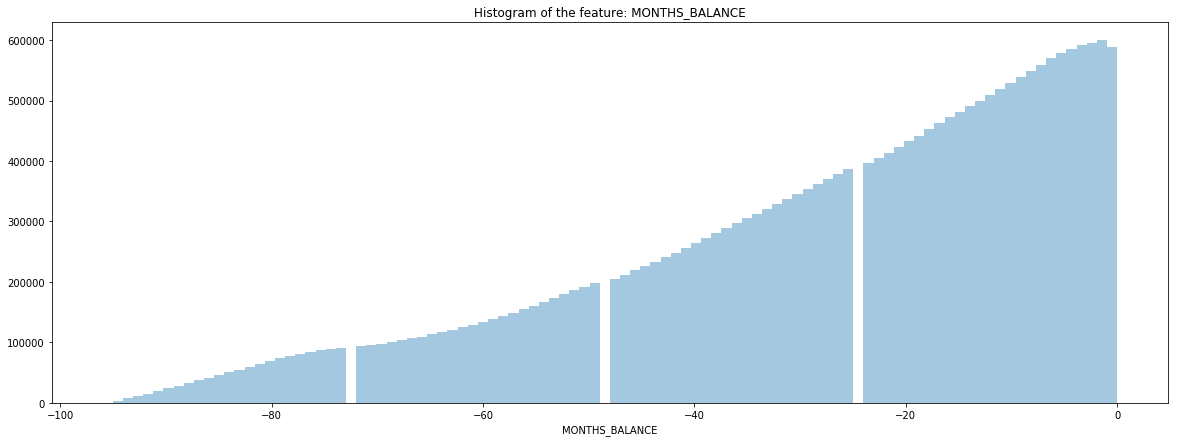

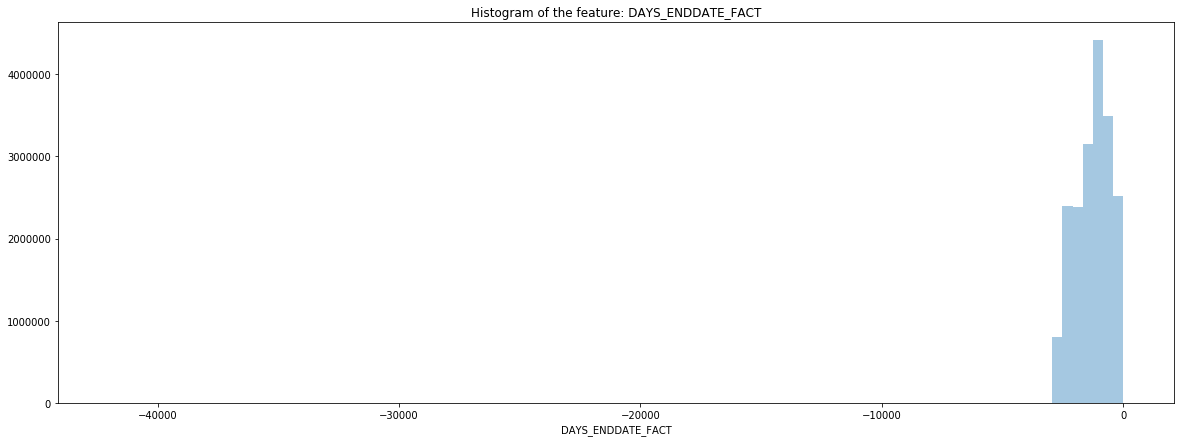

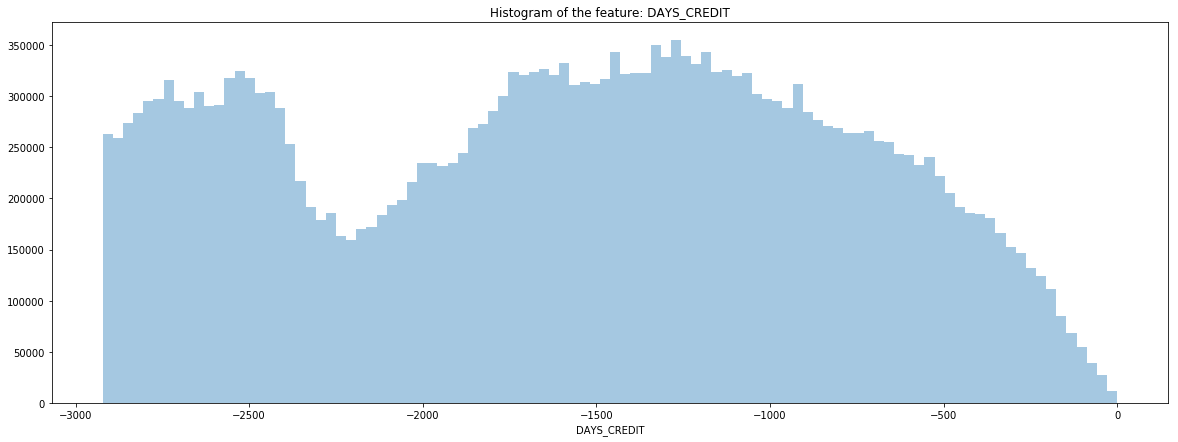

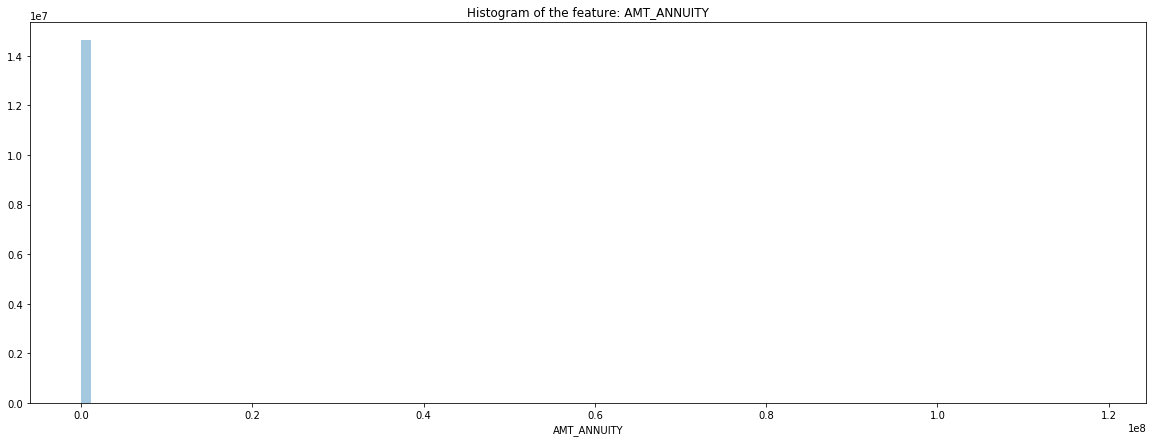

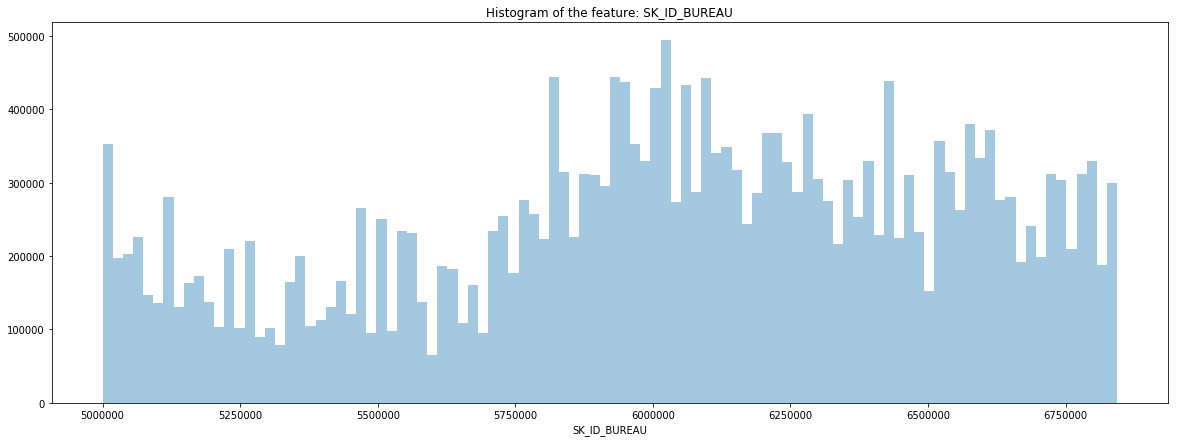

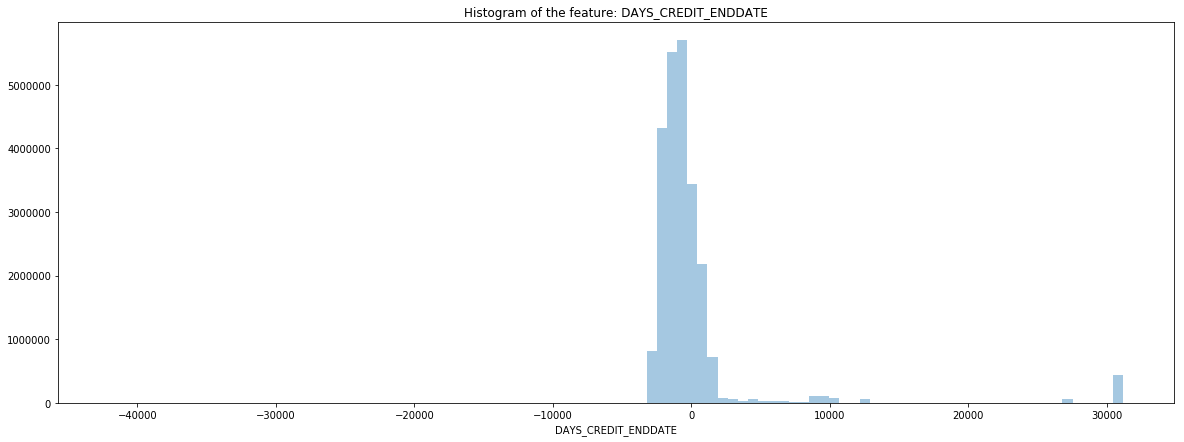

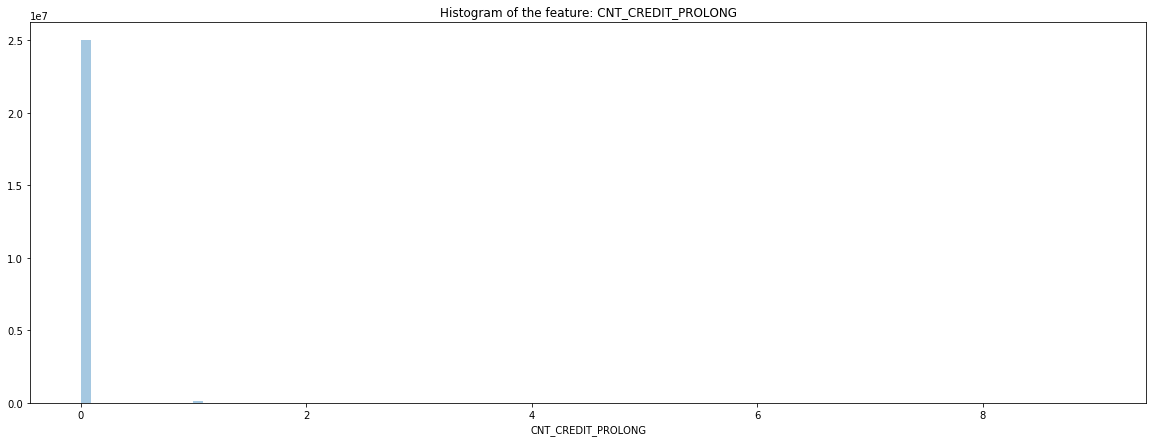

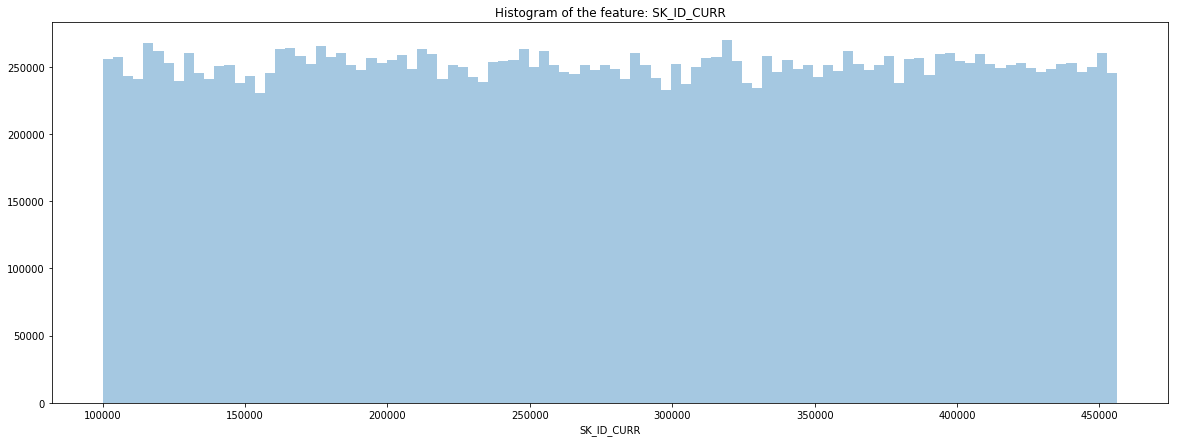

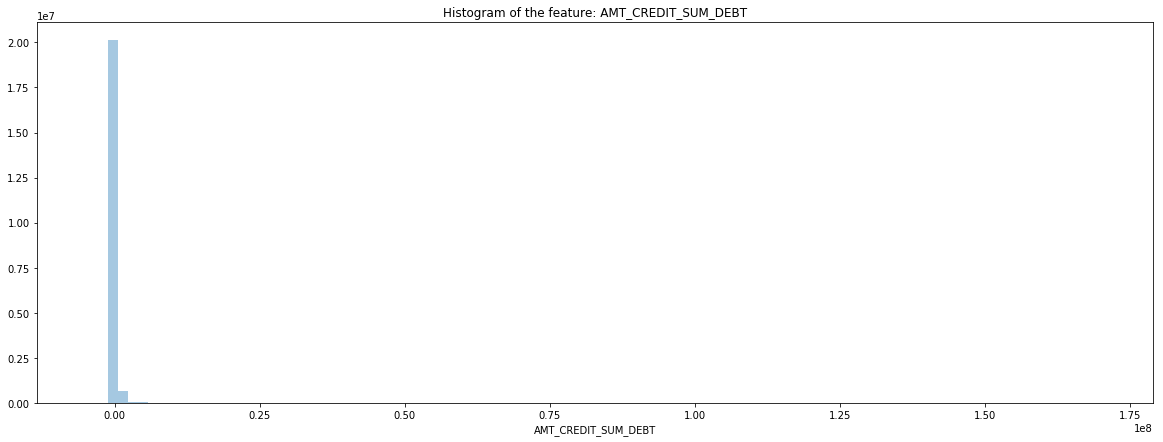

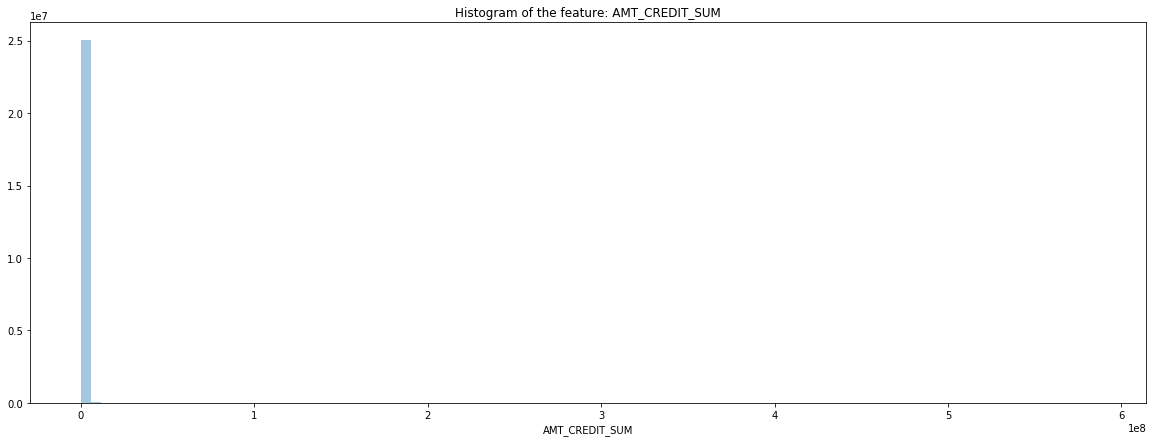

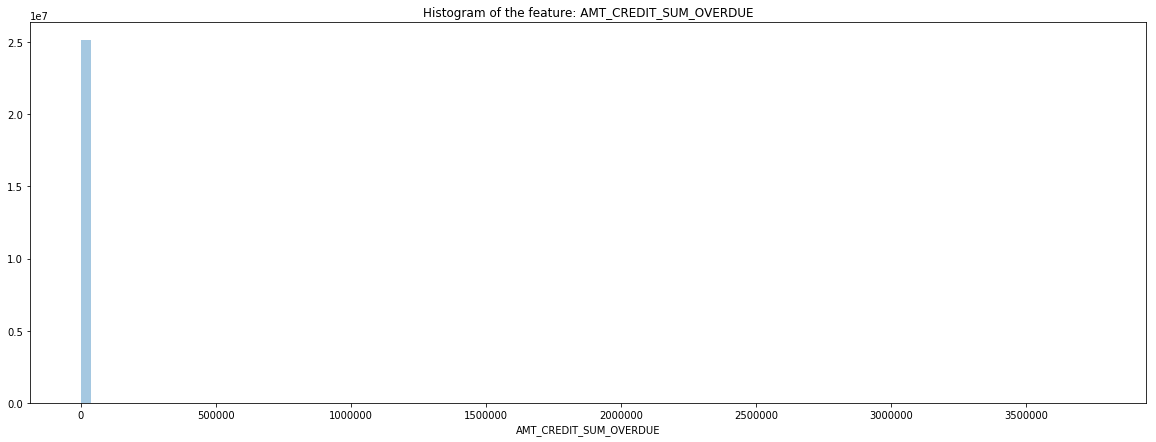

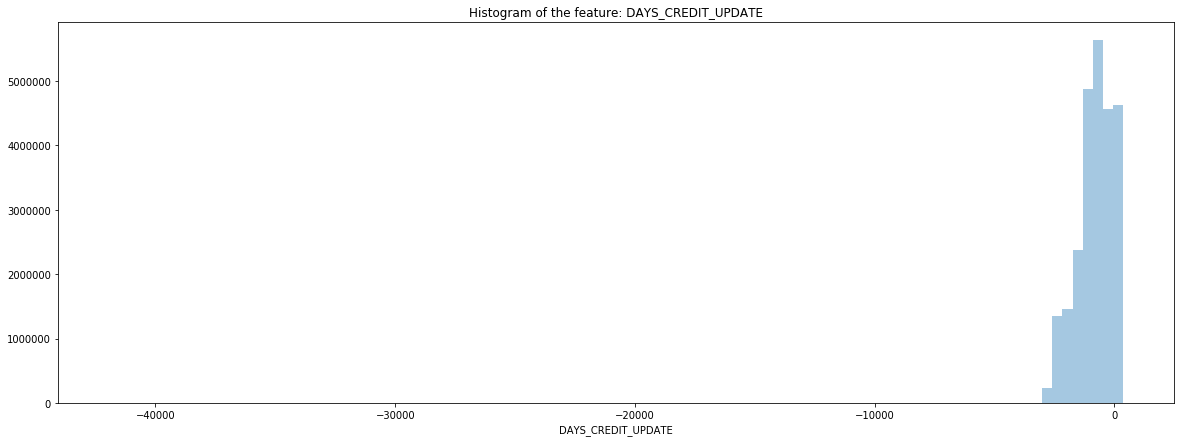

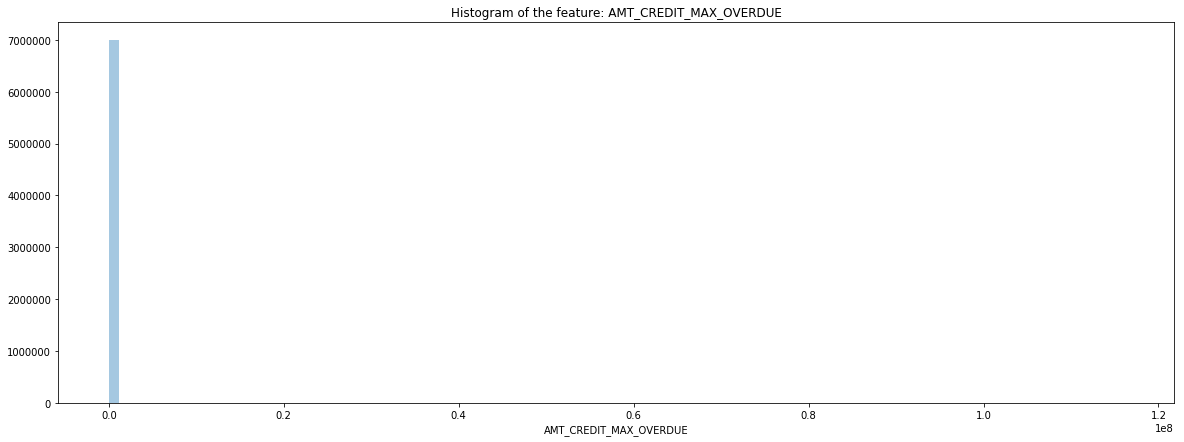

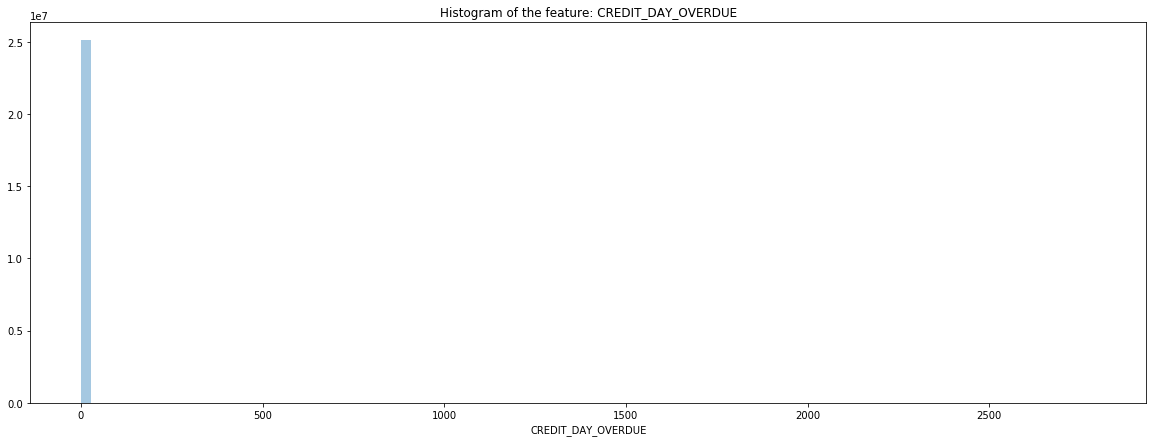

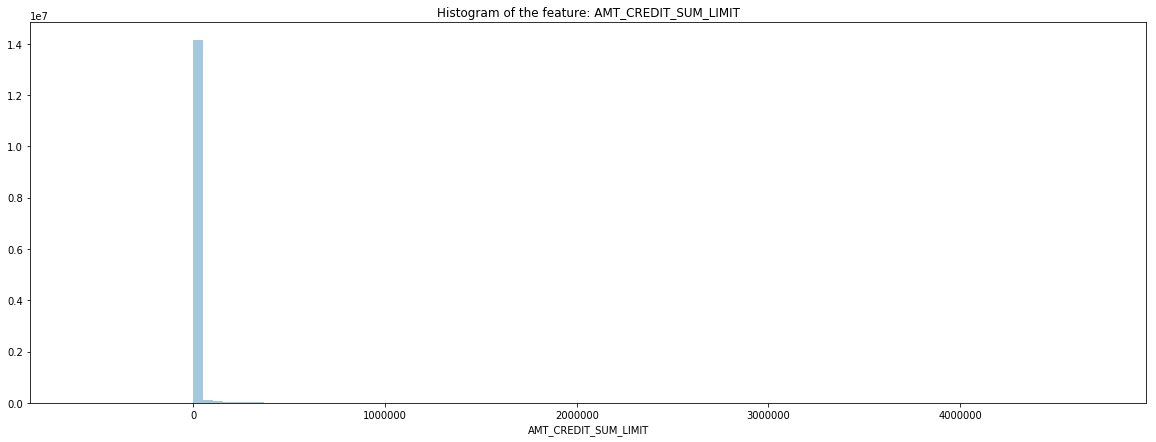

In [16]:
for feature in numerical_features_lst:
    fig, ax = plt.subplots(1, 1, sharex = False, sharey = False, figsize = (20, 7))
    
    # Plot feature distribution
    sns.distplot(merged_df[feature].dropna(), kde = False, bins = 100, ax = ax)
    ax.set_title("Histogram of the feature: " + feature)

From the histograms above, we can get some useful insights:
 - They are a lot of outliers, especially for features: *CREDIT_DAY_OVERDUE*, *AMT_CREDIT_SUM_DEBT*, *AMT_ANNUITY*, *AMT_CREDIT_SUM*, *DAYS_CREDIT_ENDDATE*, *AMT_CREDIT_SUM_LIMIT*, *CNT_CREDIT_PROLONG*, *DAYS_ENDDATE_FACT*, *AMT_CREDIT_SUM_OVERDUE*, *AMT_CREDIT_MAX_OVERDUE*, *DAYS_CREDIT_UPDATE*
 - For *MONTHS_BALANCE*, why three bins are missing?
 
Now, let's look at missing values.

Text(0.5,1,'Percentage of missing values in the bureau and bureau balance data')

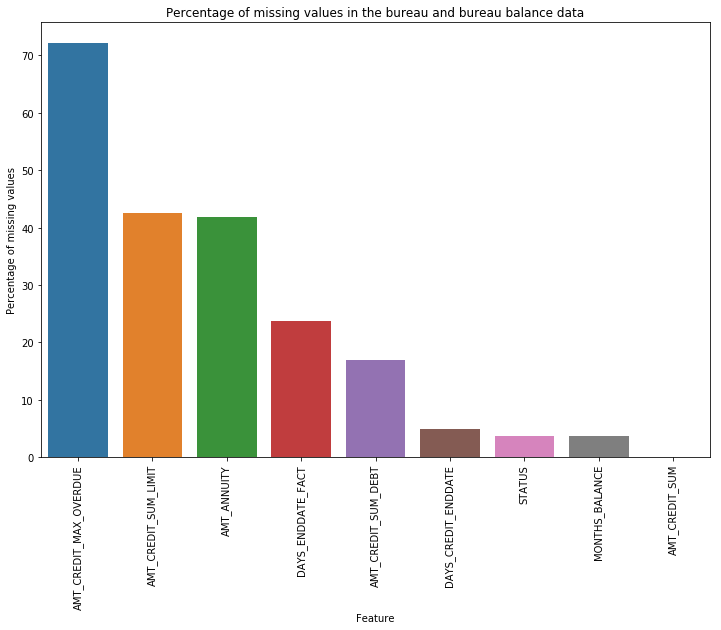

In [17]:
missing_values_sr = merged_df.isnull().sum()
missing_values_df = missing_values_sr.loc[missing_values_sr > 0].sort_values(ascending = False).reset_index()
missing_values_df.columns = ["Feature", "Number of missing values"]
missing_values_df["Percentage of missing values"] = (missing_values_df["Number of missing values"] / merged_df.shape[0]) * 100

sns.barplot(x = missing_values_df["Feature"], y = missing_values_df["Percentage of missing values"])
plt.xticks(rotation = 90)
plt.title("Percentage of missing values in the bureau and bureau balance data")

Here, we can see that only nine features have missing values.

# 3.5. Looking at credit_card_balance.csv

This data contains monthly balance snapshots of previous credit card clients have with Home Credit.

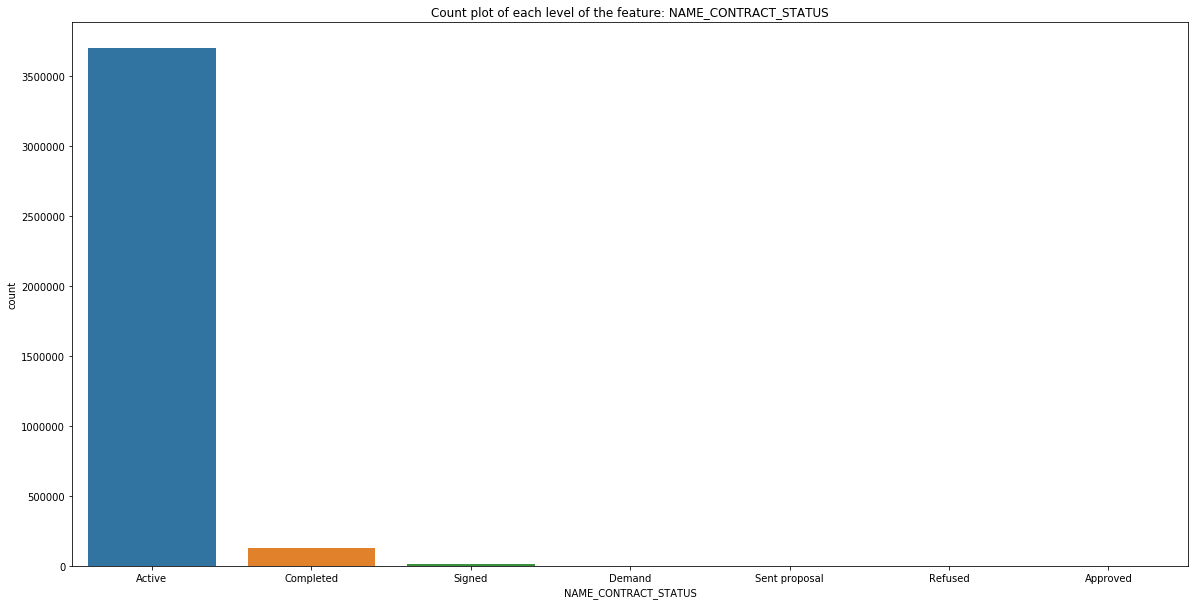

In [18]:
categorical_features_lst = credit_card_balance_data_df.select_dtypes(["object"]).columns.tolist()

for feature in categorical_features_lst:
    fig, ax = plt.subplots(1, 1, sharex = False, sharey = False, figsize = (20, 10))
    # Plot levels distribution
    if credit_card_balance_data_df[feature].nunique() < 10:
        sns.countplot(x = credit_card_balance_data_df[feature], ax = ax, order = credit_card_balance_data_df[feature].value_counts().index.tolist())
    else:
        sns.countplot(y = credit_card_balance_data_df[feature], ax = ax, order = credit_card_balance_data_df[feature].value_counts().index.tolist())
    ax.set_title("Count plot of each level of the feature: " + feature)

In this dataset, there is only one categorical feature that indicates the contract status on the previous credit. We can see that most previous credits are still active.

Now, let's look at numerical features.

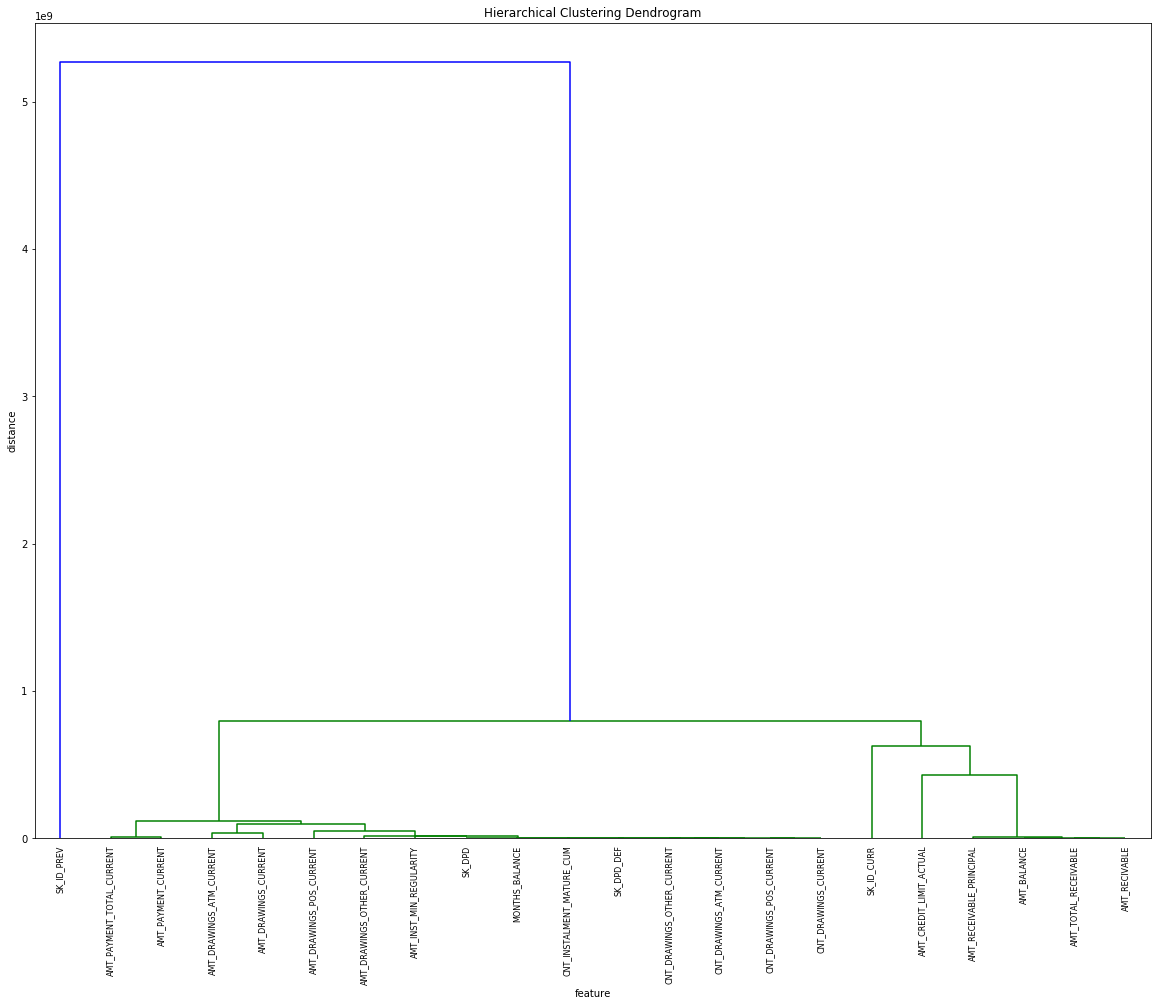

In [19]:
numerical_features_lst = list(set(credit_card_balance_data_df.columns.tolist()) - set(categorical_features_lst))

# generate the linkage matrix
numerical_features_df = credit_card_balance_data_df[numerical_features_lst]
numerical_features_df.fillna(-1, inplace = True) # We need to impute missing values before creating the dendrogram
numerical_features_df = numerical_features_df.transpose()
Z = linkage(numerical_features_df, "ward")
plt.figure(figsize = (20, 15))
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("feature")
plt.ylabel("distance")
dend = dendrogram(
    Z,
    leaf_rotation = 90.,  # rotates the x axis labels
    leaf_font_size = 8.,  # font size for the x axis labels
    labels = numerical_features_df.index.tolist()
)

Here, we can see that features can be split into two clusters: features from *AMT_PAYMENT_TOTAL_CURRENT* to *CNT_DRAWINGS_POS_CURRENT* and from *AMT_CREDIT_LIMIT_ACTUAL* to *AMT_RECIVABLE*. The first cluster groups features related to the amount and number of drawings, whereas the second one deals with balance amount and credit limit.

Text(0.5,1,'Correlation plot between numerical features')

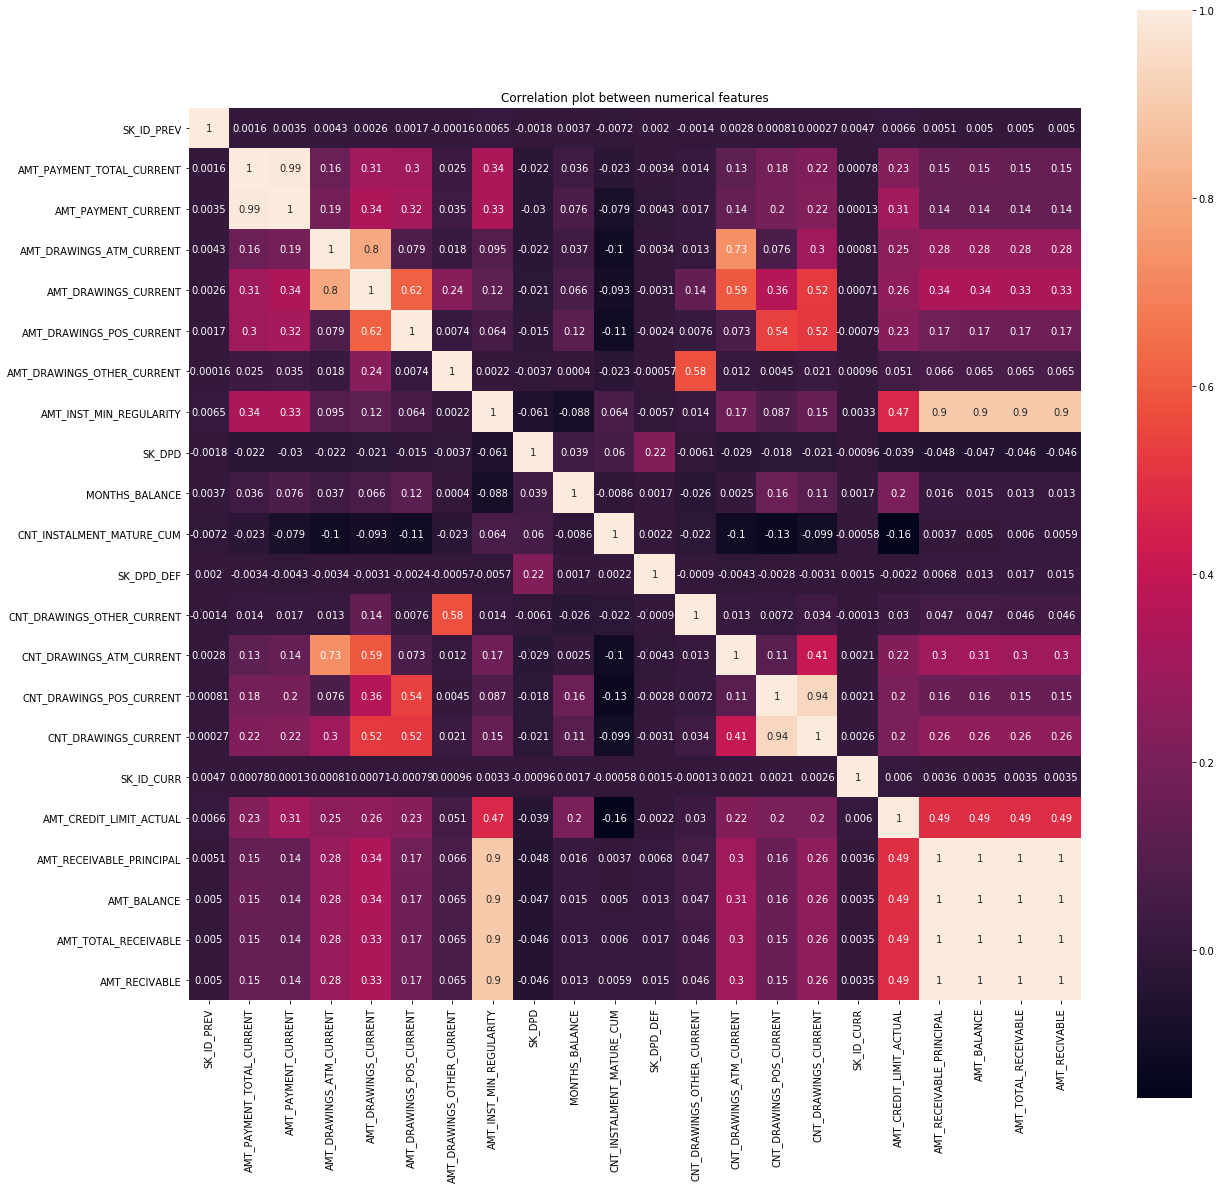

In [20]:
plt.figure(figsize = (20, 20))
sns.heatmap(credit_card_balance_data_df[dend["ivl"]].corr(), annot = True, square = True)
plt.title("Correlation plot between numerical features")

Here, we can see some highly correlated features or even duplicated features (*AMT_RECEIVABLE_PRINCIPAL*, *AMT_BALANCE*, *AMT_TOTAL_RECEIVABLE* and *AMT_RECEIVABLE*).

Now let's look at those features' distribution.

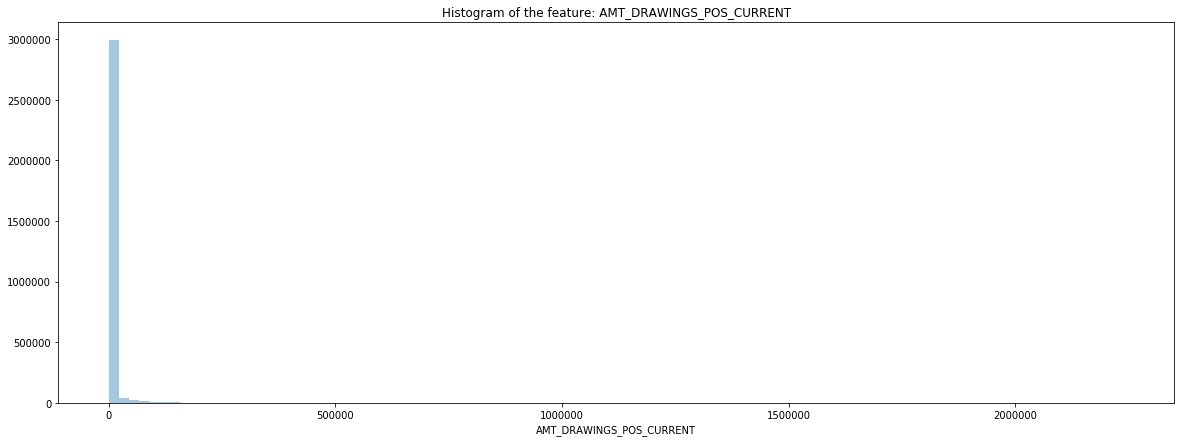

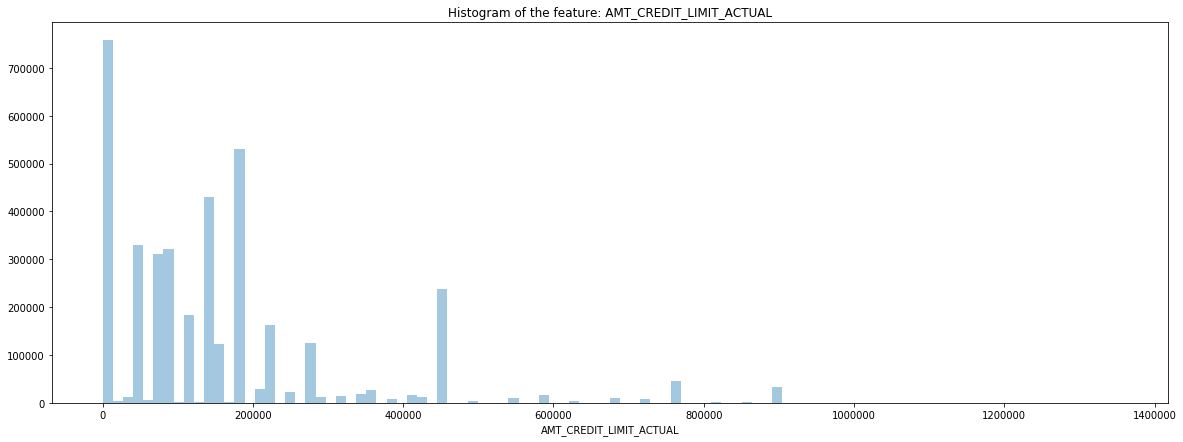

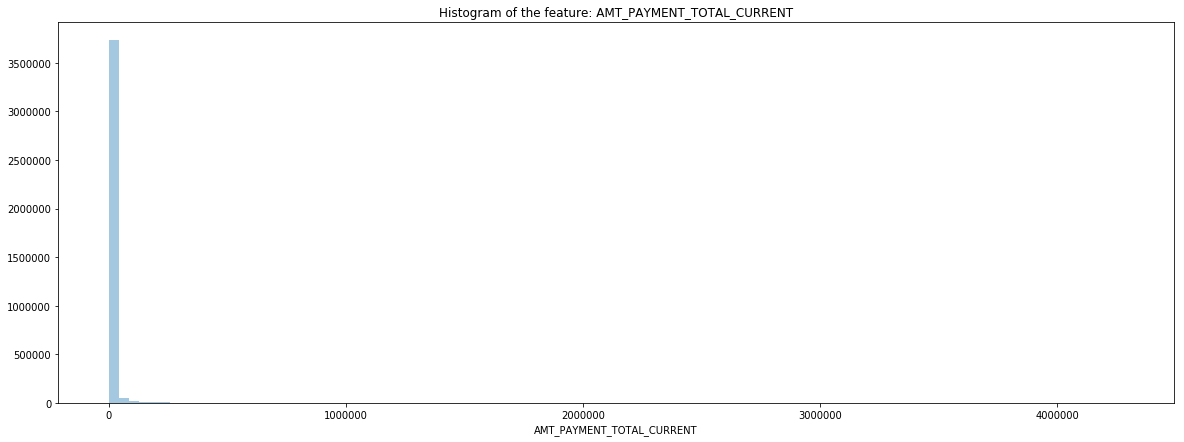

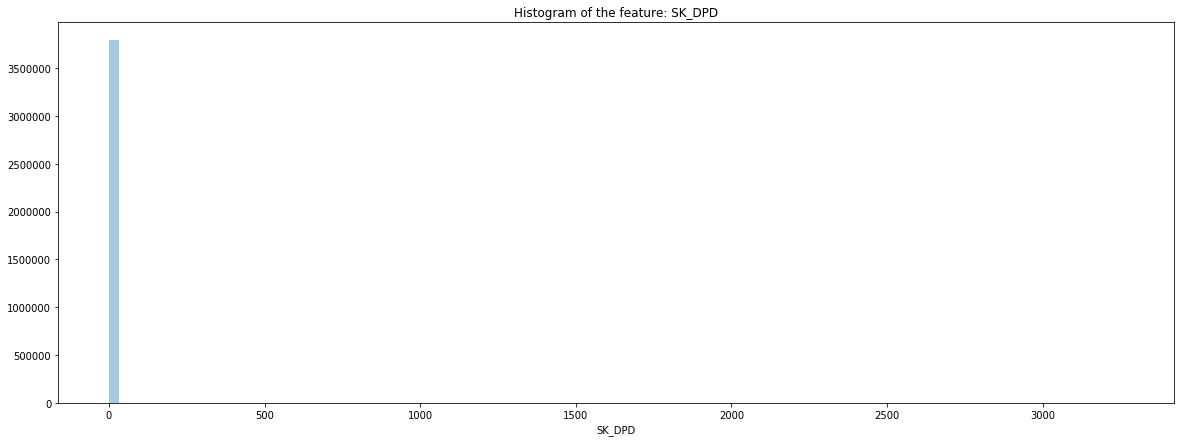

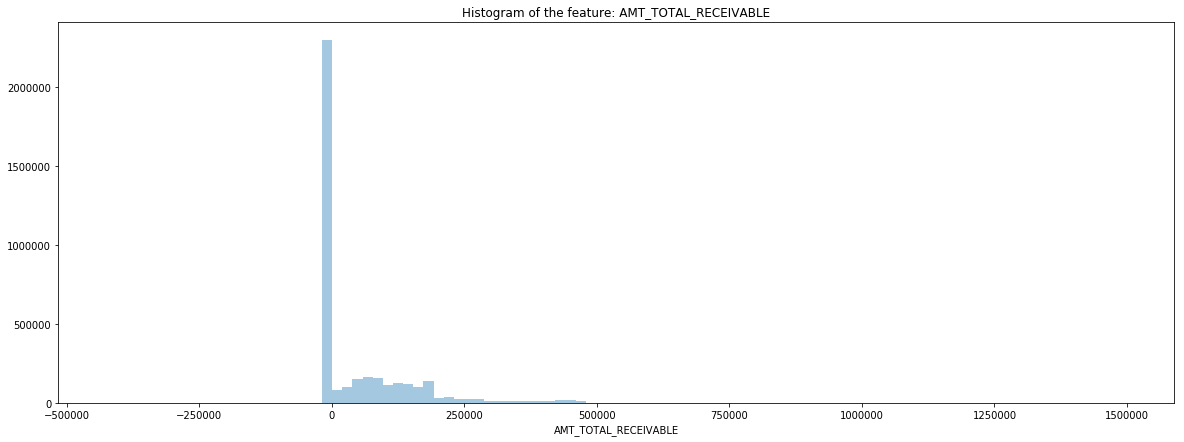

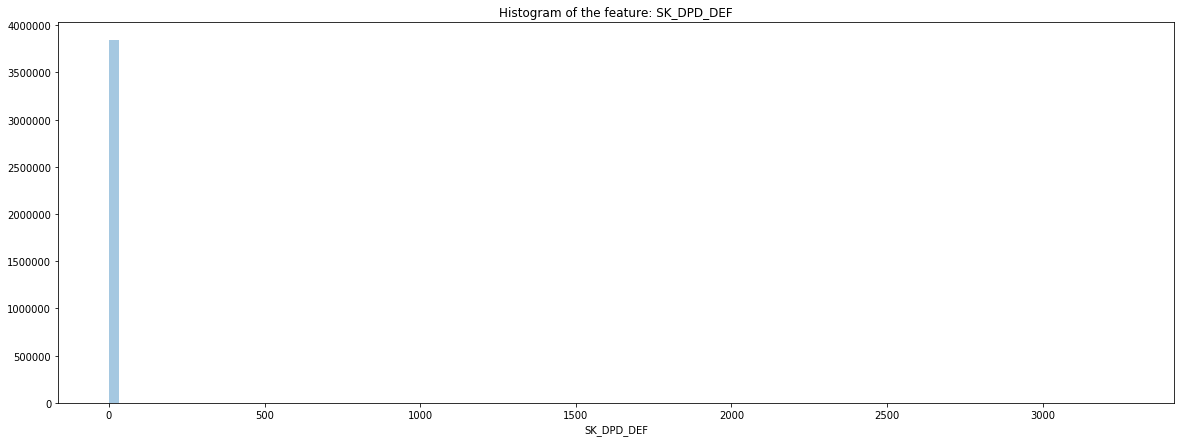

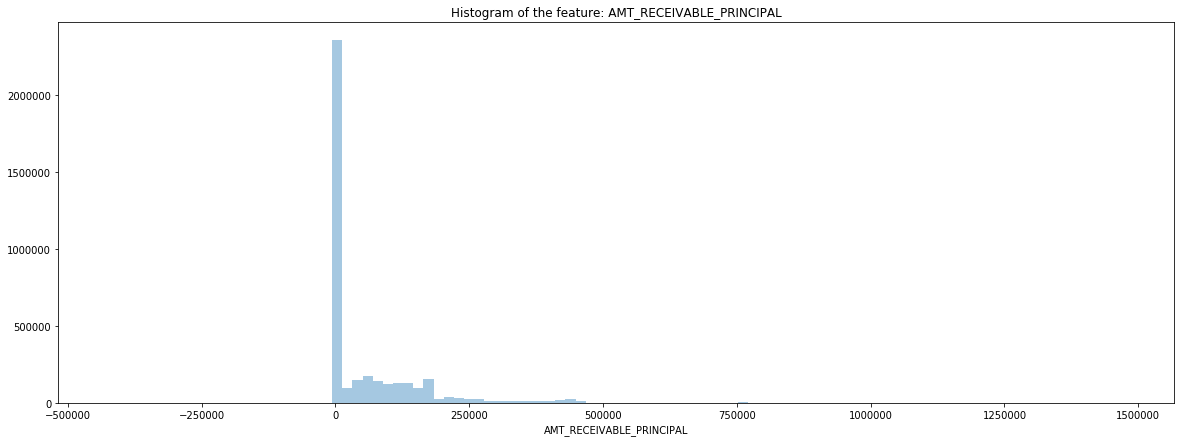

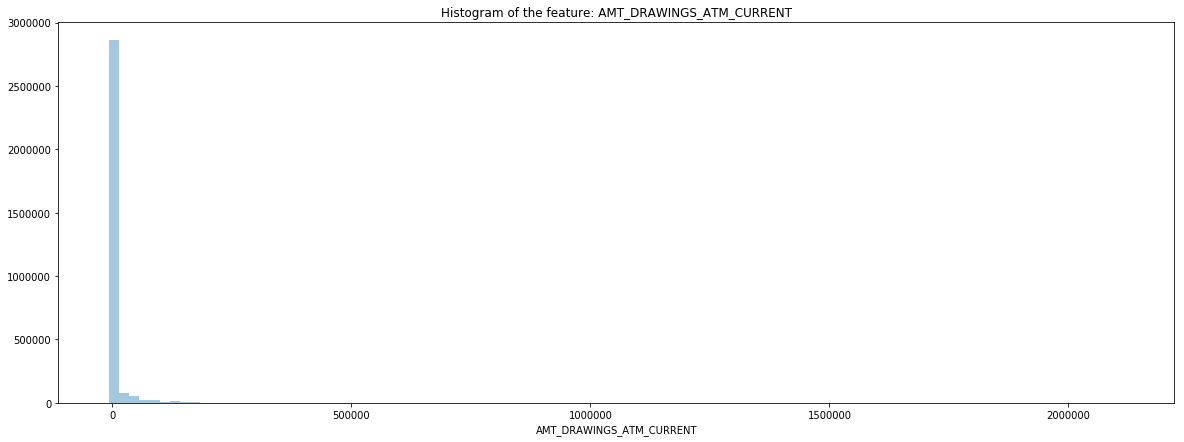

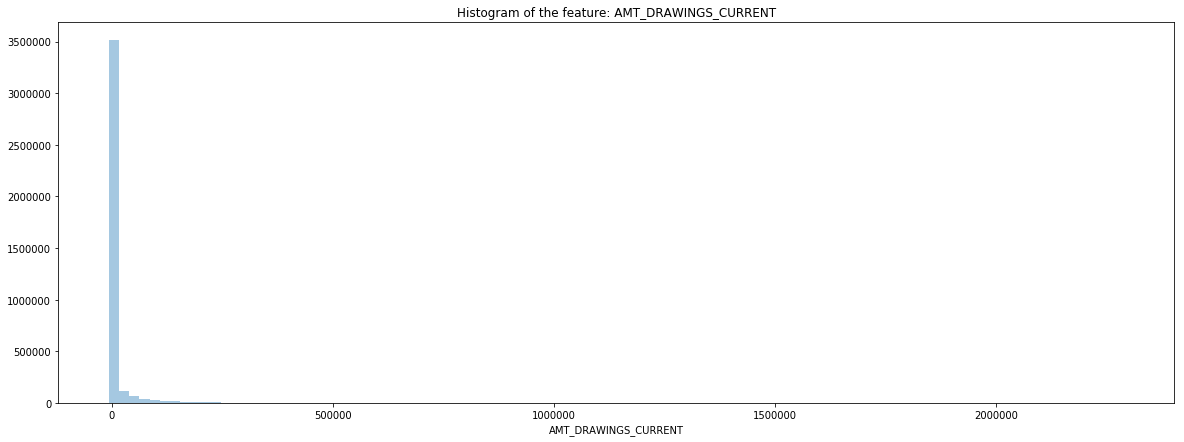

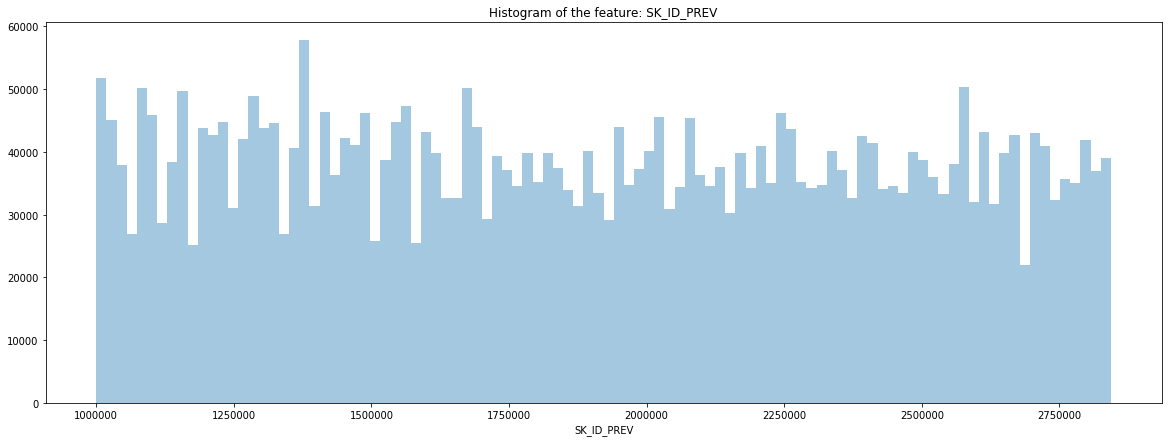

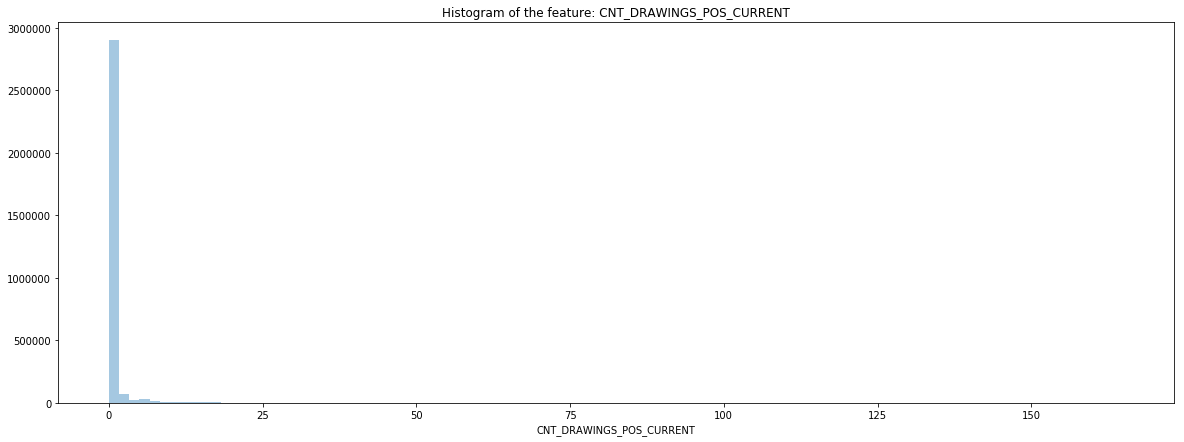

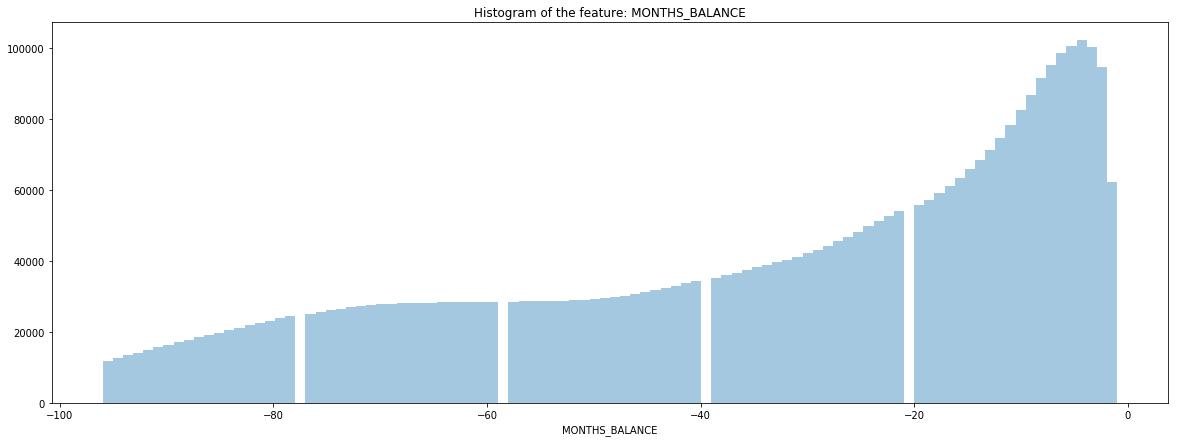

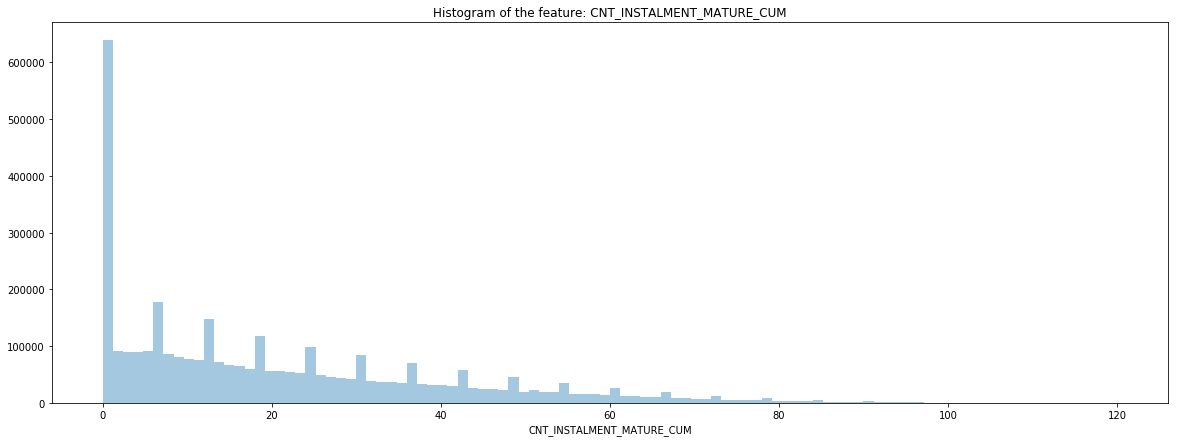

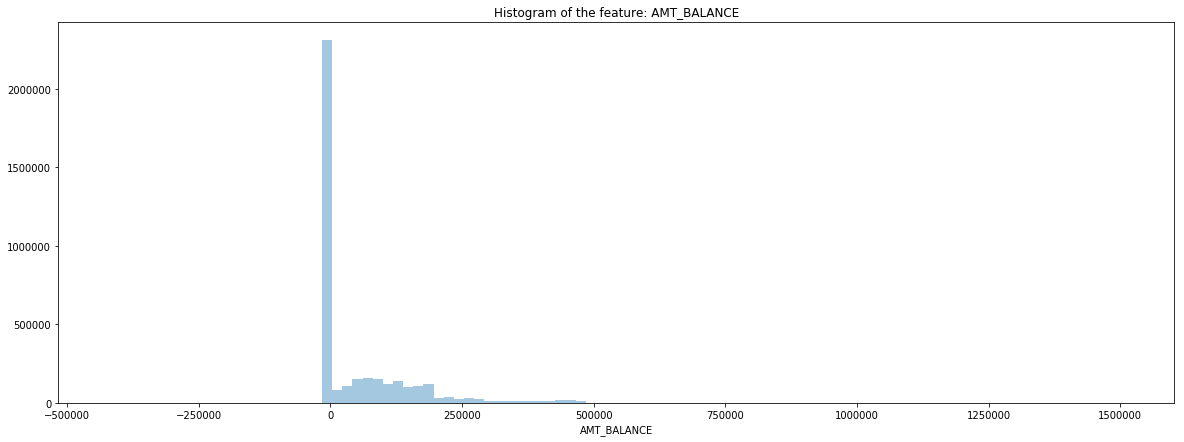

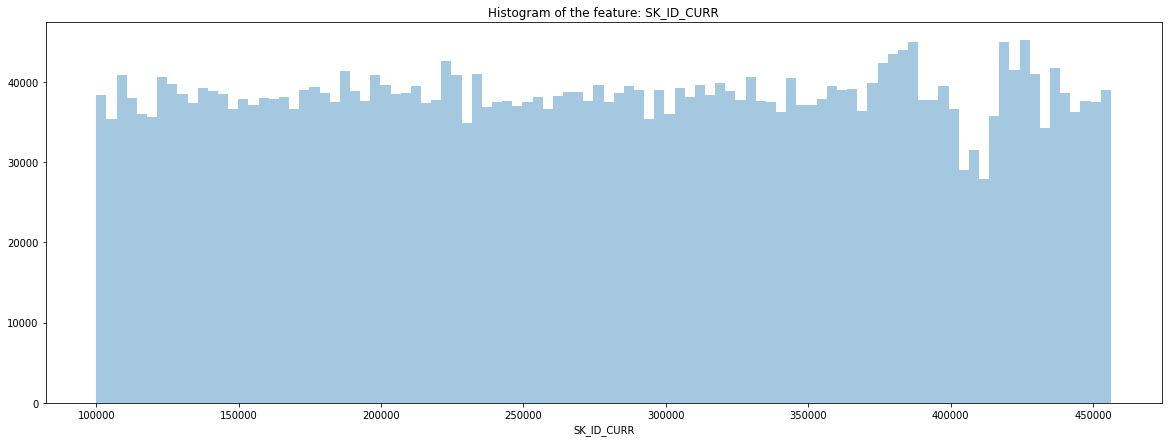

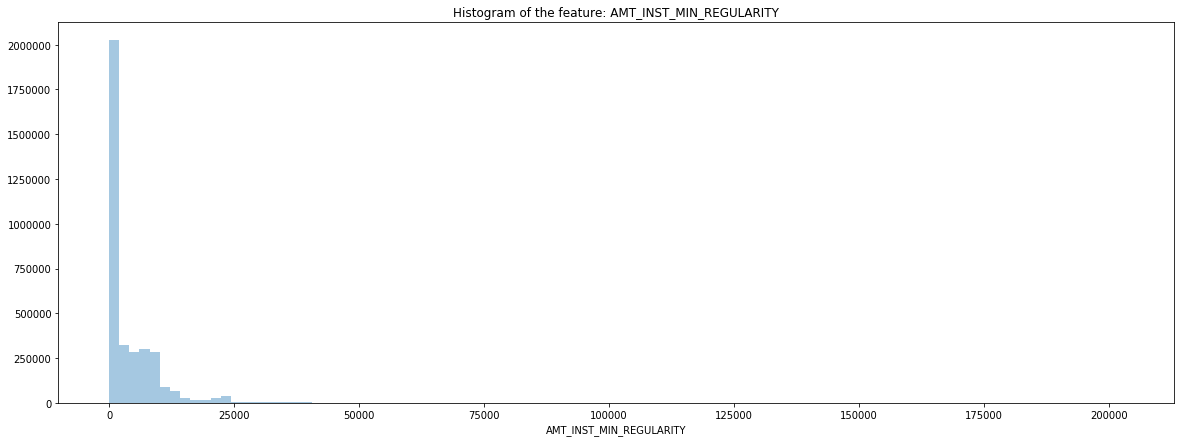

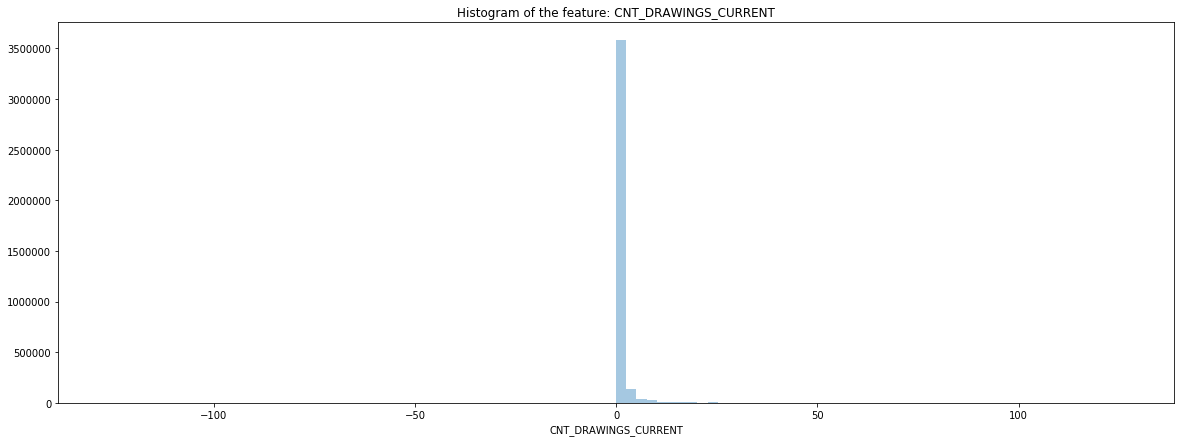

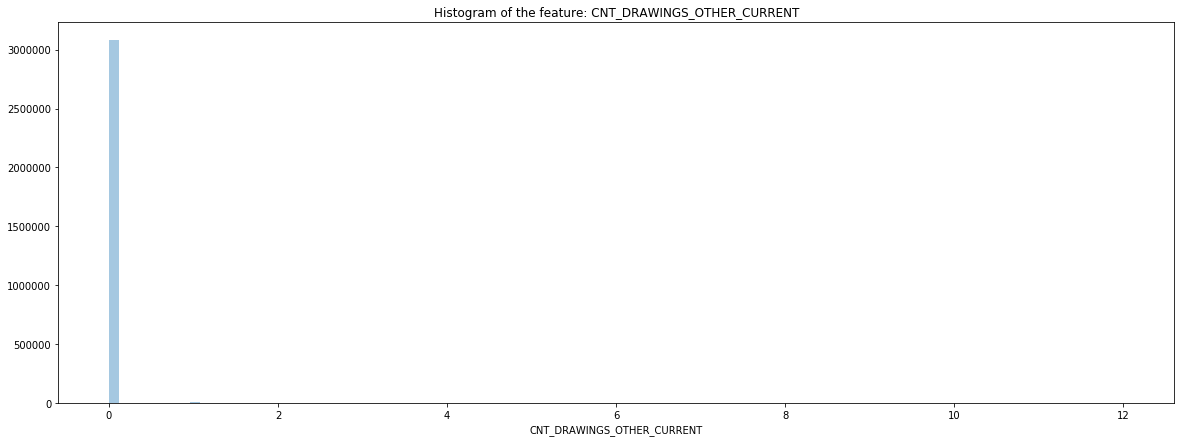

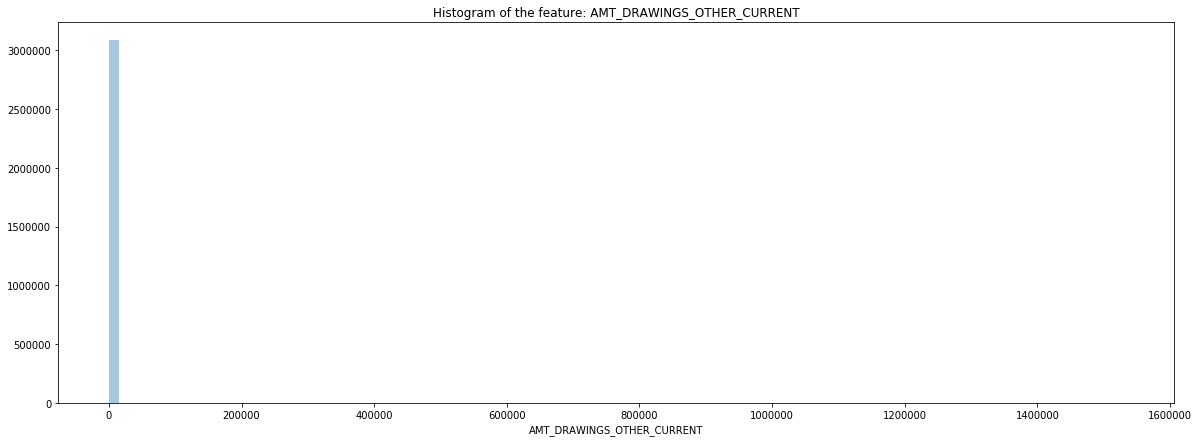

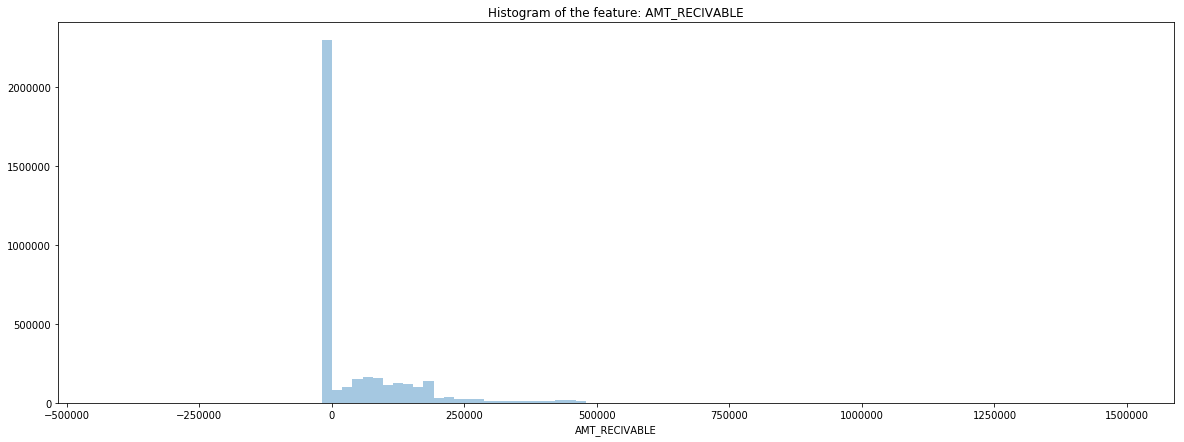

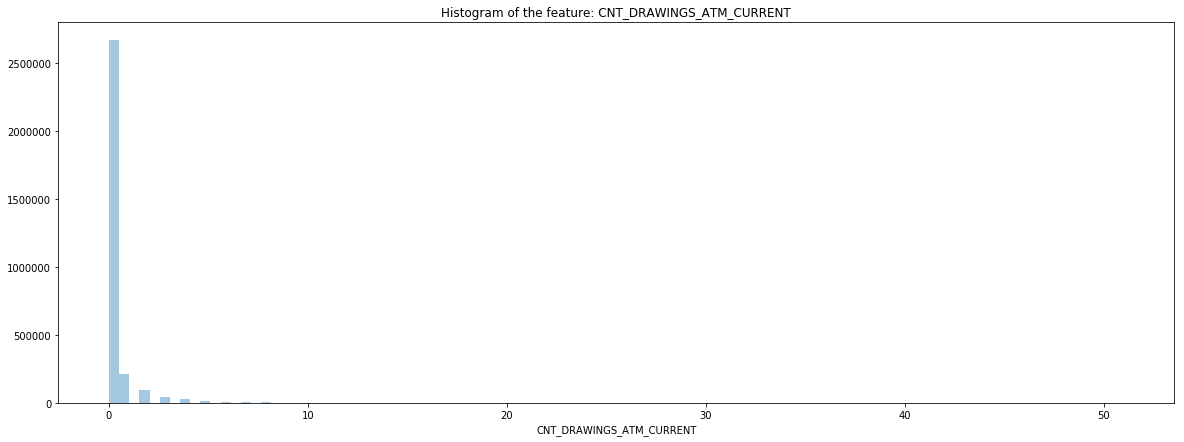

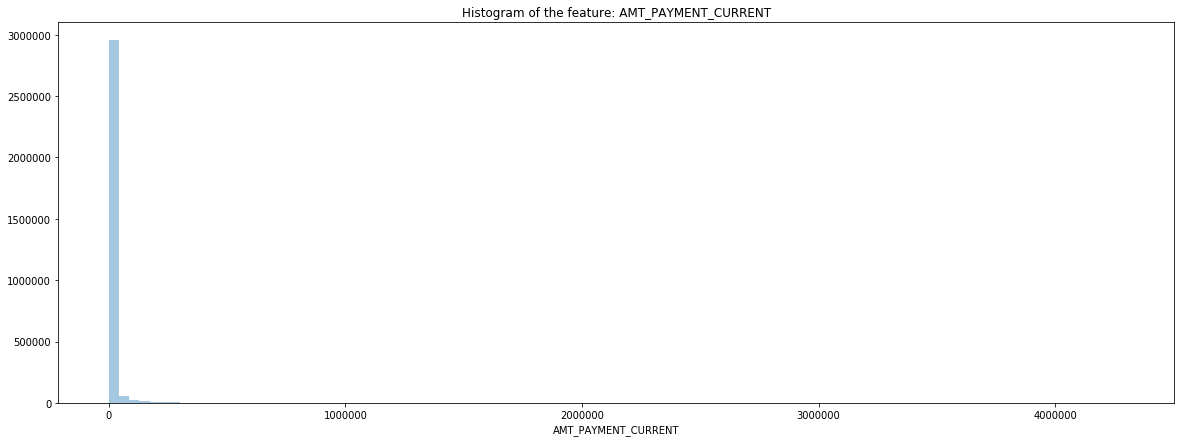

In [21]:
for feature in numerical_features_lst:
    fig, ax = plt.subplots(1, 1, sharex = False, sharey = False, figsize = (20, 7))
    
    # Plot feature distribution
    sns.distplot(credit_card_balance_data_df[feature].dropna(), kde = False, bins = 100, ax = ax)
    ax.set_title("Histogram of the feature: " + feature)

Here, we have a lot of outliers. We also have four bins missing in *MONTHS_BALANCE*.

Now, let's look at outliers.

Text(0.5,1,'Percentage of missing values in the credit card balance data')

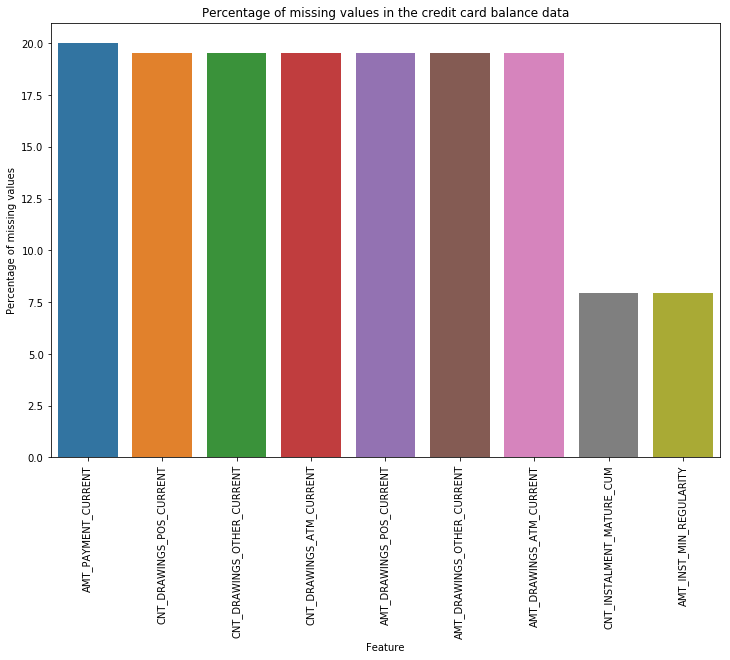

In [22]:
missing_values_sr = credit_card_balance_data_df.isnull().sum()
missing_values_df = missing_values_sr.loc[missing_values_sr > 0].sort_values(ascending = False).reset_index()
missing_values_df.columns = ["Feature", "Number of missing values"]
missing_values_df["Percentage of missing values"] = (missing_values_df["Number of missing values"] / credit_card_balance_data_df.shape[0]) * 100

sns.barplot(x = missing_values_df["Feature"], y = missing_values_df["Percentage of missing values"])
plt.xticks(rotation = 90)
plt.title("Percentage of missing values in the credit card balance data")

Here, only nine features have missing values. Furthermore, the amount of missing value is less than 20% and seems to be the same for six features.

### 3.6. Looking at installments_payments.csv

This dataset gives us data about repayment history for the loans in our data sample.

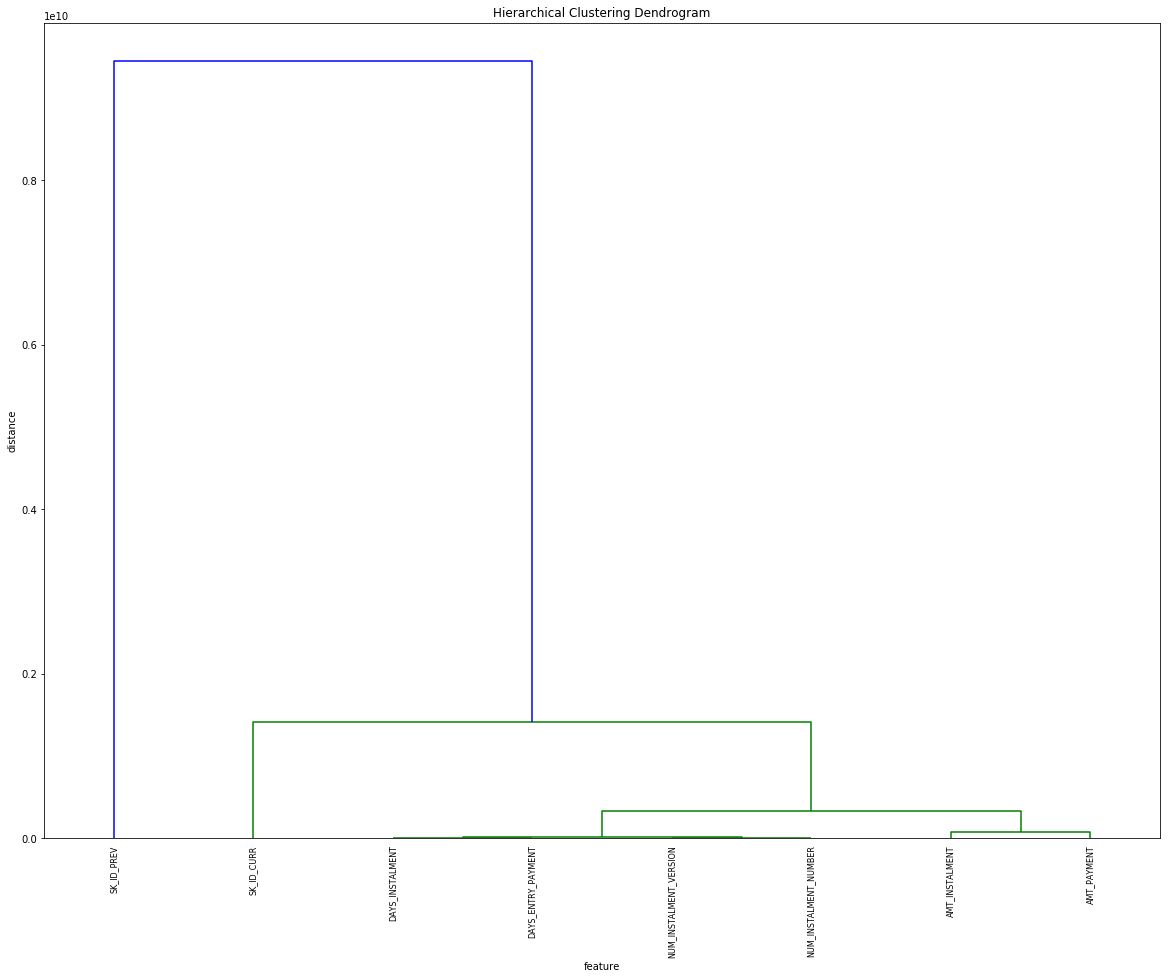

In [23]:
numerical_features_lst = installments_payments_data_df.columns.tolist()

# generate the linkage matrix
numerical_features_df = installments_payments_data_df[numerical_features_lst]
numerical_features_df.fillna(-1, inplace = True) # We need to impute missing values before creating the dendrogram
numerical_features_df = numerical_features_df.transpose()
Z = linkage(numerical_features_df, "ward")
plt.figure(figsize = (20, 15))
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("feature")
plt.ylabel("distance")
dend = dendrogram(
    Z,
    leaf_rotation = 90.,  # rotates the x axis labels
    leaf_font_size = 8.,  # font size for the x axis labels
    labels = numerical_features_df.index.tolist()
)

This dataset only contains numerical features. So we skipped the categorical features analysis part. We can see here that if we exclude keys needed to join data (*SK_ID_PREV* and *SK_ID_CURR*), all features seems similar.

Text(0.5,1,'Correlation plot between numerical features')

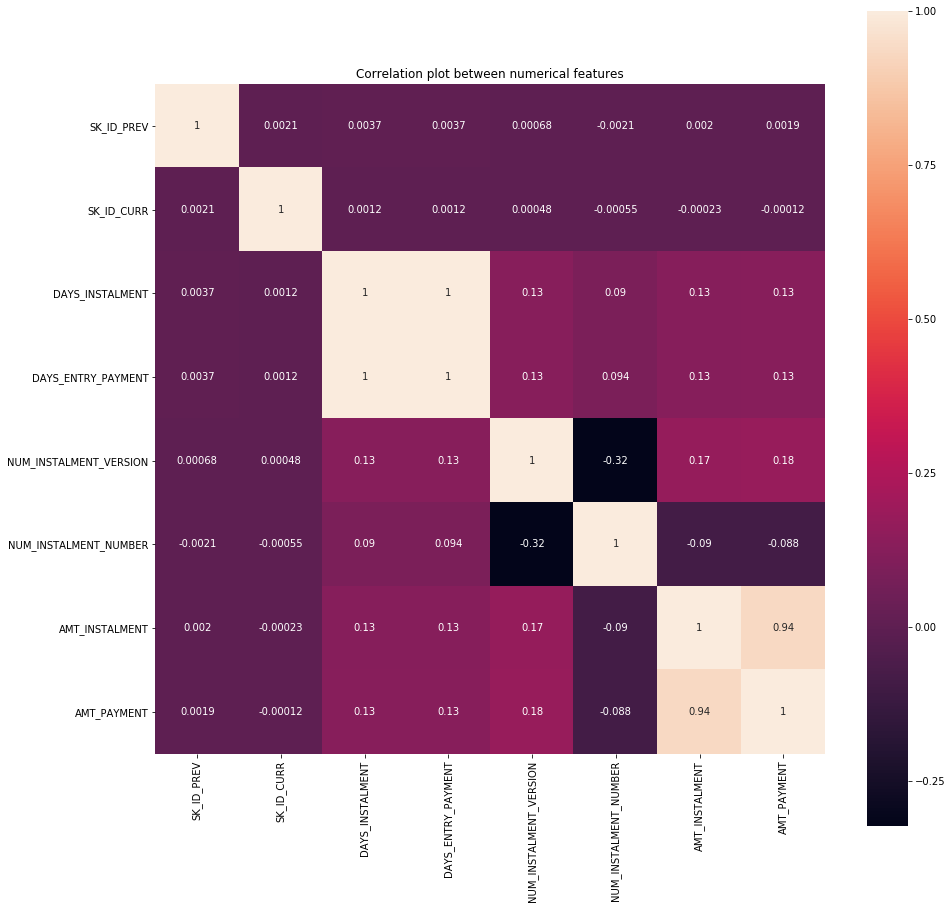

In [24]:
plt.figure(figsize = (15, 15))
sns.heatmap(installments_payments_data_df[dend["ivl"]].corr(), annot = True, square = True)
plt.title("Correlation plot between numerical features")

Here we can see that:
 - *DAYS_INSTALMENT* and *DAYS_ENTRY_PAYMENT* seems duplicated.
 - *AMT_INSTALMENT* and *AMT_PAYMENT* are highly correlated.
 - Other features have a low correlation with each other.

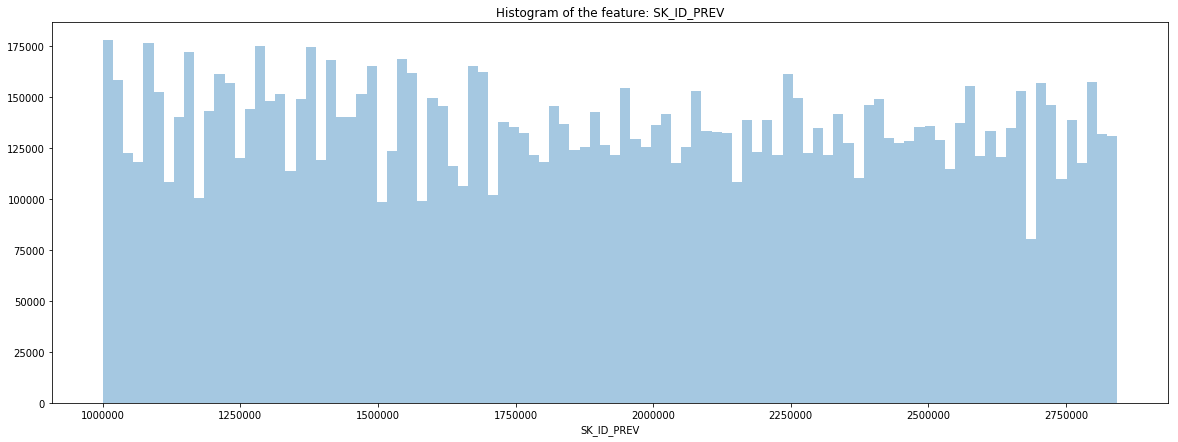

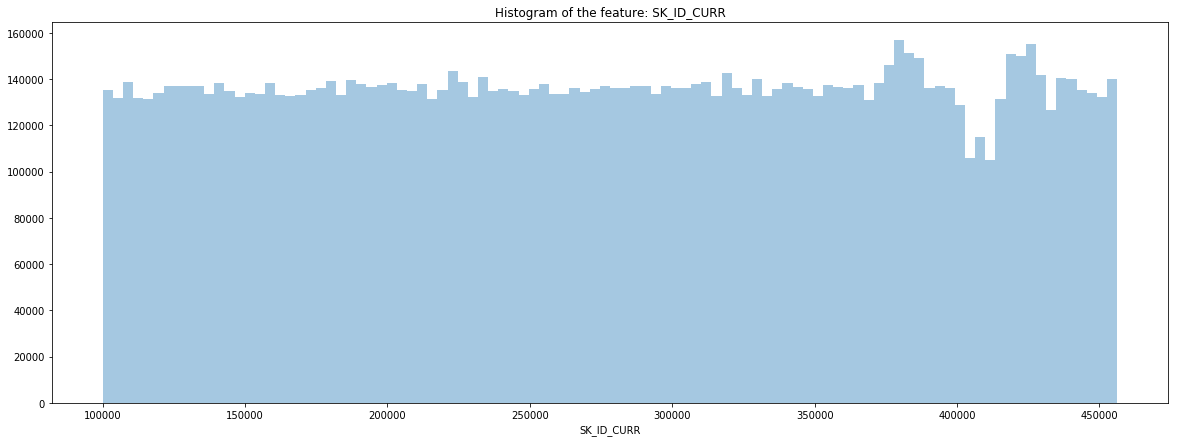

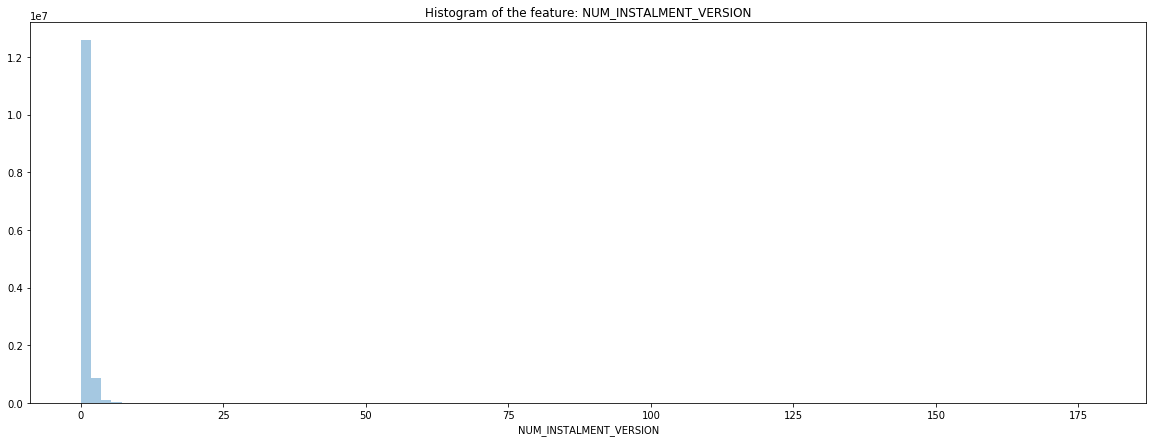

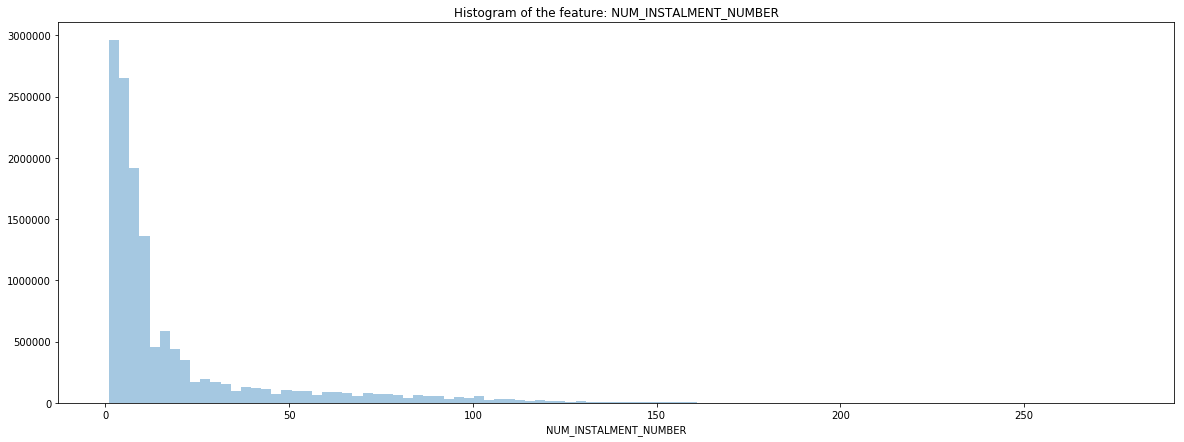

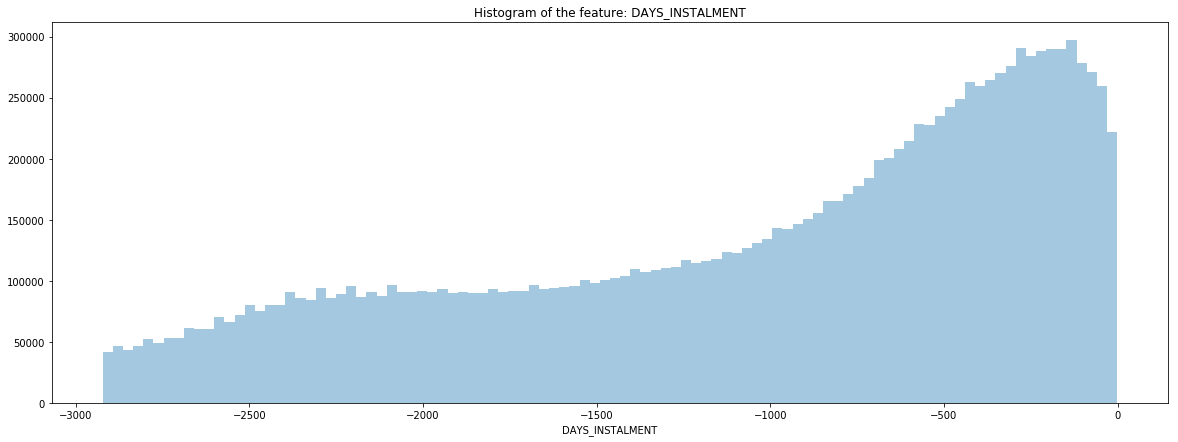

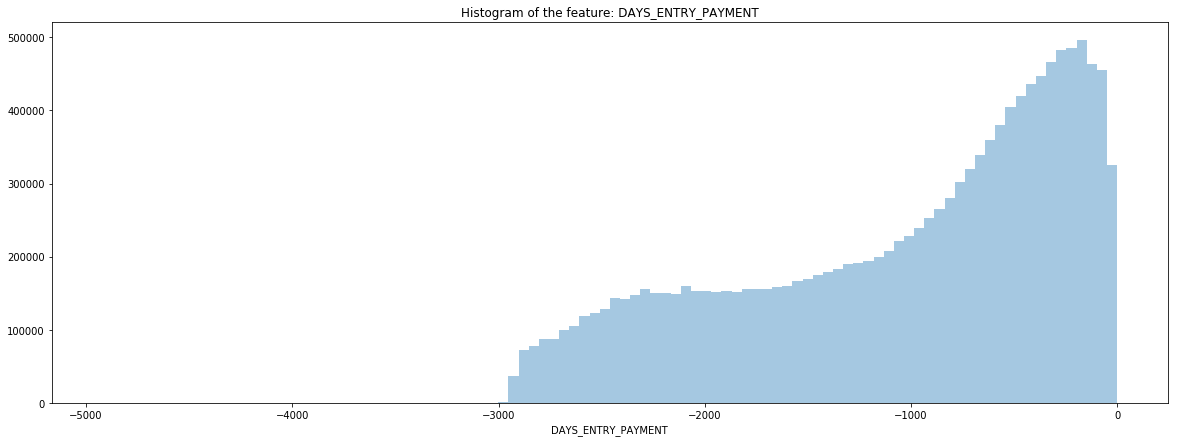

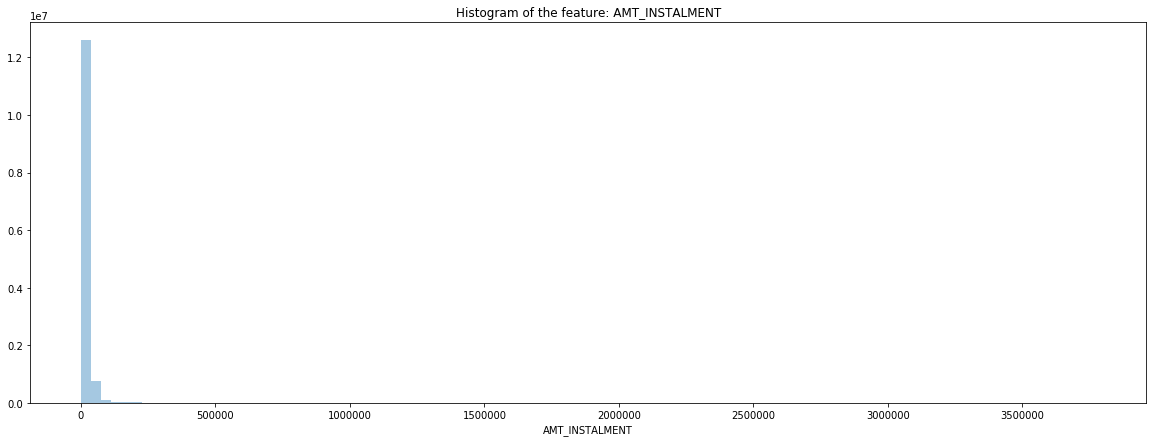

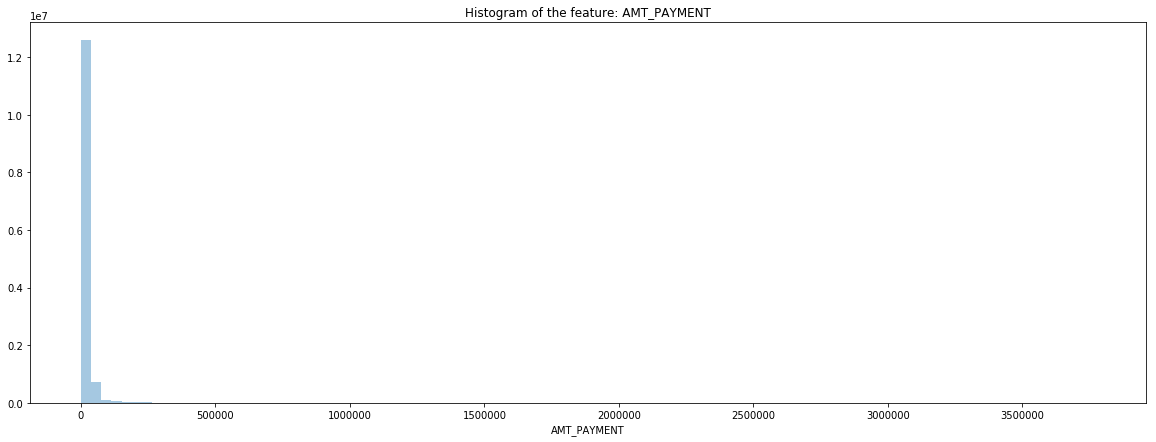

In [25]:
for feature in numerical_features_lst:
    fig, ax = plt.subplots(1, 1, sharex = False, sharey = False, figsize = (20, 7))
    
    # Plot feature distribution
    sns.distplot(installments_payments_data_df[feature].dropna(), kde = False, bins = 100, ax = ax)
    ax.set_title("Histogram of the feature: " + feature)

Here, we can find a lot of outliers, like in the previous datasets. The data is also highly skewed.

Text(0.5,1,'Percentage of missing values in the installments payments data')

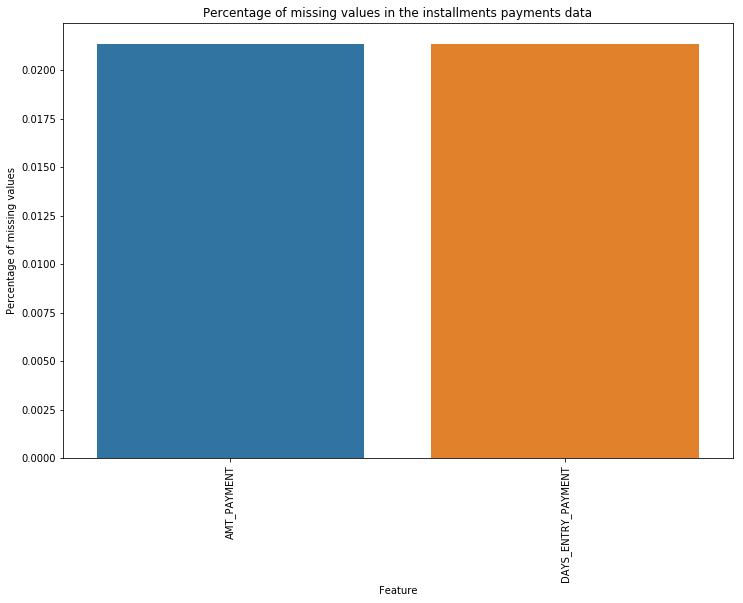

In [26]:
missing_values_sr = installments_payments_data_df.isnull().sum()
missing_values_df = missing_values_sr.loc[missing_values_sr > 0].sort_values(ascending = False).reset_index()
missing_values_df.columns = ["Feature", "Number of missing values"]
missing_values_df["Percentage of missing values"] = (missing_values_df["Number of missing values"] / installments_payments_data_df.shape[0]) * 100

sns.barplot(x = missing_values_df["Feature"], y = missing_values_df["Percentage of missing values"])
plt.xticks(rotation = 90)
plt.title("Percentage of missing values in the installments payments data")

Here, only two features have a missing values. The amount of missing values is very small (0.02%) and identical for both features.

### 3.7. Looking at POS_cash_balance.csv

This dataset contains data about monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.

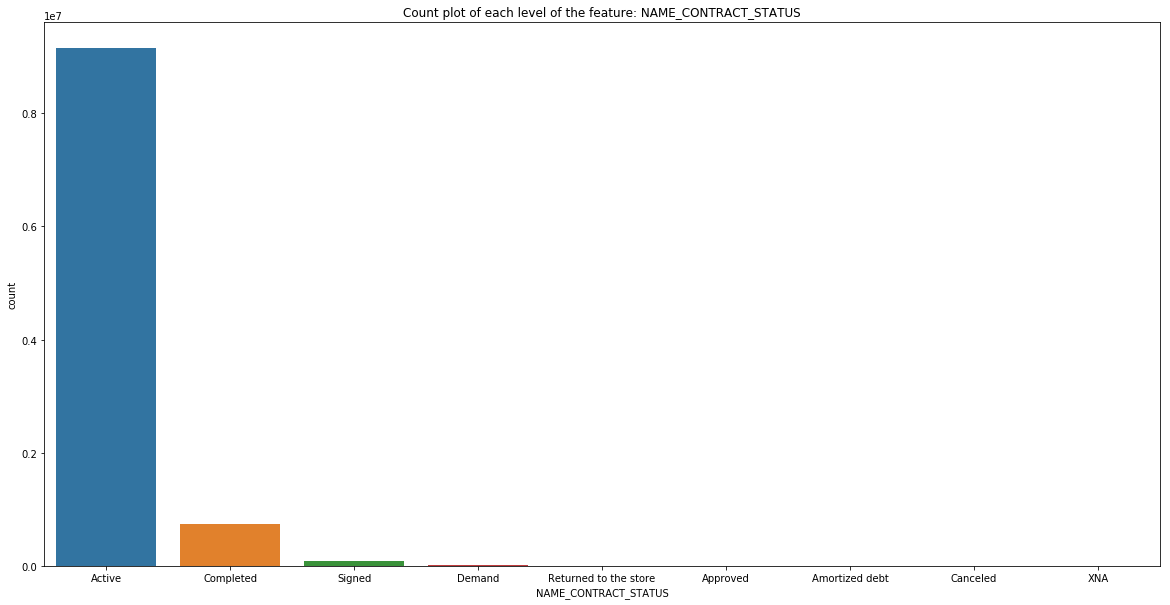

In [27]:
categorical_features_lst = pos_cash_balance_data_df.select_dtypes(["object"]).columns.tolist()

for feature in categorical_features_lst:
    fig, ax = plt.subplots(1, 1, sharex = False, sharey = False, figsize = (20, 10))
    # Plot levels distribution
    if pos_cash_balance_data_df[feature].nunique() < 10:
        sns.countplot(x = pos_cash_balance_data_df[feature], ax = ax, order = pos_cash_balance_data_df[feature].value_counts().index.tolist())
    else:
        sns.countplot(y = pos_cash_balance_data_df[feature], ax = ax, order = pos_cash_balance_data_df[feature].value_counts().index.tolist())
    ax.set_title("Count plot of each level of the feature: " + feature)

This feature seems similar to the one with the same name in credit_card_balance.csv dataset. Maybe there is a connection between them.

Now, let's look at numerical features.

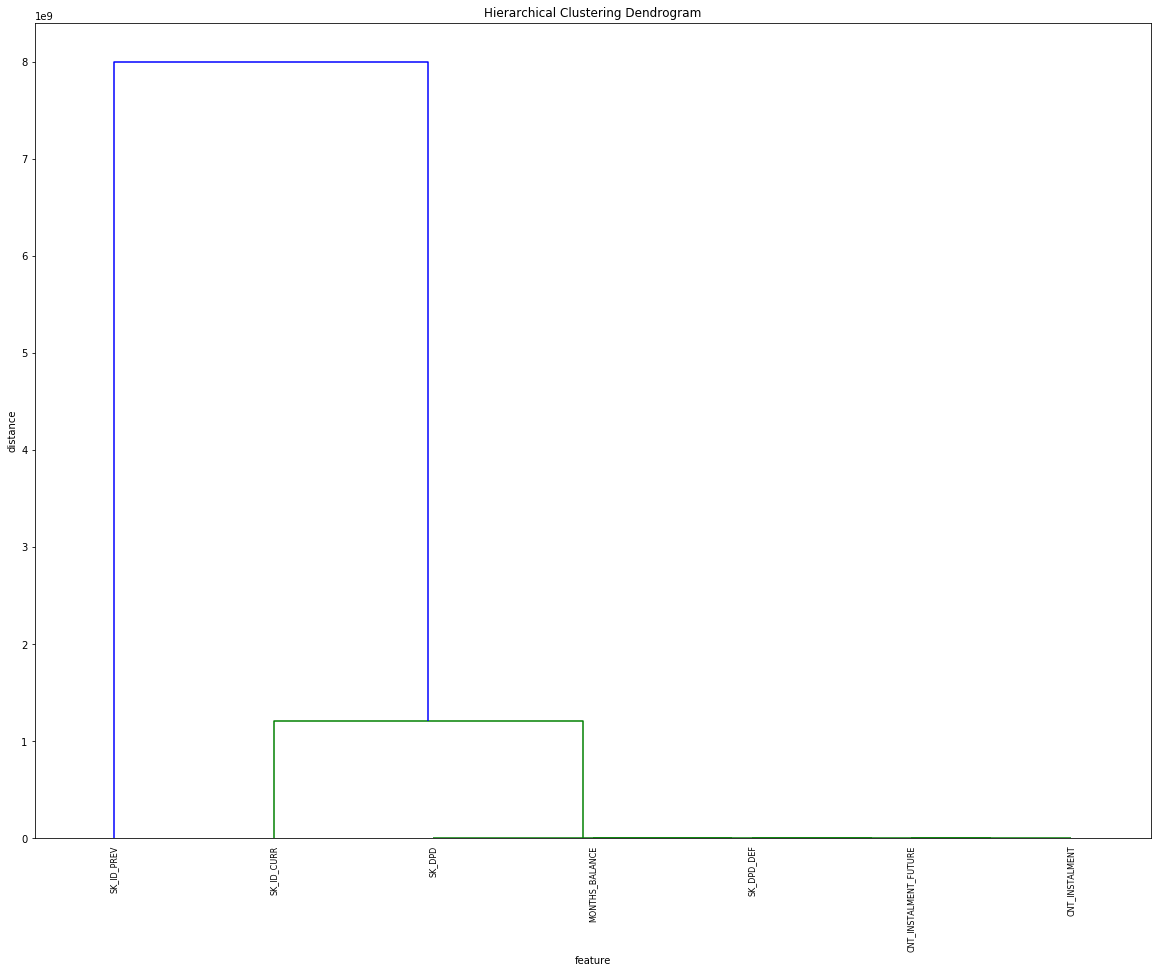

In [28]:
numerical_features_lst = list(set(pos_cash_balance_data_df.columns.tolist()) - set(categorical_features_lst))

# generate the linkage matrix
numerical_features_df = pos_cash_balance_data_df[numerical_features_lst]
numerical_features_df.fillna(-1, inplace = True) # We need to impute missing values before creating the dendrogram
numerical_features_df = numerical_features_df.transpose()
Z = linkage(numerical_features_df, "ward")
plt.figure(figsize = (20, 15))
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("feature")
plt.ylabel("distance")
dend = dendrogram(
    Z,
    leaf_rotation = 90.,  # rotates the x axis labels
    leaf_font_size = 8.,  # font size for the x axis labels
    labels = numerical_features_df.index.tolist()
)

Here, we can see that is we exclude database keys, all features are highly similar.

Text(0.5,1,'Correlation plot between numerical features')

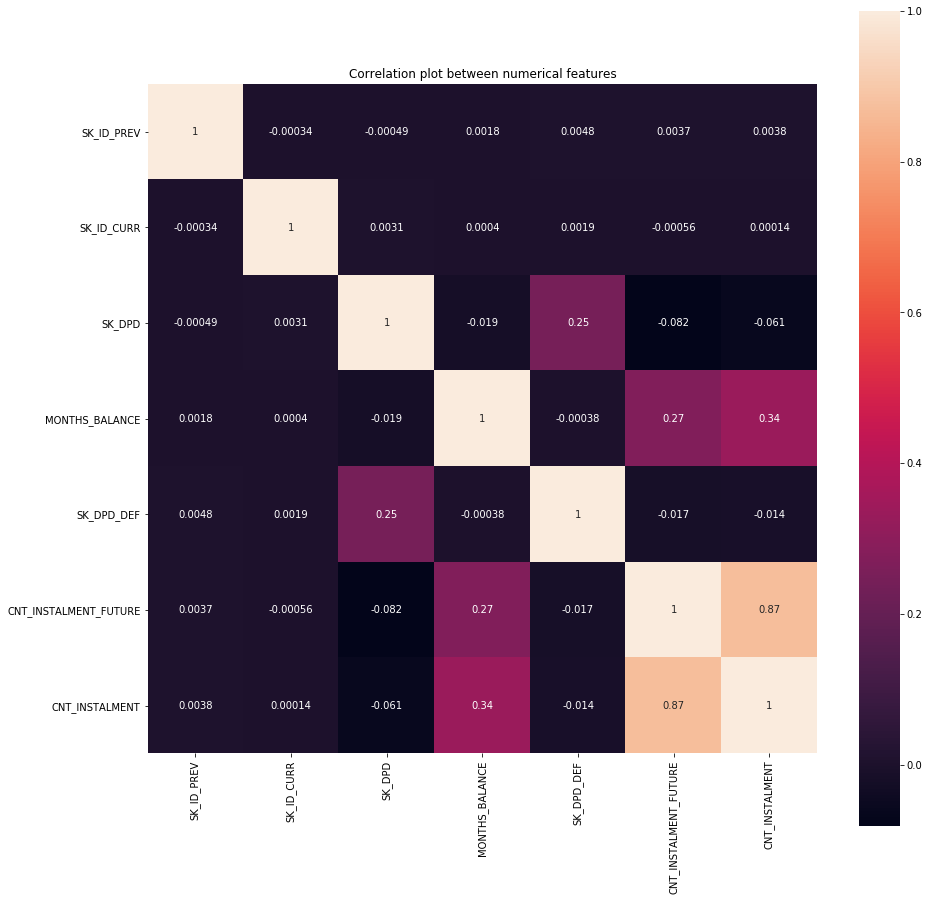

In [29]:
plt.figure(figsize = (15, 15))
sns.heatmap(pos_cash_balance_data_df[dend["ivl"]].corr(), annot = True, square = True)
plt.title("Correlation plot between numerical features")

Here, we can see that *CNT_INSTALMENT* and *CNT_INTSALMENT_FUTURE* are highly correlated. 

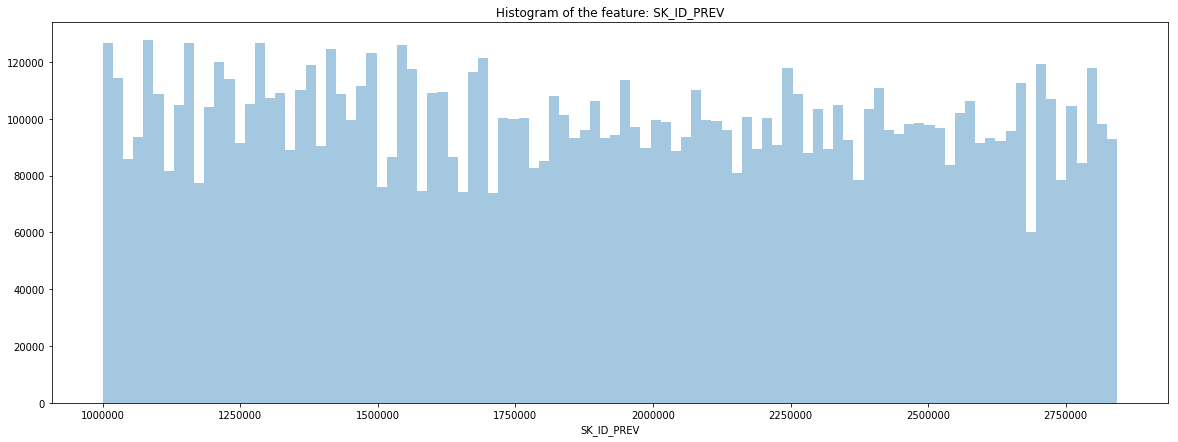

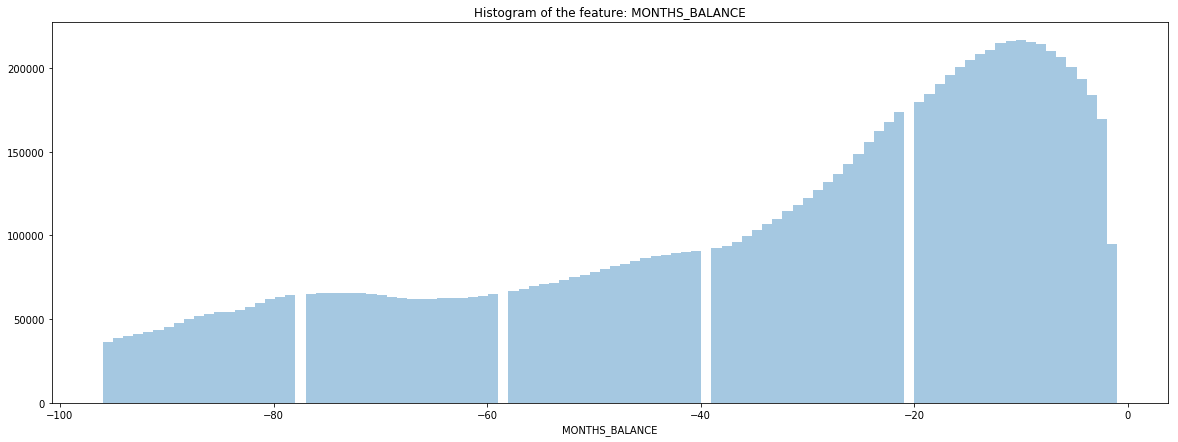

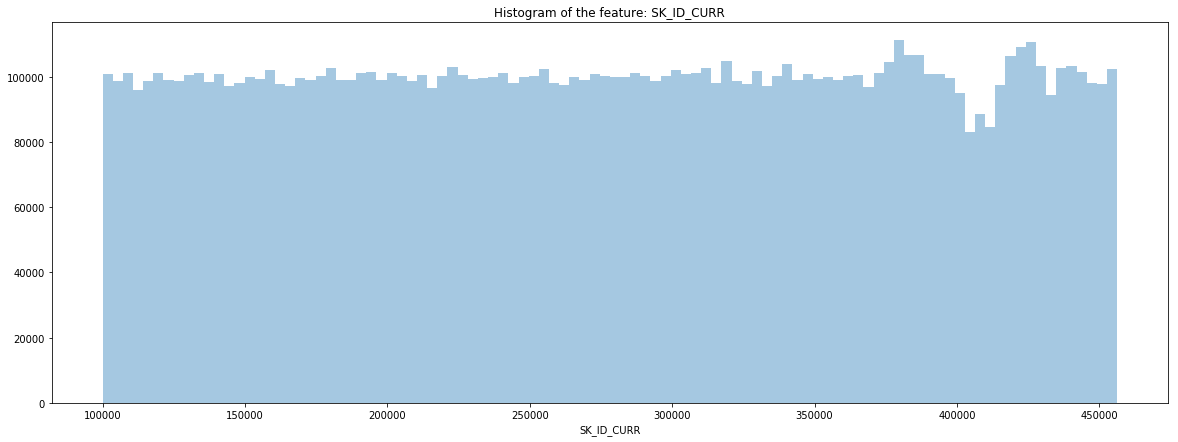

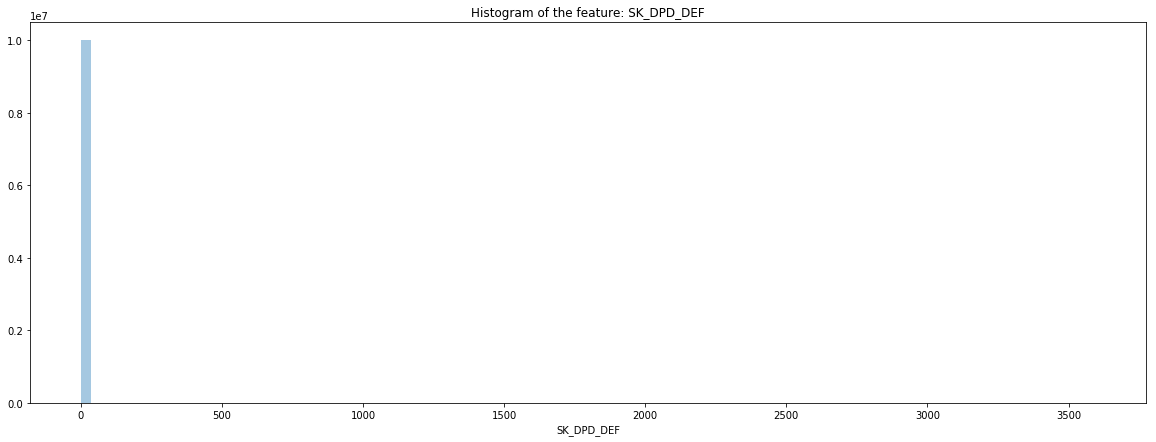

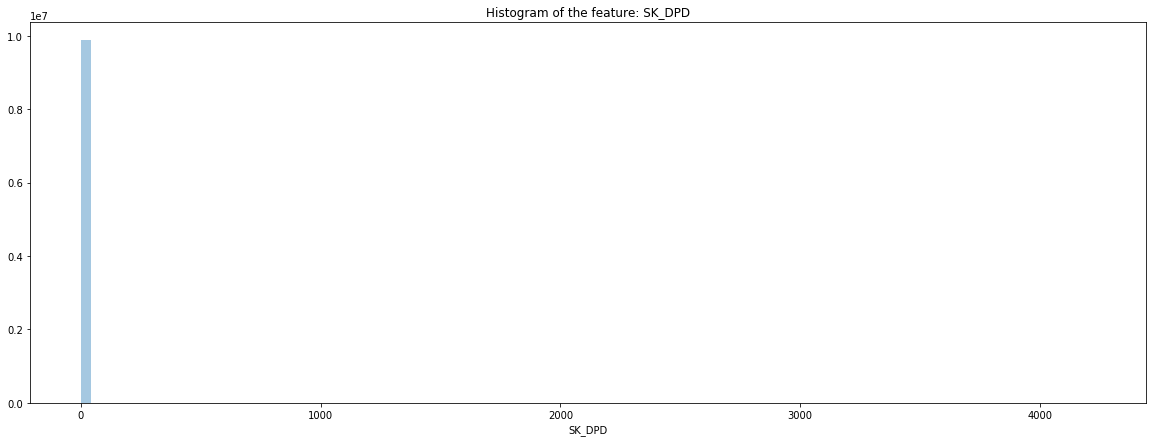

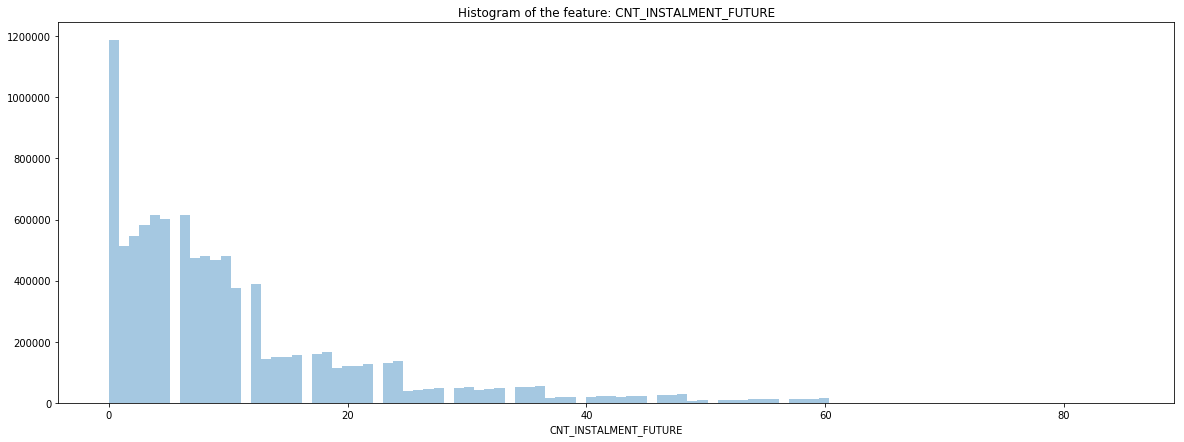

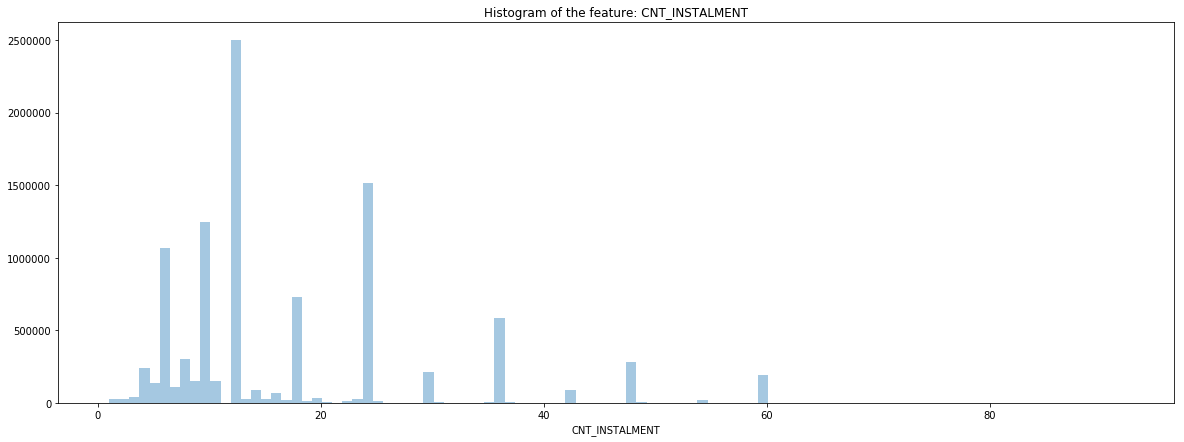

In [30]:
for feature in numerical_features_lst:
    fig, ax = plt.subplots(1, 1, sharex = False, sharey = False, figsize = (20, 7))
    
    # Plot feature distribution
    sns.distplot(pos_cash_balance_data_df[feature].dropna(), kde = False, bins = 100, ax = ax)
    ax.set_title("Histogram of the feature: " + feature)

Here we can see lots of outliers in the features and high skewness. There are also missing bins in *MONTHS_BALANCE*. It will be interesting to see if there is a connection between all features named *MONTHS_BALANCE*.

Now, let's look at missing values.

Text(0.5,1,'Percentage of missing values in the pos cash balance data')

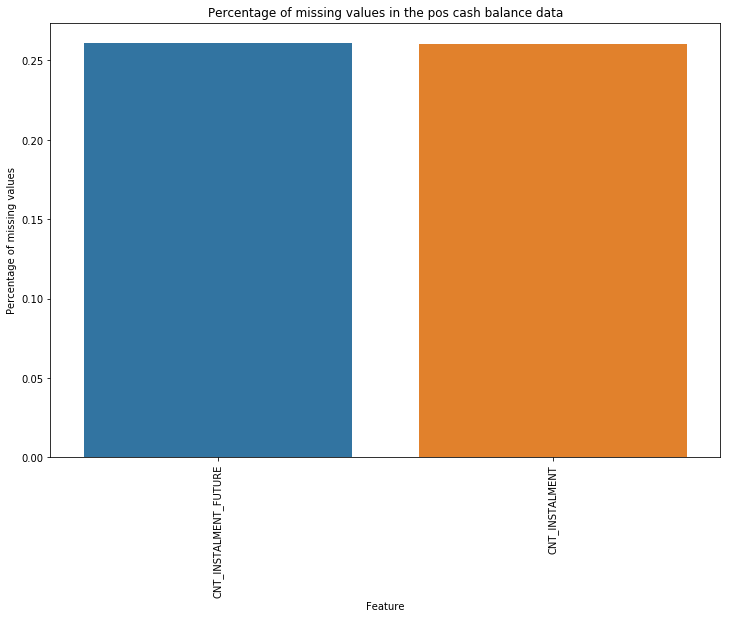

In [31]:
missing_values_sr = pos_cash_balance_data_df.isnull().sum()
missing_values_df = missing_values_sr.loc[missing_values_sr > 0].sort_values(ascending = False).reset_index()
missing_values_df.columns = ["Feature", "Number of missing values"]
missing_values_df["Percentage of missing values"] = (missing_values_df["Number of missing values"] / pos_cash_balance_data_df.shape[0]) * 100

sns.barplot(x = missing_values_df["Feature"], y = missing_values_df["Percentage of missing values"])
plt.xticks(rotation = 90)
plt.title("Percentage of missing values in the pos cash balance data")

Here, only two features have a missing values. The amount of missing values is very small (0.25%) and identical for both features.

### 3.8. Looking at previous_application.csv

This dataset contains data about all previous applications for Home Credit loans of clients who have loans in our sample.

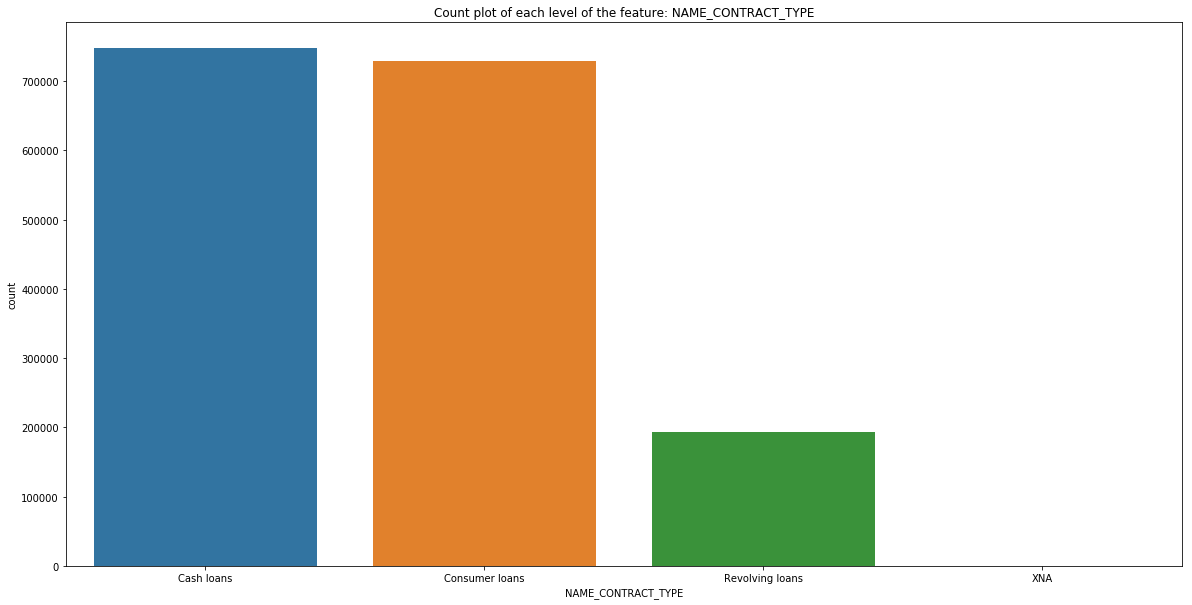

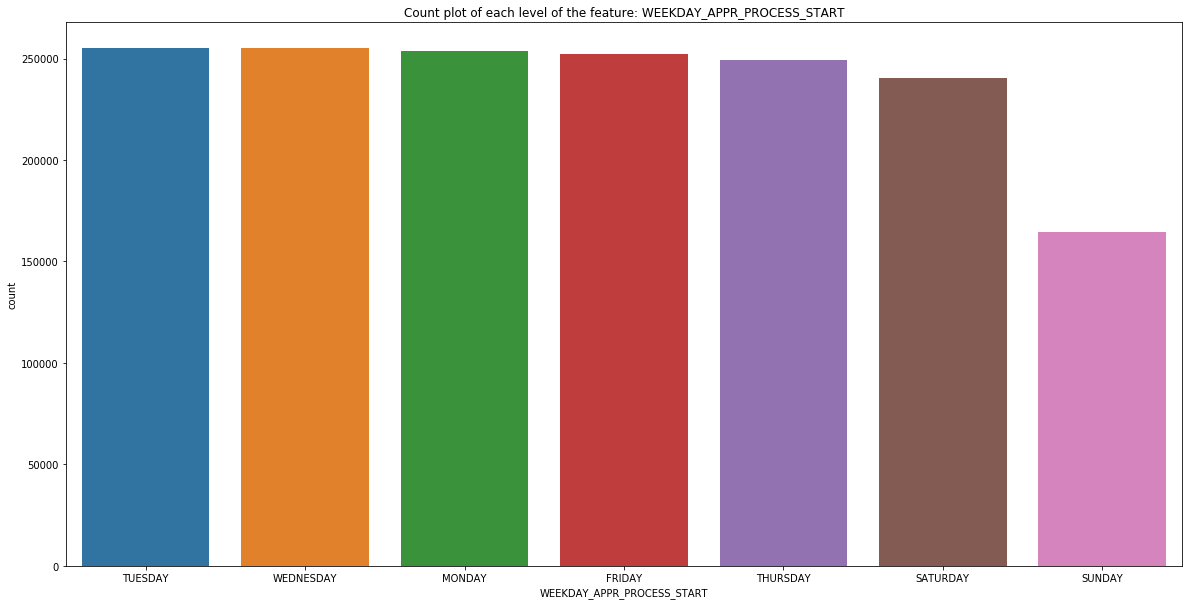

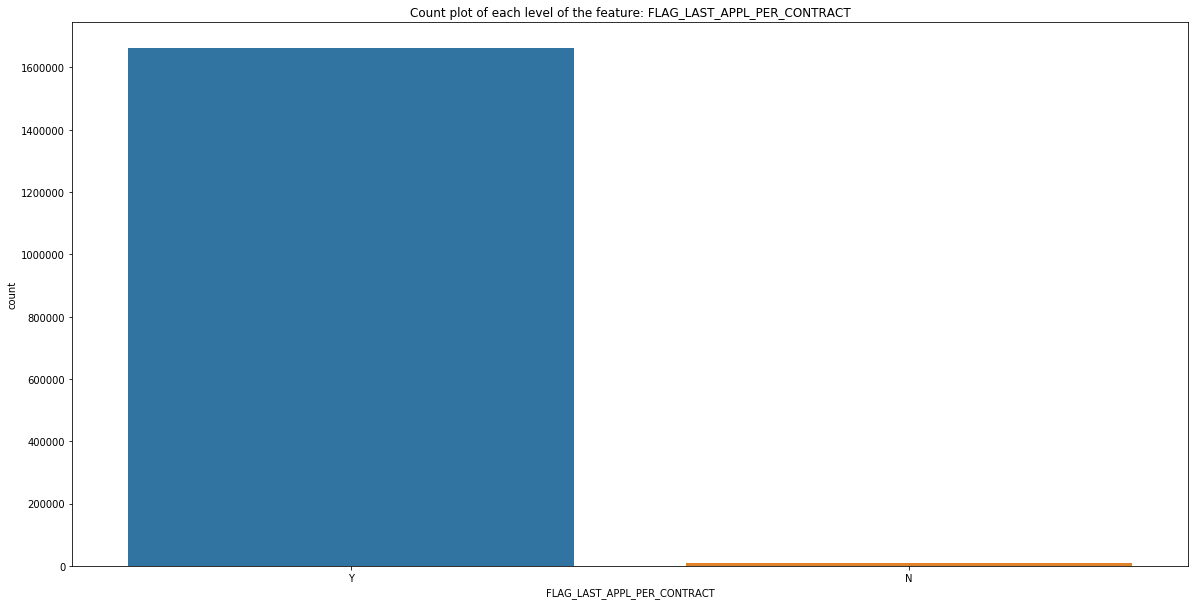

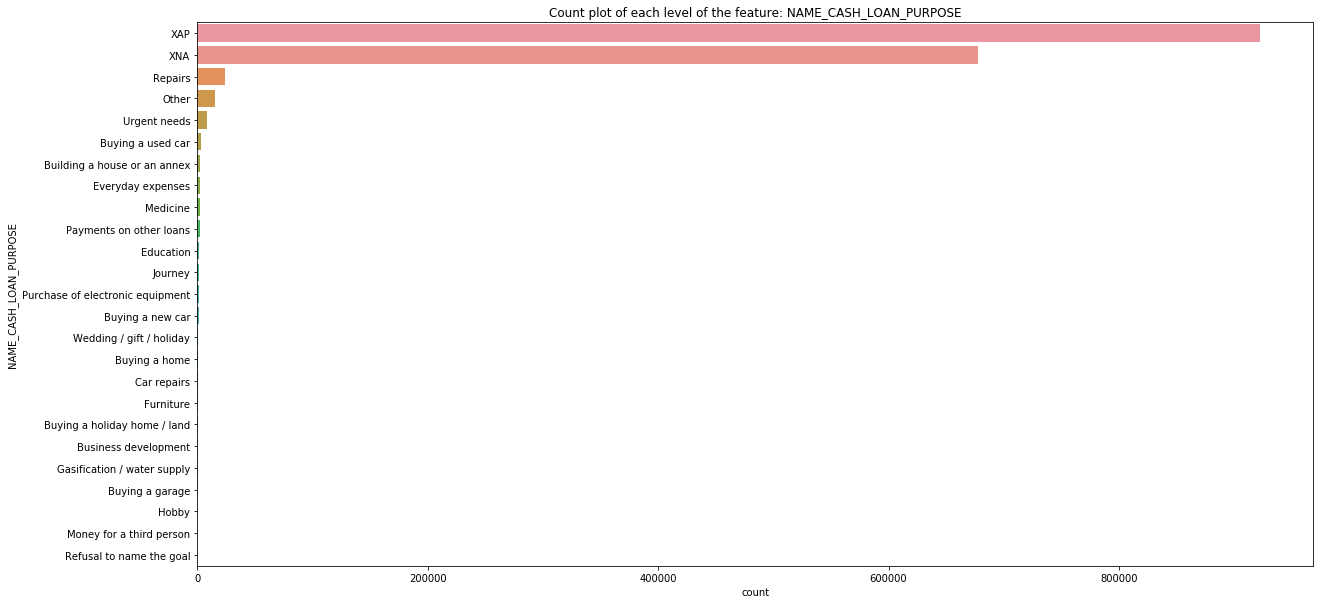

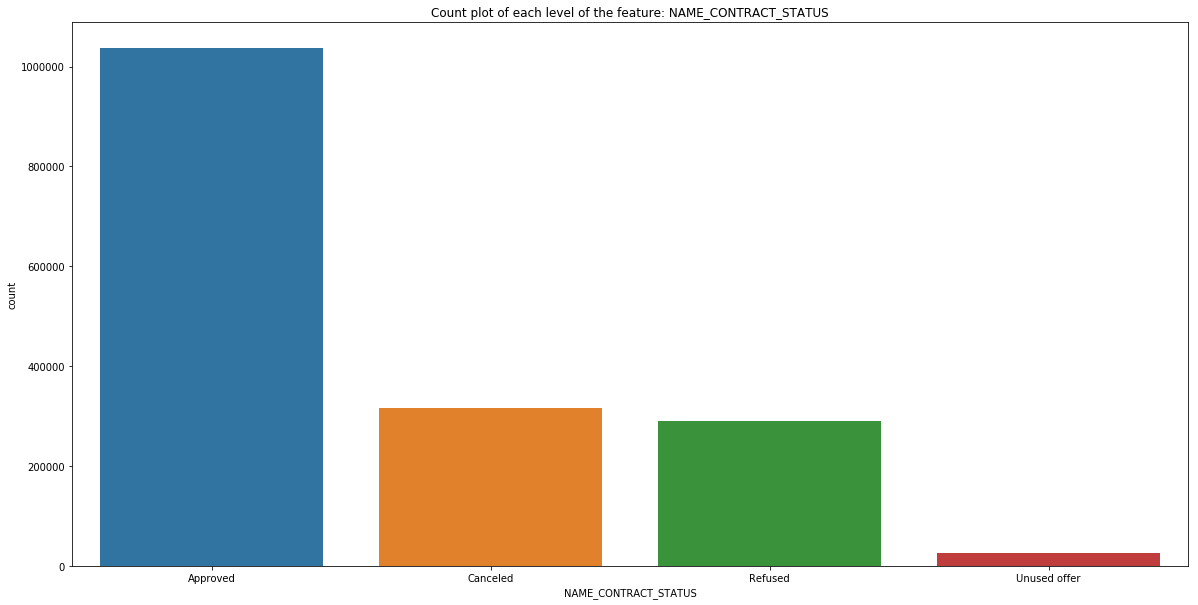

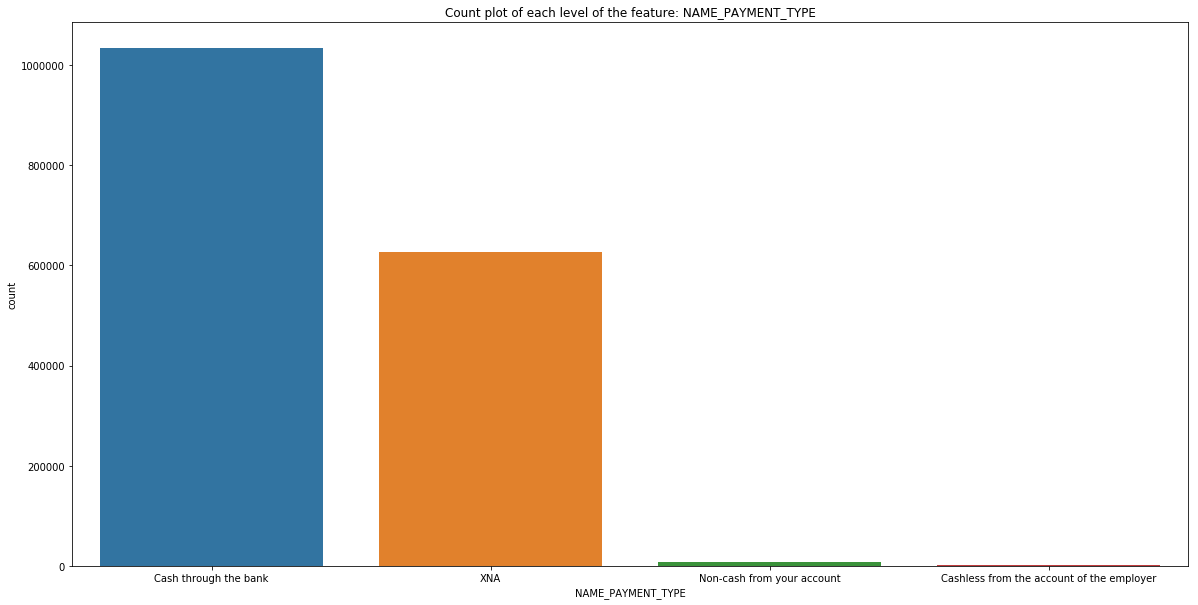

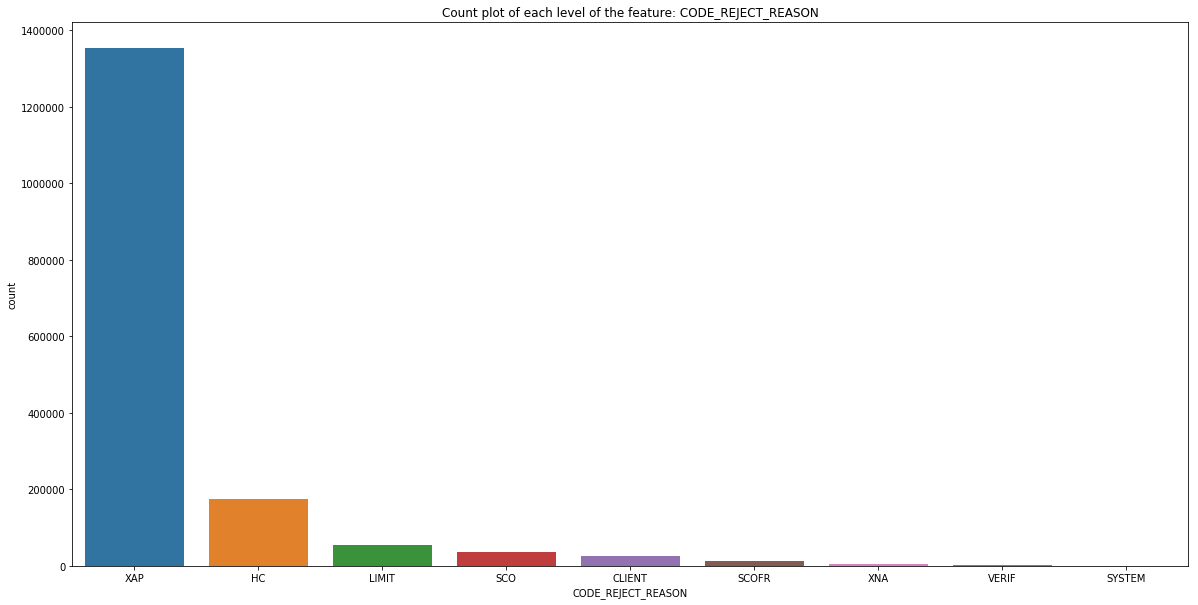

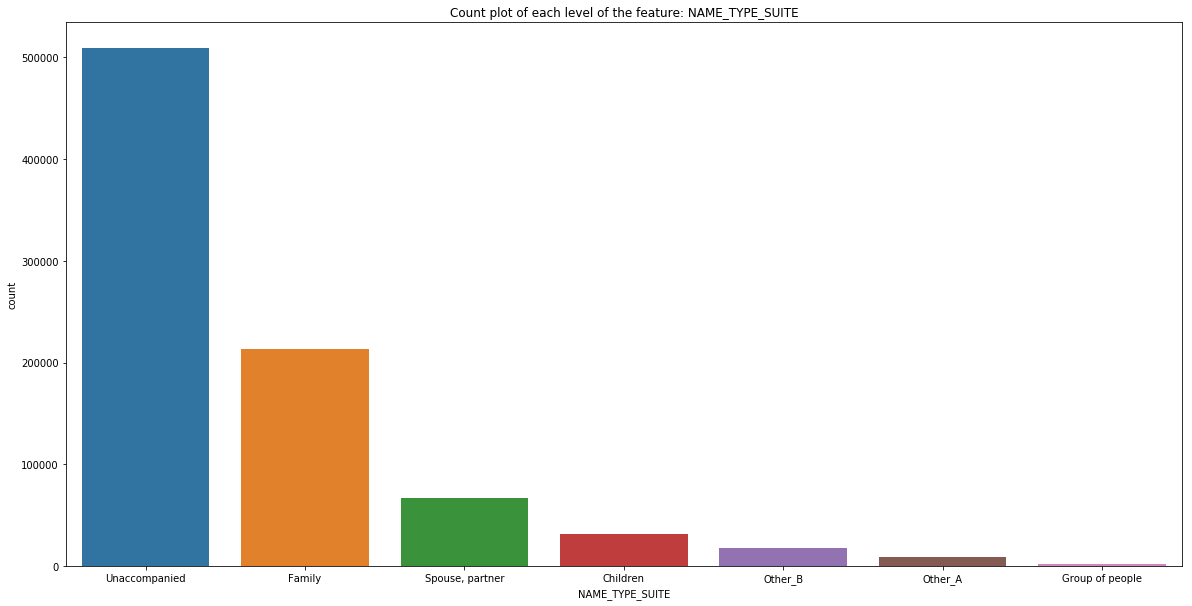

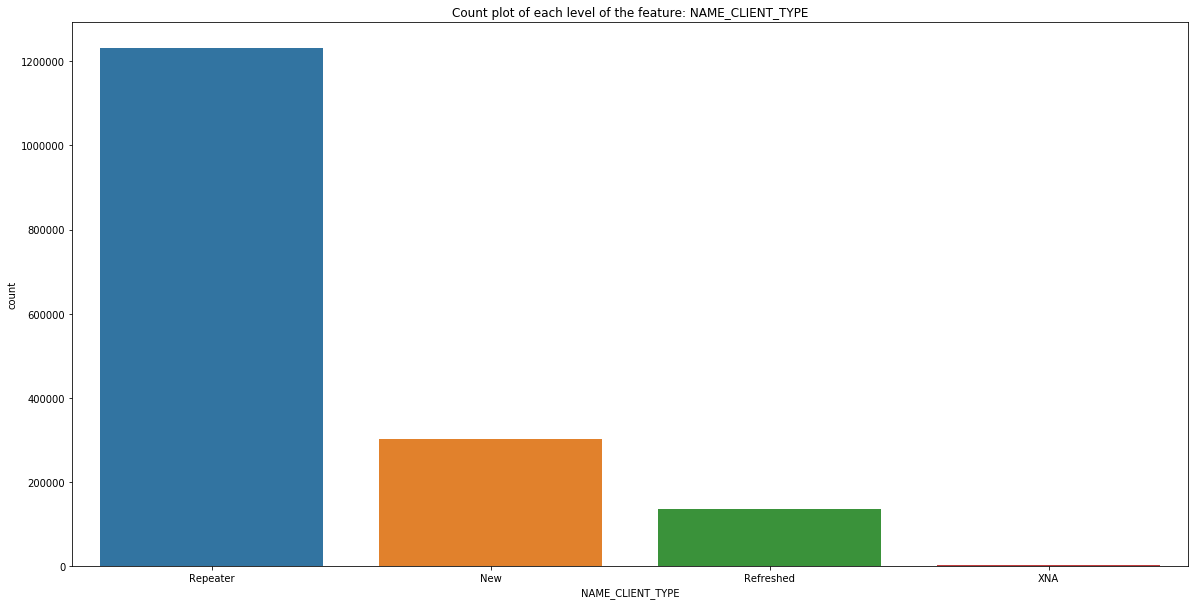

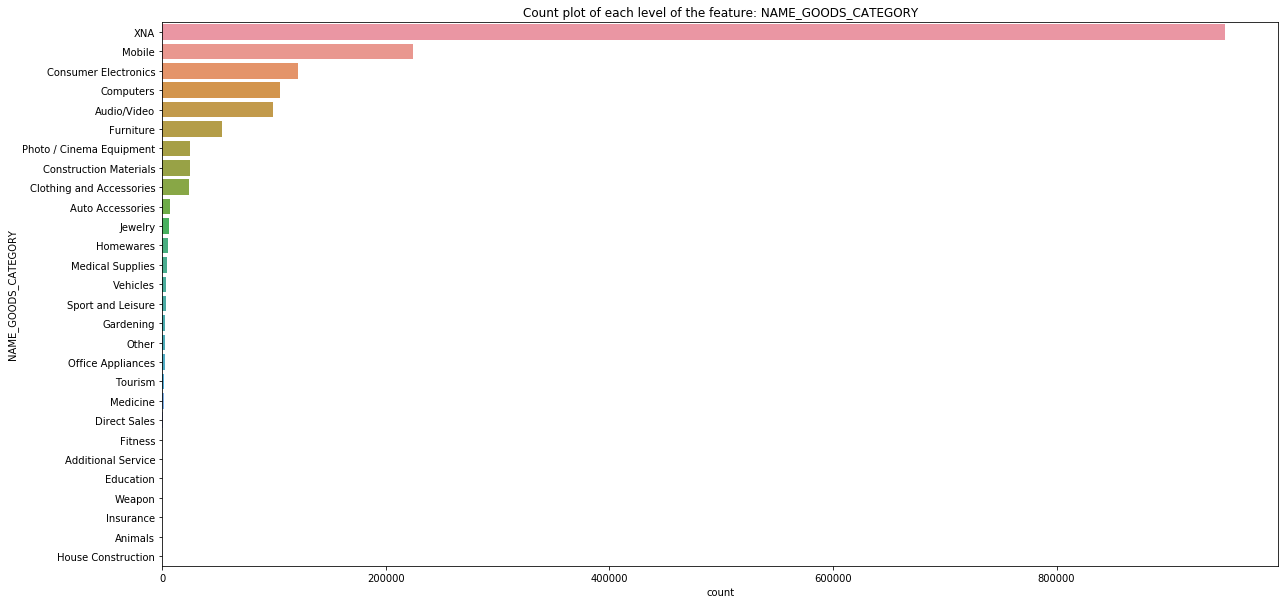

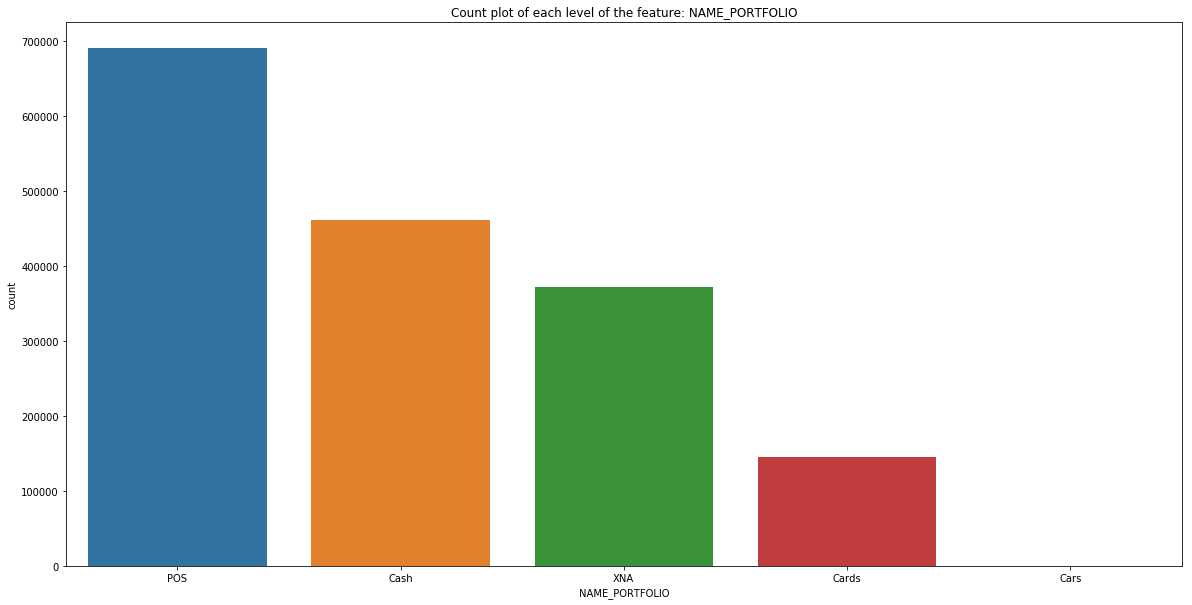

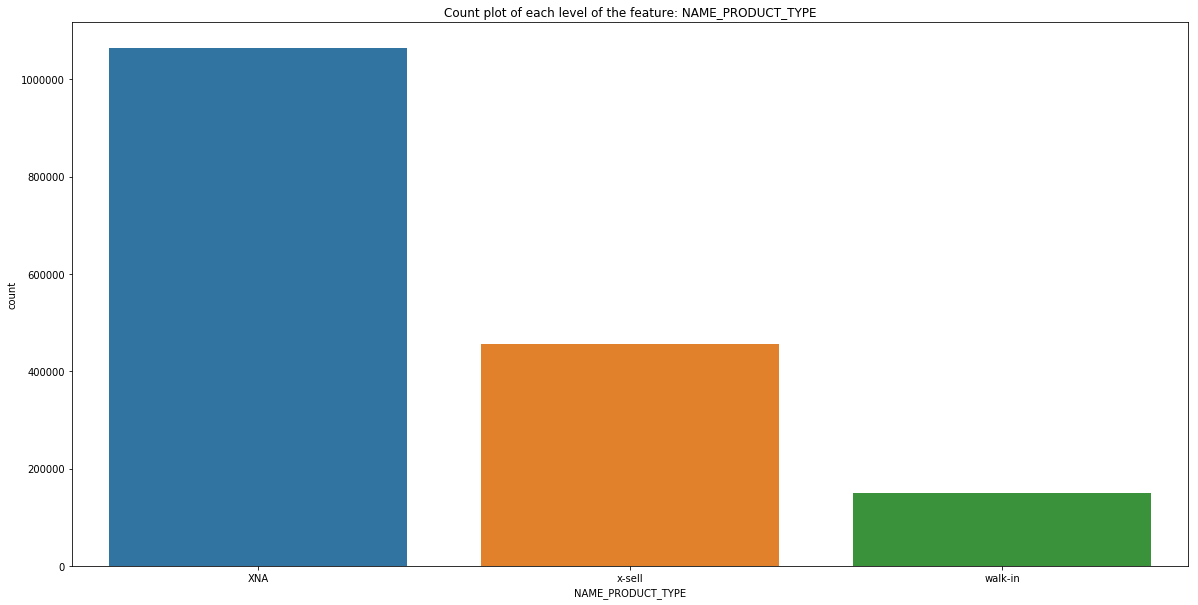

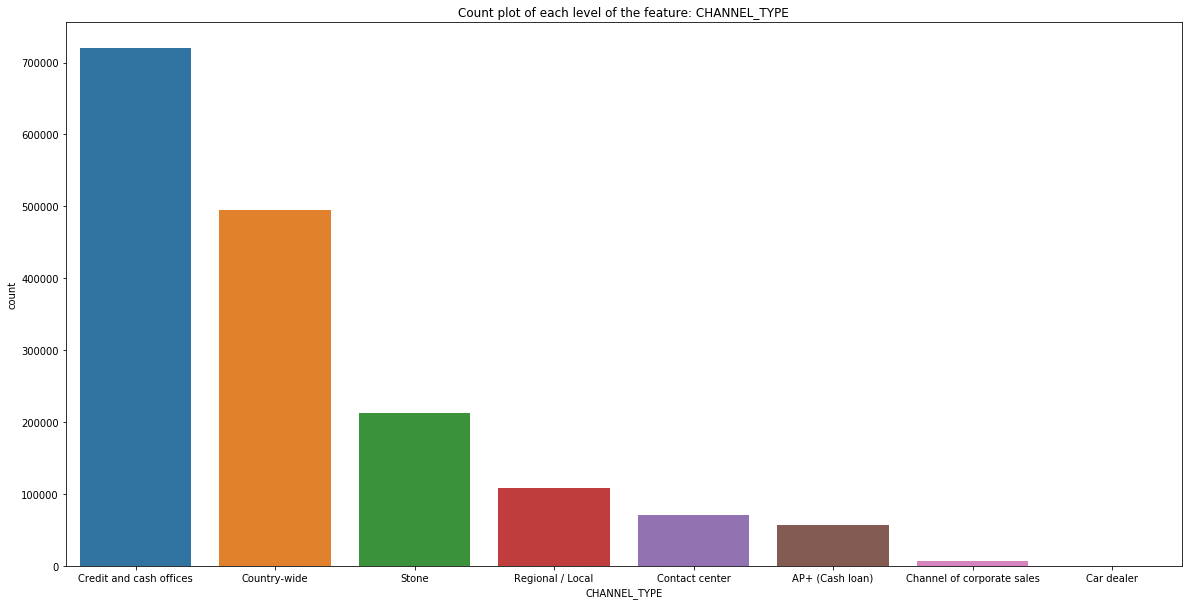

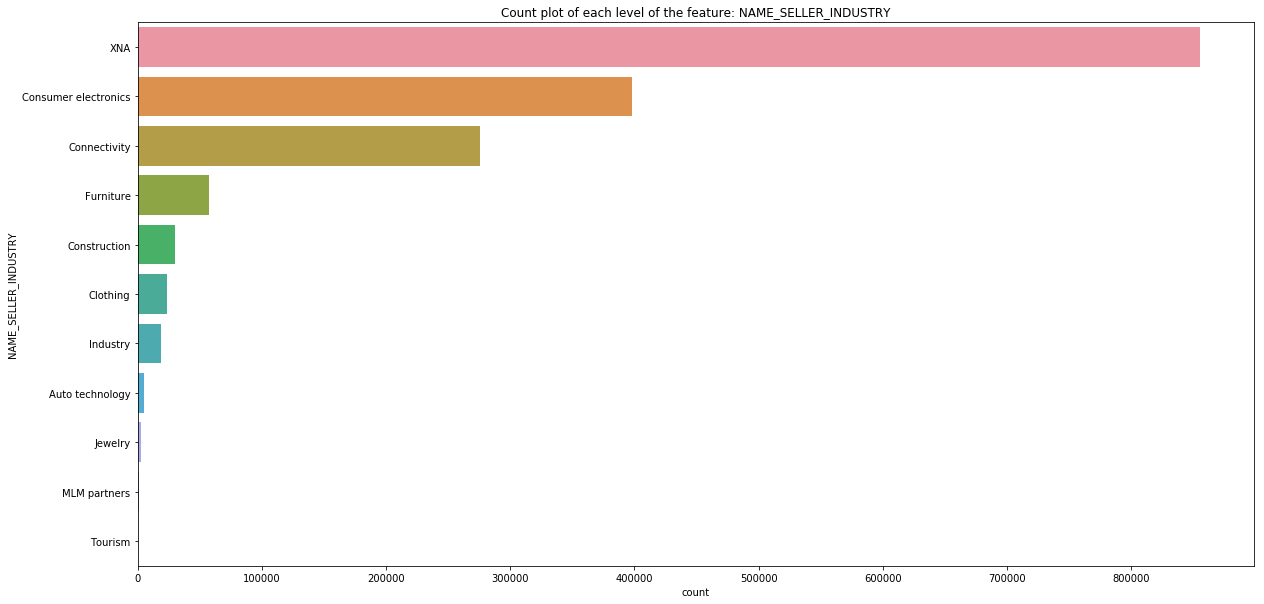

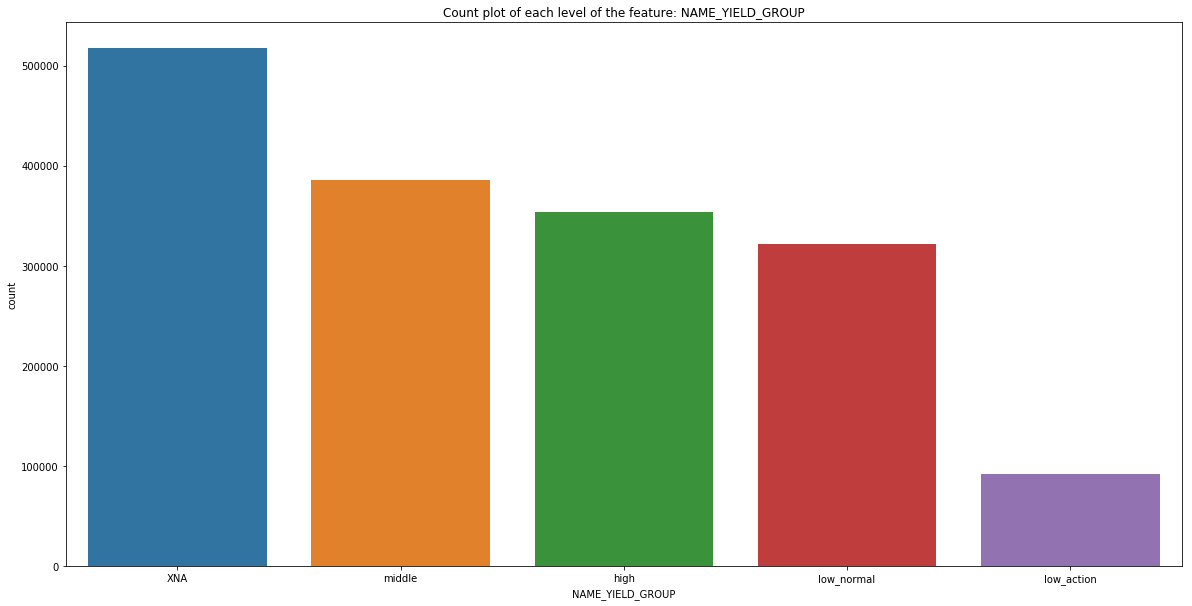

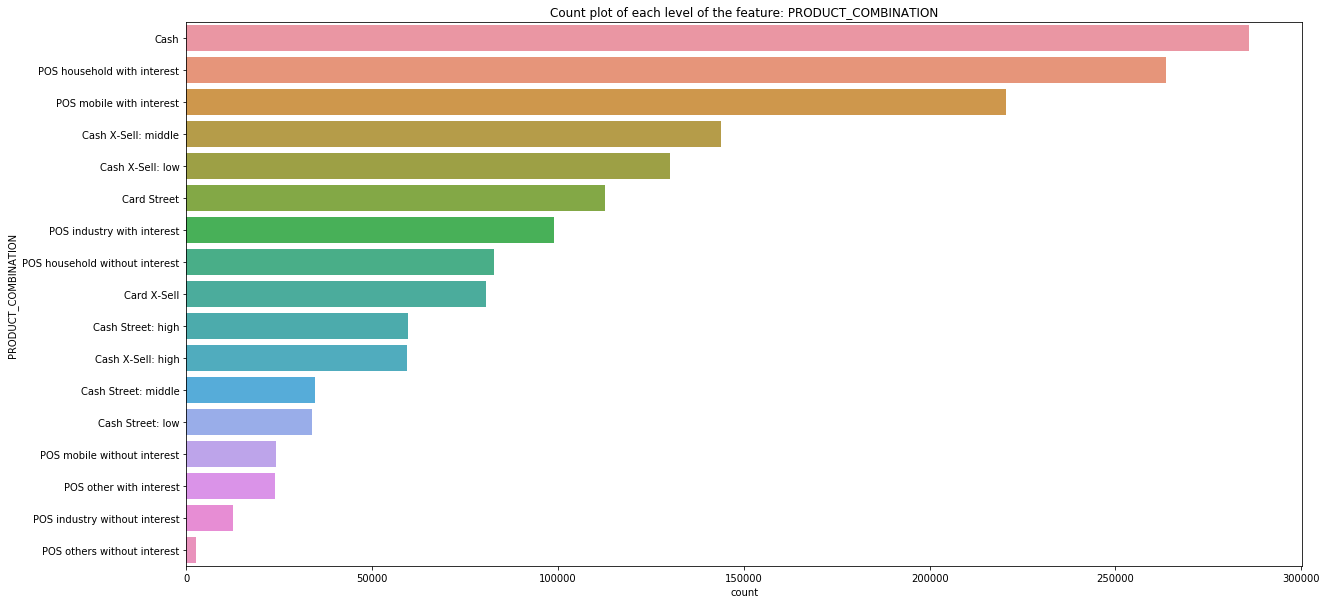

In [32]:
categorical_features_lst = previous_application_data_df.select_dtypes(["object"]).columns.tolist()

for feature in categorical_features_lst:
    fig, ax = plt.subplots(1, 1, sharex = False, sharey = False, figsize = (20, 10))
    # Plot levels distribution
    if previous_application_data_df[feature].nunique() < 10:
        sns.countplot(x = previous_application_data_df[feature], ax = ax, order = previous_application_data_df[feature].value_counts().index.tolist())
    else:
        sns.countplot(y = previous_application_data_df[feature], ax = ax, order = previous_application_data_df[feature].value_counts().index.tolist())
    ax.set_title("Count plot of each level of the feature: " + feature)

We can get useful insights from the plots above:
 - Most of the previous loans were cash loans or consumer loans.
 - For *NAME_CASH_LOAN_PURPOSE*, the two highest common levels are not documented in the data description. We'll need to figure out what "XAP" and "XNA" means by ourselves.
 - We can see that if we remove "XNA" / "XAP" levels from the features, goods that clients buy are mostly electronic devices like computers or smartphones. Then comes furniture and building materials.

Now, let's look at numerical features.

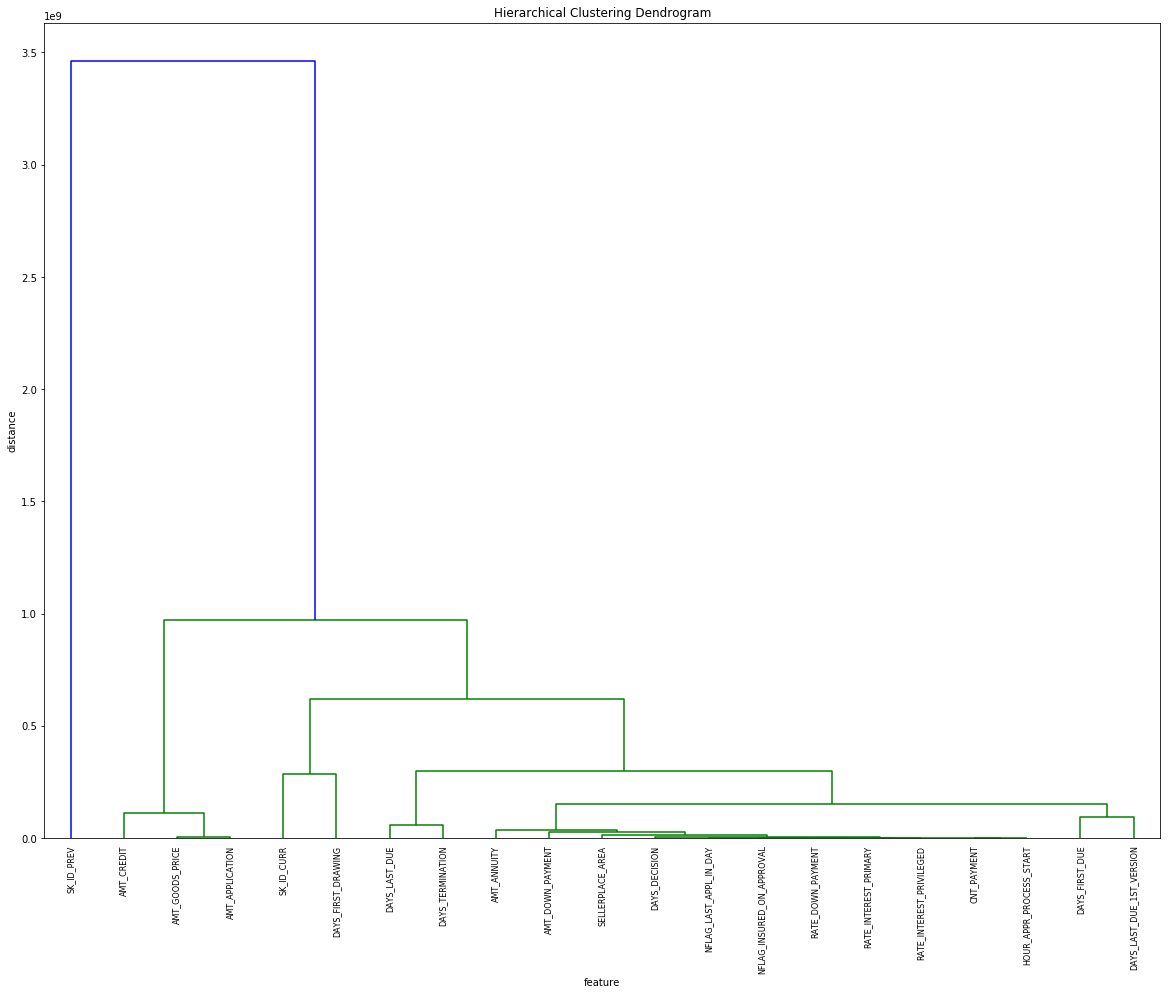

In [33]:
numerical_features_lst = list(set(previous_application_data_df.columns.tolist()) - set(categorical_features_lst))

# generate the linkage matrix
numerical_features_df = previous_application_data_df[numerical_features_lst]
numerical_features_df.fillna(-1, inplace = True) # We need to impute missing values before creating the dendrogram
numerical_features_df = numerical_features_df.transpose()
Z = linkage(numerical_features_df, "ward")
plt.figure(figsize = (20, 15))
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("feature")
plt.ylabel("distance")
dend = dendrogram(
    Z,
    leaf_rotation = 90.,  # rotates the x axis labels
    leaf_font_size = 8.,  # font size for the x axis labels
    labels = numerical_features_df.index.tolist()
)

Here, we can see that is we exclude database keys, we can see several features clusters.

Text(0.5,1,'Correlation plot between numerical features')

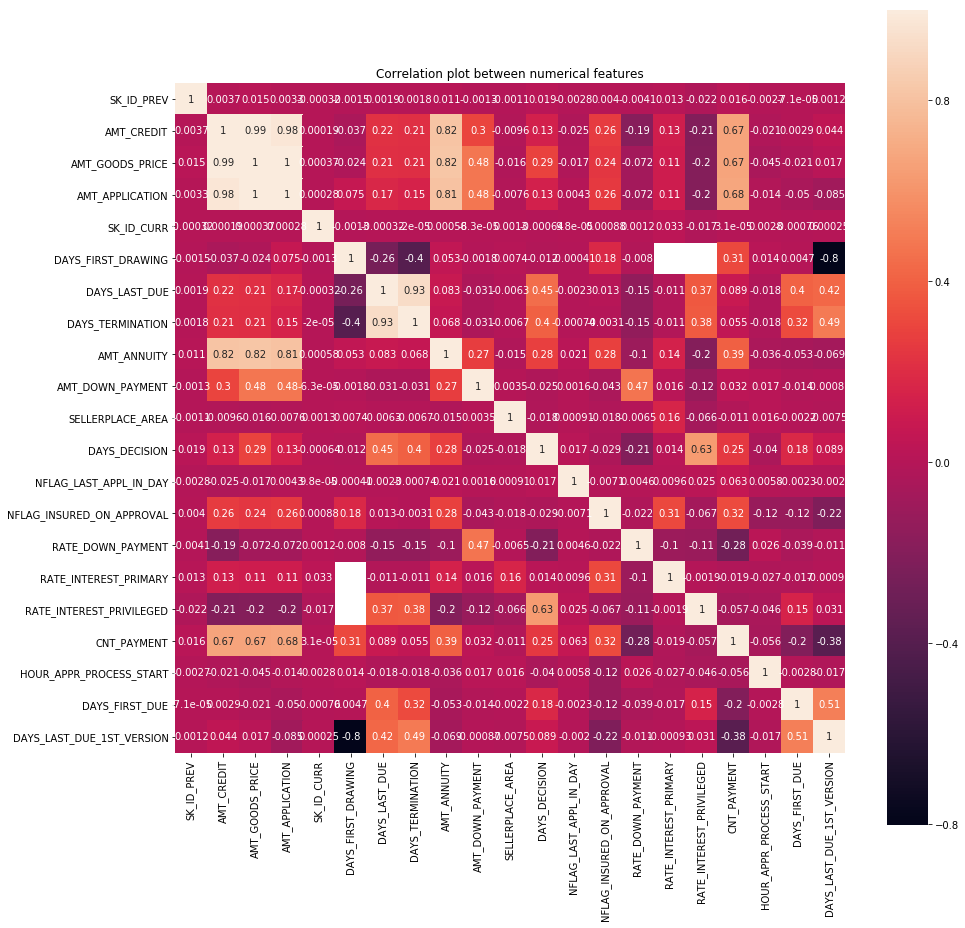

In [34]:
plt.figure(figsize = (15, 15))
sns.heatmap(previous_application_data_df[dend["ivl"]].corr(), annot = True, square = True)
plt.title("Correlation plot between numerical features")

Here, we can see several interesting things:
 - Some features are duplicated: *AMT_GOODS_PRICE* and *AMT_APPLICATION*. Those two features are highly correlated with *AMT_CREDIT*.
 - We can see two white rectangles. We'll need to dig into them later to figure out what they mean.
 - Some features are highly correlated, either positively or negatively.

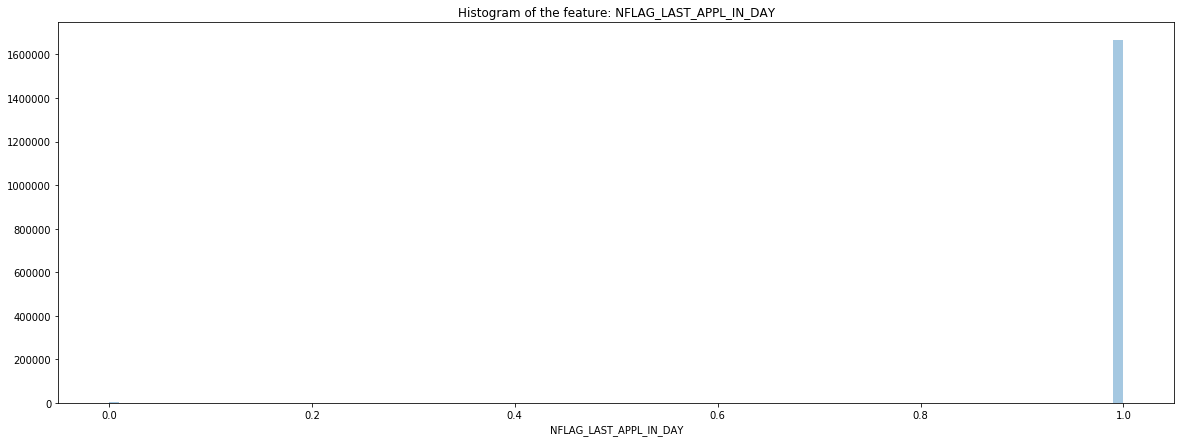

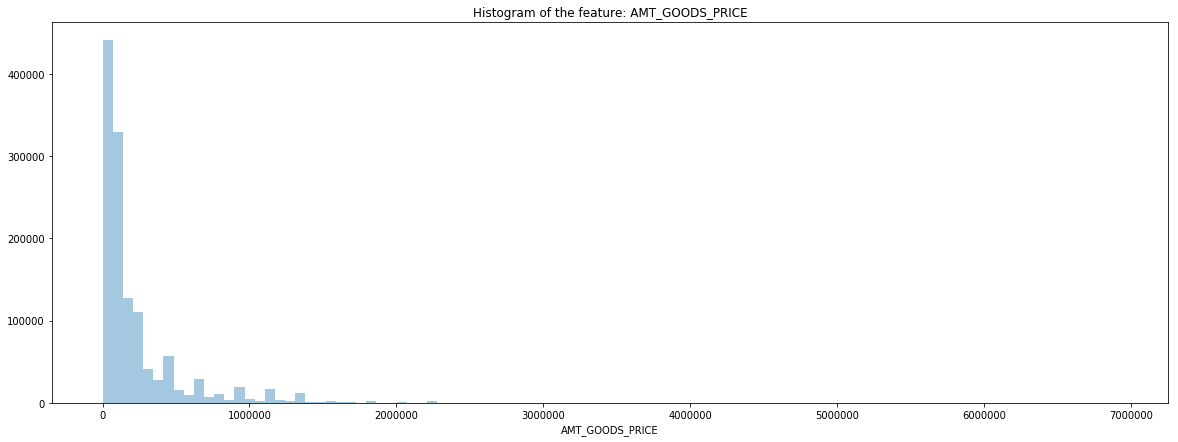

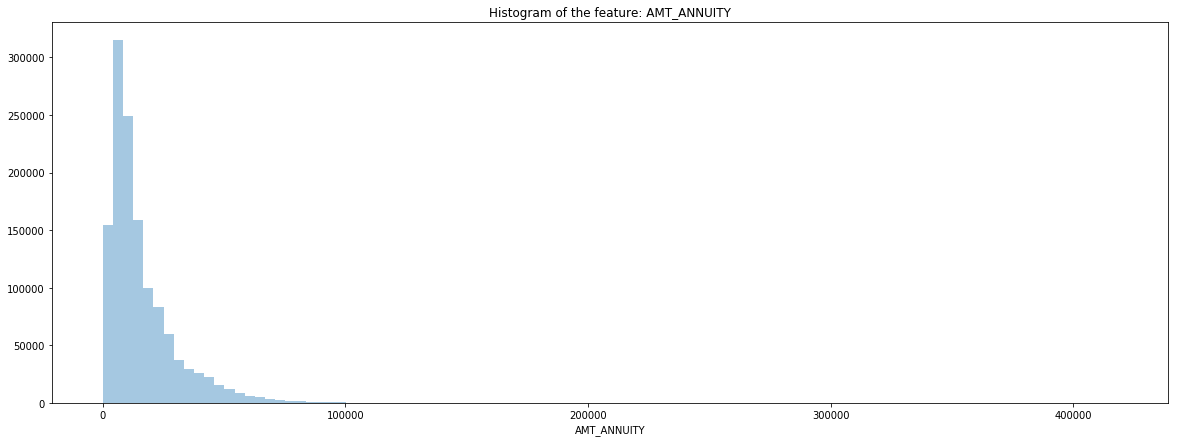

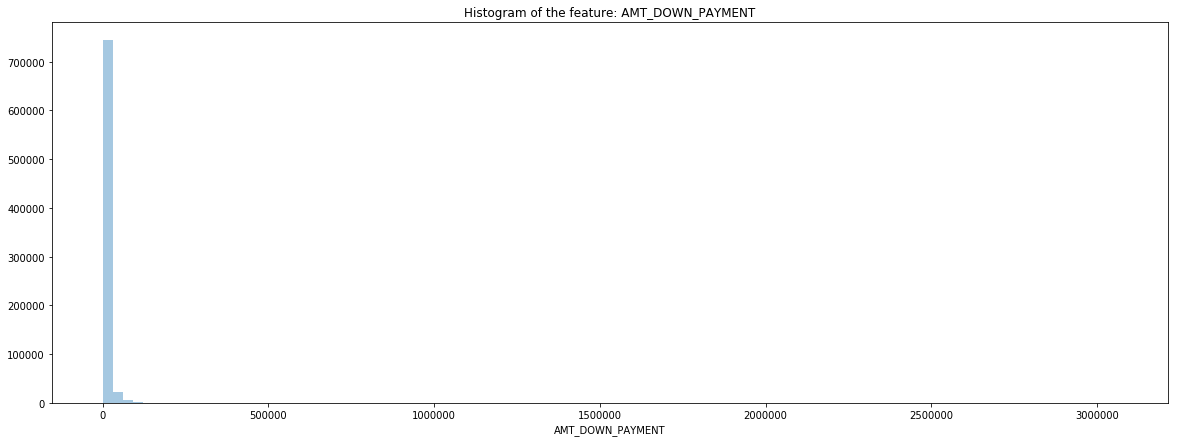

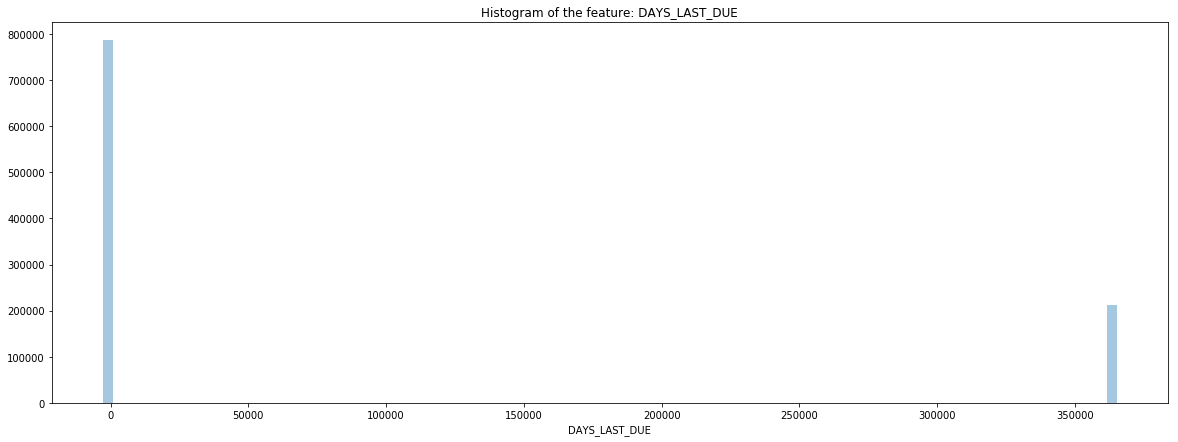

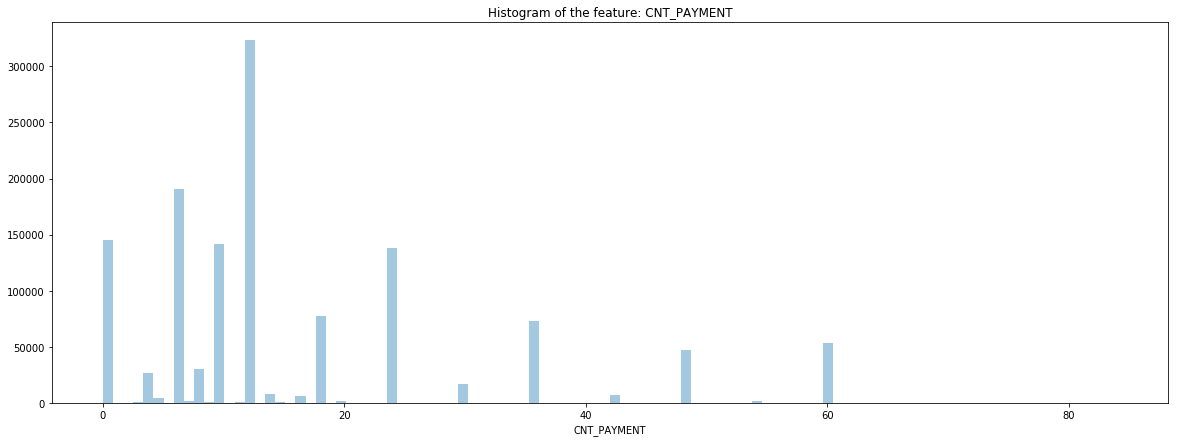

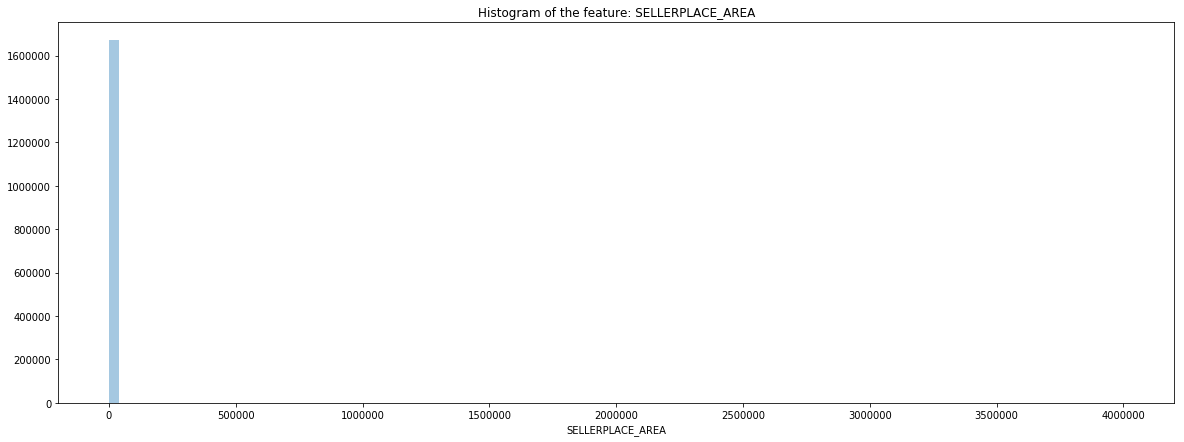

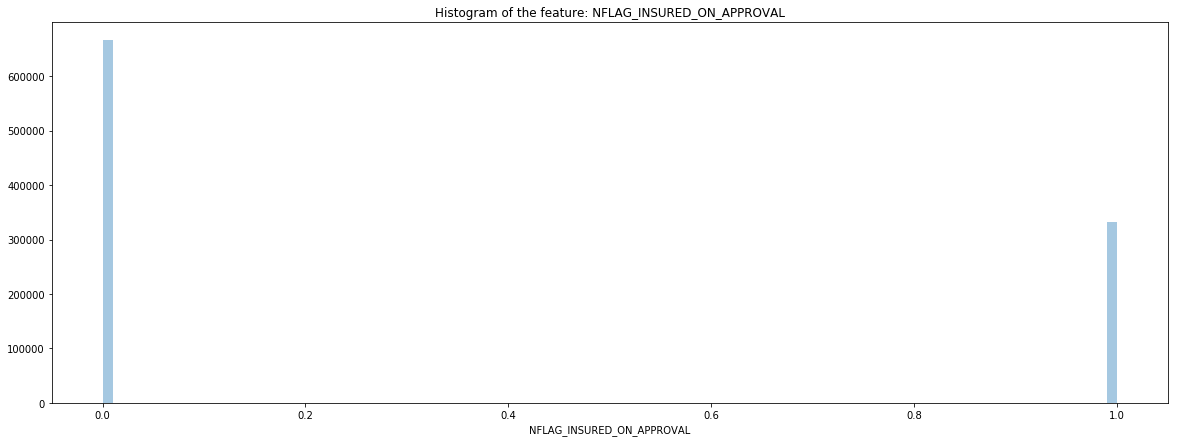

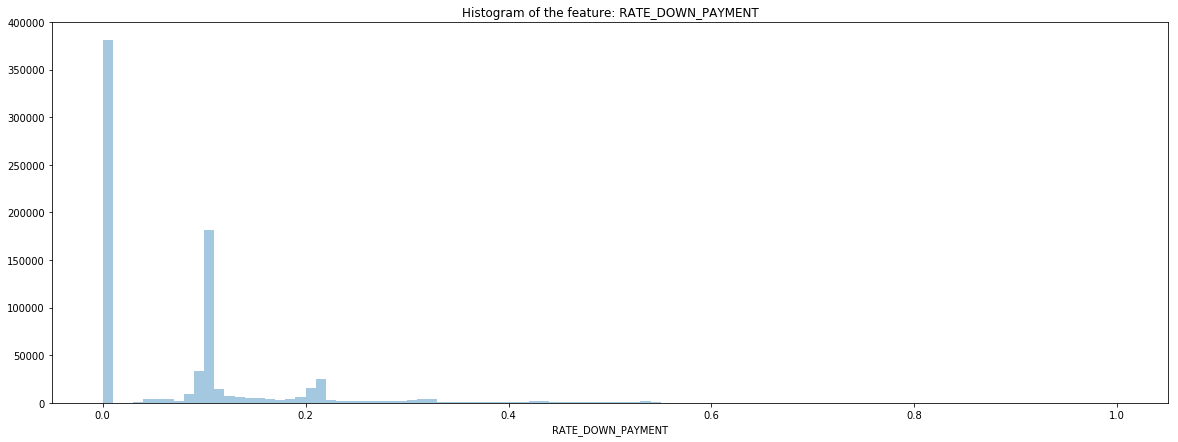

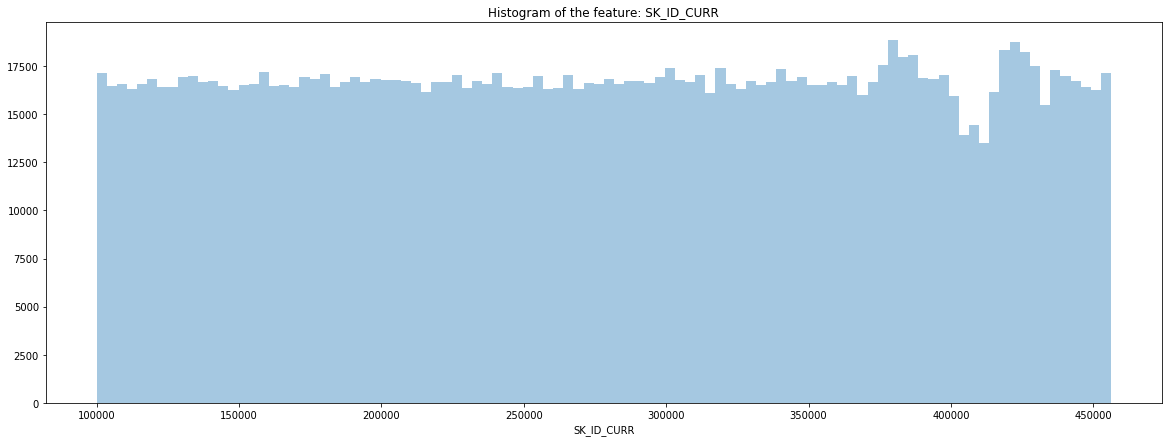

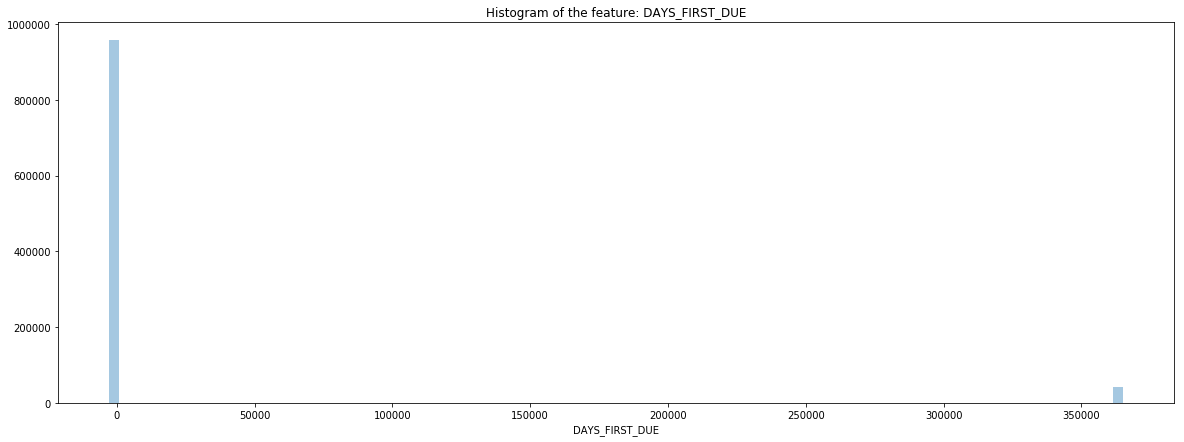

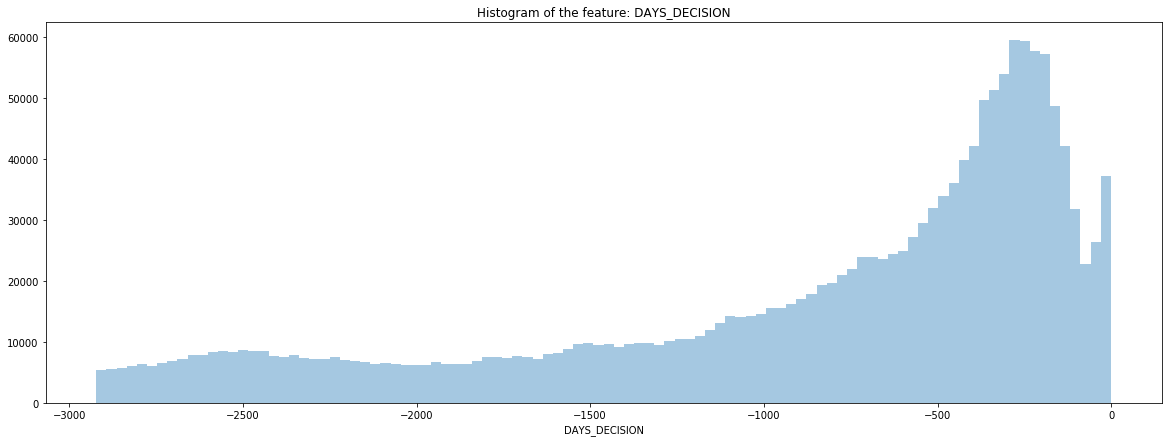

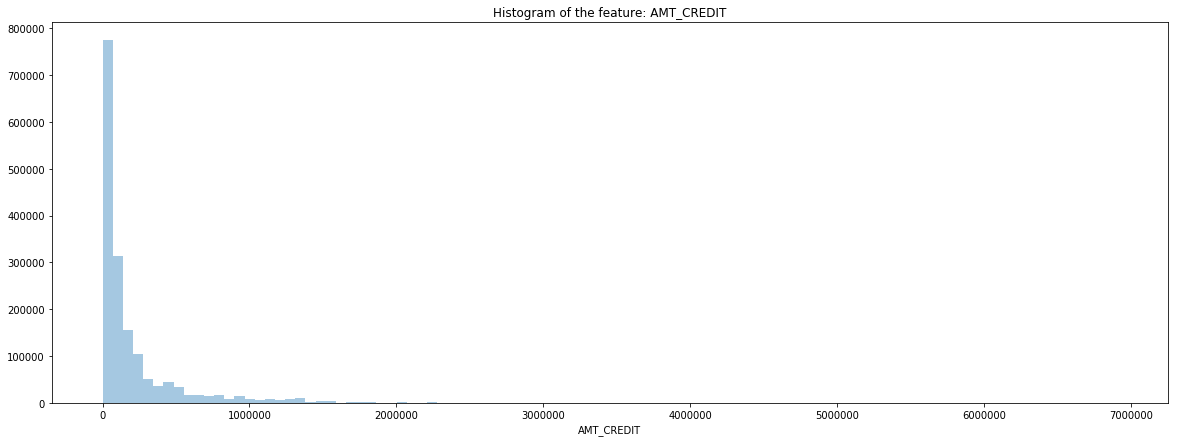

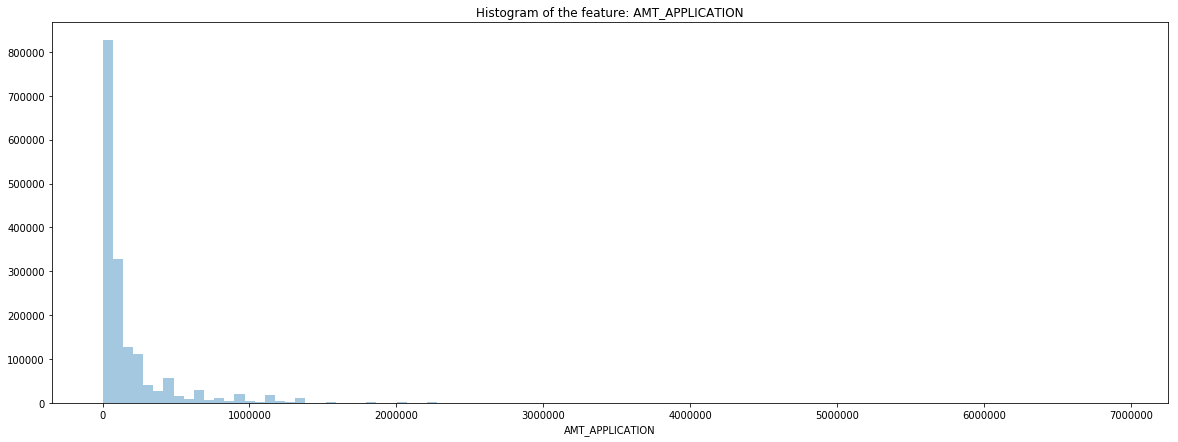

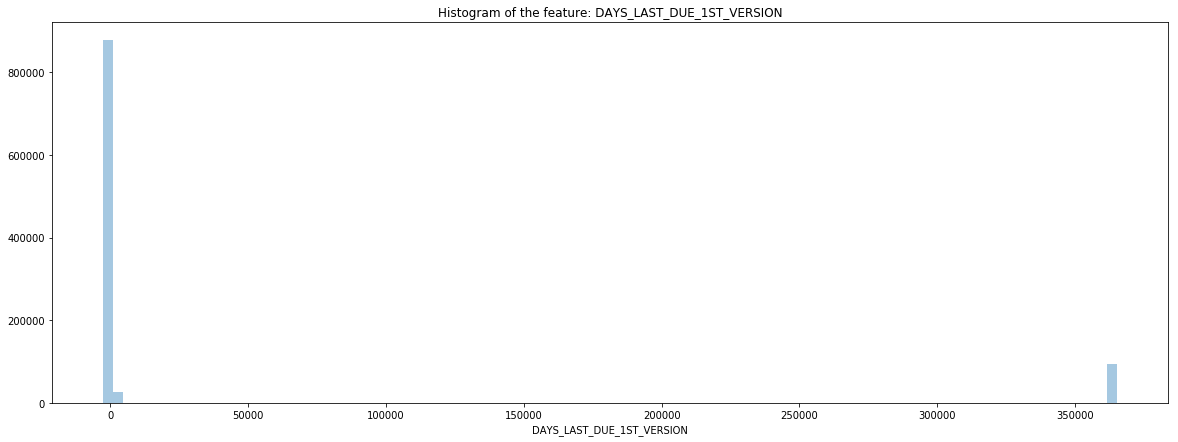

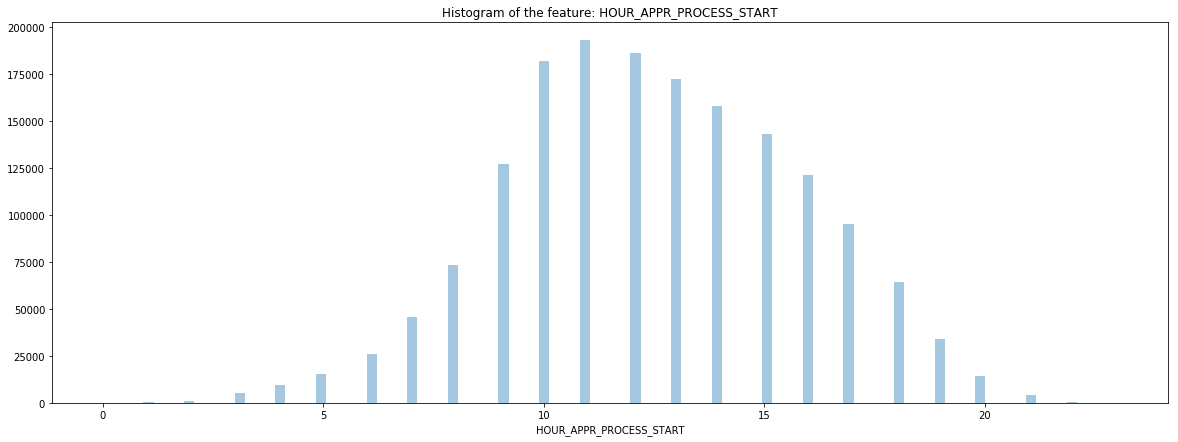

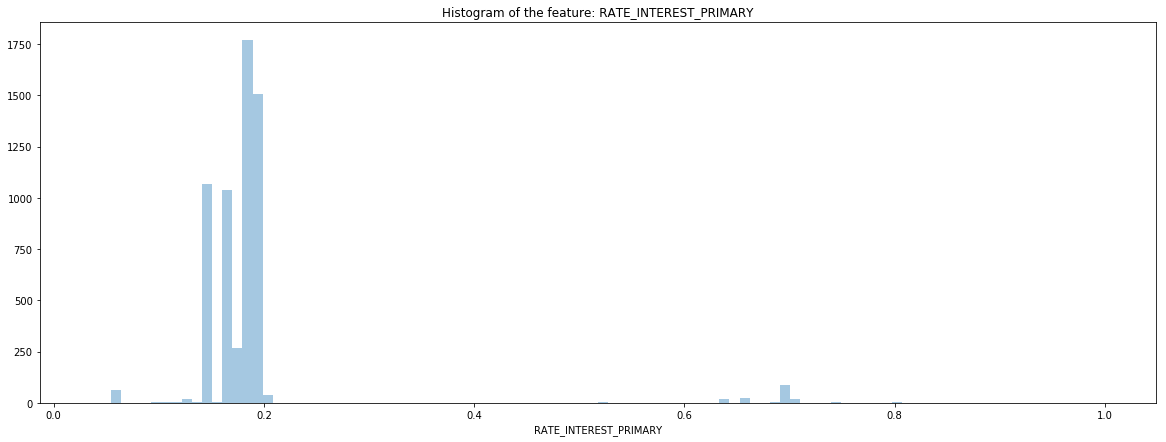

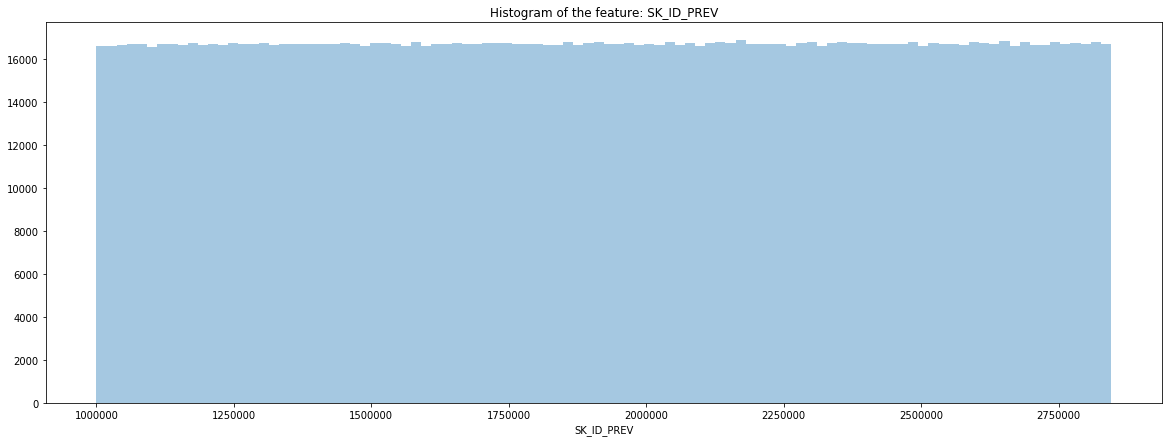

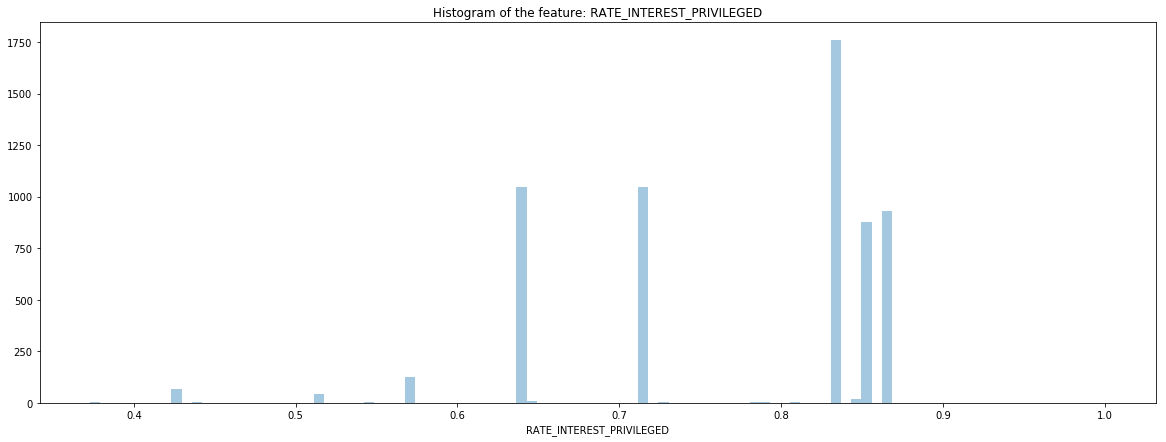

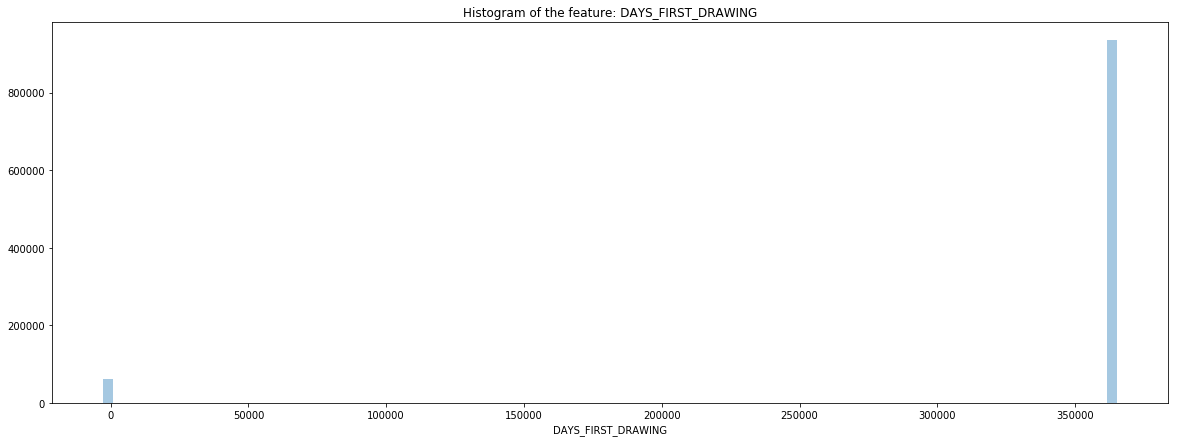

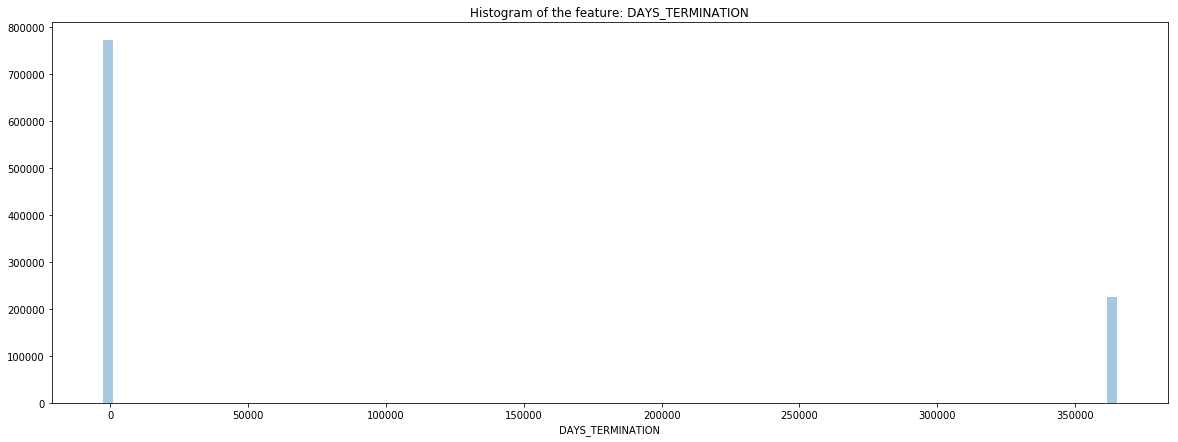

In [35]:
for feature in numerical_features_lst:
    fig, ax = plt.subplots(1, 1, sharex = False, sharey = False, figsize = (20, 7))
    
    # Plot feature distribution
    sns.distplot(previous_application_data_df[feature].dropna(), kde = False, bins = 100, ax = ax)
    ax.set_title("Histogram of the feature: " + feature)

Here we can see lots of outliers in the features and high skewness. There is something strange in the data for the following features: *DAYS_TERMINATION*, *DAYS_FIRST_DRAWING*, *DAYS_FIRST_DUE*, *DAYS_LAST_DUE_1ST_VERSION* and *DAYS_LAST_DUE*: all those features have an important amount of values greater than 350000 days. This is roughly equal to 1000 years. How can this be possible? Are those values a placeholder/default value?

Now, let's look at missing values.

Text(0.5,1,'Percentage of missing values in the previous applications data')

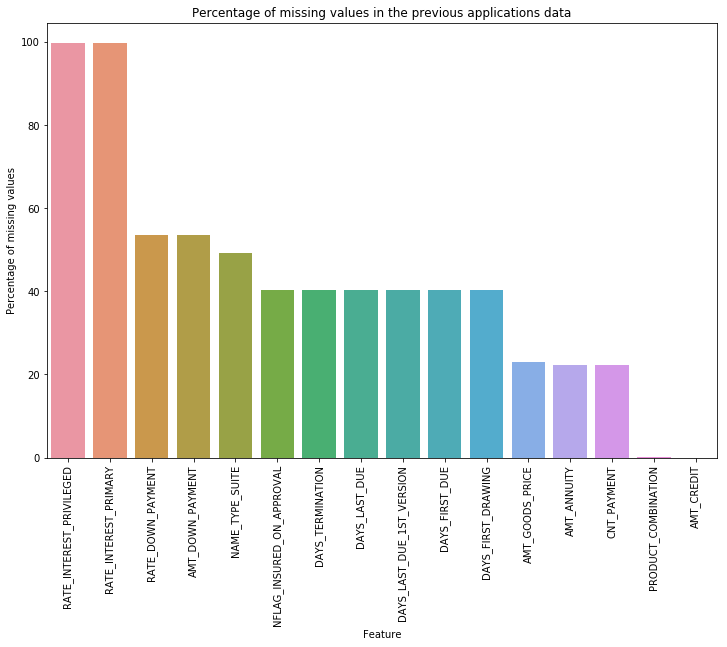

In [36]:
missing_values_sr = previous_application_data_df.isnull().sum()
missing_values_df = missing_values_sr.loc[missing_values_sr > 0].sort_values(ascending = False).reset_index()
missing_values_df.columns = ["Feature", "Number of missing values"]
missing_values_df["Percentage of missing values"] = (missing_values_df["Number of missing values"] / previous_application_data_df.shape[0]) * 100

sns.barplot(x = missing_values_df["Feature"], y = missing_values_df["Percentage of missing values"])
plt.xticks(rotation = 90)
plt.title("Percentage of missing values in the previous applications data")

Here we can see that two features have nearly 100% of missing values. For other features that have missing values, we can see that some features have the same number of missing values. It's possible that there is correlation between missing values for them.

In [5]:
training_set_df2 = training_set_df.select_dtypes(exclude = ["object"])
training_set_df2.select_dtypes(include = ["object"]).columns.tolist()

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE']